In [1]:
import pickle
import numpy as np
from scipy import sparse
import pandas as pd
import seaborn as sns
sns.set() ## set up style
import uuid
import time
import matplotlib.pyplot as plt
#solved chinese display in matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
# rcParams["font.family"] = "DFKai-SB"
rcParams['axes.unicode_minus'] = False
from tqdm import tqdm_notebook,tnrange
# from tqdm.autonotebook import tqdm
# tqdm.pandas()

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import visdom
vis=visdom.Visdom()
from BuildDataset import Tripletdataset
from Model import Encoder,Decoder,EncoderOneLayer,DecoderOneLayer
industry=['金融業', 'IC製造', 'IC設計', '電子零件元件', '電腦系統業', '石油及天然氣', '手機', '面板業', '太陽能',
       '板鋼', '被動元件', '車輛整車', '非鐵金屬', '流通業', '地產', '通訊設備', '遊戲產業', '印刷電路板相關',
       '貴金屬', '機械', '運輸事業', '電子通路', 'IC封裝測試', 'LED', '通訊服務', '消費性電子產品', '化學工業',
       '醫藥產業', '軟體業', '週邊產品', '石化業', '旅館、餐飲', '汽機車零組件', '設備儀器廠商', '條鋼', '造紙業',
       '水泥', '橡膠工業', '傳產其他', '數位相機', '顯示器', '不鏽鋼', '農林漁牧', '服務業', 'Internet相關',
       '營造工程', '休閒娛樂', '紡織中游', '生物科技', '家電', '光碟片', '建材', '成衣', '電力', '運動產業',
       '線材、盤元', '化纖原料', '其他公用事業', '大宗物資', '家居用品', '手機零組件', '食品加工', '電力設備',
       '航天軍工', '分離式元件', '電子其他', '面板零組件', '飲料相關', '電線電纜', '封測服務與材料', '礦石開採',
       '光通訊', '傳播事業', '輔助與彌補用醫材', '時尚產業', '基礎建設營運', '電聲產品', '水資源', '醫療器材通路',
       '合金鋼', '文化創意產業', '車用金屬成型', '穿戴式裝置', '其他醫療器材', '汽車內裝', '車用電子',
       '診斷與監測用醫材', '傳輸介面', '電子化工材料', '電池材料相關', '資產股', '醫療管理服務', '體外診斷用醫材', '煤',
       '射頻前端晶片', '控股公司', '無店舖販售', '手術與治療用醫材', '金屬礦採選', '生物辨識相關']

In [2]:
## Load industry dictionary
with open("../dict_guid_sparsebow_20000_single.v05.p","rb") as f:
    dict_guid_sparsebow_single= pickle.load(f)
with open("../dict_singleindustry_guid.p","rb") as f:
    dict_singleindustry_guid= pickle.load(f)

In [3]:
## Industry with news more than 100 pics
industry_partial=industry[:80]

In [4]:
len(industry_partial)

80

#### Configuration for split dataset to triain and test

In [5]:
Split=8/18
Split_train_test=8/10

#### Sample part of Dataset

In [6]:
dict_split_industry_guid={ ind:np.random.choice(dict_singleindustry_guid[ind],
                                                     size=int(Split*len(dict_singleindustry_guid[ind])),
                                                     replace=False) for ind in industry_partial}

In [7]:
dict_train_industry_guid={ind:dict_split_industry_guid[ind][:int(Split_train_test*len(dict_split_industry_guid[ind]))]
                          for ind in dict_split_industry_guid}
dict_test_industry_guid={ind:dict_split_industry_guid[ind][int(Split_train_test*len(dict_split_industry_guid[ind])):]
                          for ind in dict_split_industry_guid}

In [8]:
dict_str_list=dict_split_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         7083
IC製造        3338
IC設計        3187
電子零件元件      2932
電腦系統業       2282
石油及天然氣      2160
手機          2139
面板業         1929
太陽能         1819
板鋼          1656
被動元件        1643
車輛整車        1631
非鐵金屬        1612
流通業         1540
地產          1392
通訊設備        1368
遊戲產業        1341
印刷電路板相關     1299
貴金屬         1174
機械          1078
運輸事業        1077
電子通路        1008
IC封裝測試       905
LED          798
通訊服務         797
消費性電子產品      707
化學工業         698
醫藥產業         671
軟體業          669
週邊產品         669
            ... 
光碟片          228
建材           197
成衣           195
電力           187
運動產業         182
線材、盤元        181
化纖原料         176
其他公用事業       168
大宗物資         165
家居用品         158
手機零組件        139
食品加工         129
電力設備         123
航天軍工         117
分離式元件        115
電子其他         108
面板零組件        102
飲料相關          93
電線電纜          91
封測服務與材料       90
礦石開採          78
光通訊           63
傳播事業          61
時尚產業          60
輔助與彌補用醫材      60
基礎建設營運        54
電聲產品          52
水資源           

In [9]:
dict_str_list=dict_train_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         4958
IC製造        2336
IC設計        2230
電子零件元件      2052
電腦系統業       1597
石油及天然氣      1512
手機          1497
面板業         1350
太陽能         1273
板鋼          1159
被動元件        1150
車輛整車        1141
非鐵金屬        1128
流通業         1078
地產           974
通訊設備         957
遊戲產業         938
印刷電路板相關      909
貴金屬          821
機械           754
運輸事業         753
電子通路         705
IC封裝測試       633
LED          558
通訊服務         557
消費性電子產品      494
化學工業         488
醫藥產業         469
軟體業          468
週邊產品         468
            ... 
光碟片          159
建材           137
成衣           136
電力           130
運動產業         127
線材、盤元        126
化纖原料         123
其他公用事業       117
大宗物資         115
家居用品         110
手機零組件         97
食品加工          90
電力設備          86
航天軍工          81
分離式元件         80
電子其他          75
面板零組件         71
飲料相關          65
電線電纜          63
封測服務與材料       62
礦石開採          54
光通訊           44
傳播事業          42
時尚產業          42
輔助與彌補用醫材      42
基礎建設營運        37
電聲產品          36
水資源           

In [10]:
dict_str_list=dict_test_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         2125
IC製造        1002
IC設計         957
電子零件元件       880
電腦系統業        685
石油及天然氣       648
手機           642
面板業          579
太陽能          546
板鋼           497
被動元件         493
車輛整車         490
非鐵金屬         484
流通業          462
地產           418
通訊設備         411
遊戲產業         403
印刷電路板相關      390
貴金屬          353
機械           324
運輸事業         324
電子通路         303
IC封裝測試       272
通訊服務         240
LED          240
消費性電子產品      213
化學工業         210
醫藥產業         202
軟體業          201
週邊產品         201
            ... 
光碟片           69
建材            60
成衣            59
電力            57
線材、盤元         55
運動產業          55
化纖原料          53
其他公用事業        51
大宗物資          50
家居用品          48
手機零組件         42
食品加工          39
電力設備          37
航天軍工          36
分離式元件         35
電子其他          33
面板零組件         31
封測服務與材料       28
電線電纜          28
飲料相關          28
礦石開採          24
光通訊           19
傳播事業          19
時尚產業          18
輔助與彌補用醫材      18
基礎建設營運        17
電聲產品          16
水資源           

#### Configure to train

In [8]:
Epochs=11500
P=3
K=6
PK=P*K
inputDim=20000
repzDim=500
alpha=2
PK*(K-1)*(PK-K)

1080

#### Dataset  & Model & Criterion & Optimizer Instantiation

In [9]:
dataset=Tripletdataset(industry_partial,
                       dict_train_industry_guid,
                       dict_guid_sparsebow_single,
                       P=P,K=K,
                      )
testset=Tripletdataset(industry_partial,
                       dict_test_industry_guid,
                       dict_guid_sparsebow_single,
                       P=P,K=K,
                      )

modelEncoder = EncoderOneLayer(inputDim,repzDim).to(device)
# modelEncoder.eval()
modelDecoder = DecoderOneLayer(repzDim,inputDim).to(device)
# modelEncoder.eval()

def criterionTri(h0,h1,h2,reduction="mean"):
    h01=(h0*h1).sum(dim=1)
    h02=(h0*h2).sum(dim=1)
    Lt=torch.log(1+torch.exp(h02-h01))
    if reduction=="mean":
        return Lt.mean()
    if reduction=="none": assert False,"this function not yet" 
def criterionTriModf(h0,h1,h2,reduction="mean"):
    h01=(h0*h1).sum(dim=1)
    h02=(h0*h2).sum(dim=1)
    Lt=torch.log(h01)
criterionRC=torch.nn.BCELoss(reduction="mean") ## There is one called BCEWithLogitsLoss 
# optimizerSgd=torch.optim.SGD([{"params":modelEncoder.parameters()},
#                            {"params":modelDecoder.parameters()},
#                            ],
#                           lr=0.001,
#                             )
optimizer=torch.optim.Adam([{"params":modelEncoder.parameters()},
                           {"params":modelDecoder.parameters()},
                           ])

In [12]:
modelEncoder

EncoderOneLayer(
  (linear1): Linear(in_features=20000, out_features=500, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
modelDecoder

DecoderOneLayer(
  (linear1): Linear(in_features=500, out_features=20000, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)

In [10]:
def opts(**kwords):
    opts={"markers":False,"xlabel":"epochs","title":"Total Loss","width":1200,"heigh":300,"xtickmax":100}
    for k in kwords:
        opts[k]=kwords[k]
    return opts

#### Train

In [11]:
trainingloss={"loss":[],"lossRA":[],"lossRP":[],"lossRN":[],"lossT":[]}
testloss={"loss":[],"lossRA":[],"lossRP":[],"lossRN":[],"lossT":[]}
s_total=time.time()
for ep in tnrange(Epochs):
    s_epoch=time.time()
    ep+=1
    dataset.shuffle()
    for i, (batchData,batchTest) in enumerate(zip(dataset,testset)):
        
        s_batch=time.time()
        
        optimizer.zero_grad()
        
        s_prepare=time.time()
        ## Train 
        ## array int8 to float 32
        batchAnchor=batchData["batch_anchor"].astype(np.float32) 
        batchPositive=batchData["batch_positive"].astype(np.float32)
        batchNegative=batchData["batch_negative"].astype(np.float32)
        ## array  to tensor float 32
        batchAnchorTensor=torch.tensor(batchAnchor,dtype=torch.float32,device=device)
        batchPositiveTensor=torch.tensor(batchPositive,dtype=torch.float32,device=device)
        batchNegativeTensor=torch.tensor(batchNegative,dtype=torch.float32,device=device)
        
        e_prepare=time.time()
        
        s_inference=time.time()
        ## Inference
        #### encoding
        anchorRepz   = modelEncoder(batchAnchorTensor)
        positiceRepz = modelEncoder(batchPositiveTensor)
        negativeRepz = modelEncoder(batchNegativeTensor)
        #### decoding
        anchorRc   = modelDecoder(anchorRepz)
        positiveRc = modelDecoder(positiceRepz)
        negativeRc = modelDecoder(negativeRepz)
        
        lossRA = criterionRC(anchorRc,batchAnchorTensor)
        lossRP = criterionRC(positiveRc,batchPositiveTensor)
        lossRN = criterionRC(negativeRc,batchNegativeTensor)
        
        lossT = criterionTri(anchorRepz,positiceRepz,negativeRepz,reduction="mean")
        
        loss = lossRA + lossRP + lossRN + alpha*lossT
        
        e_inference = time.time()
        
        
        ## backward
        s_backward = time.time()
        loss.backward()
        e_backward = time.time()
        
        s_step=time.time()
        ## update
        optimizer.step()
        e_step=time.time()
        
        e_batch=time.time()
        ## record
#         with torch.no_grad():
#             trainingloss["loss"].append(loss.item())
#             trainingloss["lossRA"].append(lossRA.item())
#             trainingloss["lossRP"].append(lossRP.item())
#             trainingloss["lossRN"].append(lossRN.item())
#             trainingloss["lossT"].append(lossT.item())
    e_epoch=time.time()
    print("-------------------------------")
    print("epoch :",ep,"/",Epochs)
    print("epoch :",ep,"/",Epochs)
    print("loss  :",loss.item())
    print("lossRA:",lossRA.item(),",","lossRP:",lossRP.item(),",","lossRN:",lossRN.item())
    print("lossT :",lossT.item())
    print("Batch-Time:",np.round(e_batch-s_batch,3),"s")
    print("Batch-PreTime",np.round(e_prepare-s_prepare,3),"s")
    print("Batch-InfTime:",np.round(e_inference-s_inference,3),"s")
    print("Batch-BackTime:",np.round(e_backward-s_backward,3),"s")
    print("Batch-UpdateTime:",np.round(e_step-s_step,3),"s")
    print("Epoch-Time",np.round(e_epoch-s_epoch,3),"s")
    
    s_trainRecord=time.time()
    ## Trainset record
    with torch.no_grad():
        trainingloss["loss"].append(loss.item())
        trainingloss["lossRA"].append(lossRA.item())
        trainingloss["lossRP"].append(lossRP.item())
        trainingloss["lossRN"].append(lossRN.item())
        trainingloss["lossT"].append(lossT.item())
    e_trainRecord=time.time()
    s_testInference=time.time()
    ## Test Inference every epoch
    with torch.no_grad():
        ## array int8 to float 32
        batchAnchor   = batchTest["batch_anchor"].astype(np.float32) 
        batchPositive = batchTest["batch_positive"].astype(np.float32)
        batchNegative = batchTest["batch_negative"].astype(np.float32)
        ## array  to tensor float 32
        batchAnchorTensor   = torch.tensor(batchAnchor,dtype=torch.float32,device=device)
        batchPositiveTensor = torch.tensor(batchPositive,dtype=torch.float32,device=device)
        batchNegativeTensor = torch.tensor(batchNegative,dtype=torch.float32,device=device)
        ## Inference
        #### encoding
        anchorRepz   = modelEncoder(batchAnchorTensor)
        positiceRepz = modelEncoder(batchPositiveTensor)
        negativeRepz = modelEncoder(batchNegativeTensor)
        #### decoding
        anchorRc   = modelDecoder(anchorRepz)
        positiveRc = modelDecoder(positiceRepz)
        negativeRc = modelDecoder(negativeRepz)
        #### loss
        lossRA_test = criterionRC(anchorRc,batchAnchorTensor)
        lossRP_test = criterionRC(positiveRc,batchPositiveTensor)
        lossRN_test = criterionRC(negativeRc,batchNegativeTensor)
        lossT_test  = criterionTri(anchorRepz,positiceRepz,negativeRepz,reduction="mean")
        loss_test   = lossRA_test+lossRP_test+lossRN_test+alpha*lossT_test
    e_testInference=time.time()    
    s_testRecord=time.time()
    ### Testset Record
    testloss["loss"].append(loss_test.item())
    testloss["lossRA"].append(lossRA_test.item())
    testloss["lossRP"].append(lossRP_test.item())
    testloss["lossRN"].append(lossRN_test.item())
    testloss["lossT"].append(lossT_test.item())
    e_testRecord=time.time()
    s_plot=time.time()
    ##plot 
    win="train loss "
    vis.line(Y=[loss.item()]  ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossT"
    vis.line(Y=[lossT.item()] ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRA"
    vis.line(Y=[lossRA.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRP"
    vis.line(Y=[lossRP.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRN"
    vis.line(Y=[lossRN.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test loss "
    vis.line(Y=[loss_test.item()]  ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossT"
    vis.line(Y=[lossT_test.item()] ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRA"
    vis.line(Y=[lossRA_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRP"
    vis.line(Y=[lossRP_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRN"
    vis.line(Y=[lossRN_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))  
    e_plot=time.time()
    
    print("Trainset record:",np.round(e_trainRecord-s_trainRecord,3),"s")
    print("Test Inference",np.round(e_testInference-s_testInference,3),"s")
    print("Testset Record:",np.round(e_testRecord-s_testRecord,3),"s")
    print("Visom Plot:",np.round(s_plot-s_plot,3),"s")
e_total=time.time()
print("Time:",np.round(e_total-s_total,3),"s")

-------------------------------
epoch : 1 / 11500
epoch : 1 / 11500
loss  : 2.910612106323242
lossRA: 0.46014103293418884 , lossRP: 0.45988184213638306 , lossRN: 0.45977264642715454
lossT : 0.7654083371162415
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.557 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2 / 11500
epoch : 2 / 11500
loss  : 2.345076084136963
lossRA: 0.2159447968006134 , lossRP: 0.21510130167007446 , lossRN: 0.21498358249664307
lossT : 0.8495232462882996
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.466 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3 / 11500
epoch : 3 / 11500
loss  : 2.239495277404785
lossRA: 0.22241921722888947 , lossRP: 0.2237955331802

-------------------------------
epoch : 21 / 11500
epoch : 21 / 11500
loss  : 0.923690915107727
lossRA: 0.04911532998085022 , lossRP: 0.04989047348499298 , lossRN: 0.04990459606051445
lossT : 0.38739025592803955
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.516 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 22 / 11500
epoch : 22 / 11500
loss  : 0.6740198135375977
lossRA: 0.04151100665330887 , lossRP: 0.04187256470322609 , lossRN: 0.04194295406341553
lossT : 0.27434664964675903
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.652 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 23 / 11500
epoch : 23 / 11500
loss  : 1.115706205368042
lossRA: 0.03299372270703316 , lossRP: 0.033

-------------------------------
epoch : 40 / 11500
epoch : 40 / 11500
loss  : 0.826837420463562
lossRA: 0.036579057574272156 , lossRP: 0.0367339625954628 , lossRN: 0.037398986518383026
lossT : 0.3580627143383026
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.31 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 41 / 11500
epoch : 41 / 11500
loss  : 0.468028724193573
lossRA: 0.033961210399866104 , lossRP: 0.03296589106321335 , lossRN: 0.03306154906749725
lossT : 0.1840200275182724
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.529 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 42 / 11500
epoch : 42 / 11500
loss  : 0.34001049399375916
lossRA: 0.04106158763170242 , lossRP: 0.0

-------------------------------
epoch : 59 / 11500
epoch : 59 / 11500
loss  : 0.37474575638771057
lossRA: 0.03092479147017002 , lossRP: 0.031201515346765518 , lossRN: 0.03125646337866783
lossT : 0.14068149030208588
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.275 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 60 / 11500
epoch : 60 / 11500
loss  : 0.37554603815078735
lossRA: 0.030434006825089455 , lossRP: 0.030228035524487495 , lossRN: 0.030190659686923027
lossT : 0.14234666526317596
Batch-Time: 0.101 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.42 s
Trainset record: 0.002 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 61 / 11500
epoch : 61 / 11500
loss  : 0.8363807797431946
lossRA: 0.0534958615899086 , loss

-------------------------------
epoch : 78 / 11500
epoch : 78 / 11500
loss  : 0.1858099400997162
lossRA: 0.031990502029657364 , lossRP: 0.03243342414498329 , lossRN: 0.032194215804338455
lossT : 0.04459589347243309
Batch-Time: 0.101 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.618 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 79 / 11500
epoch : 79 / 11500
loss  : 0.1478746235370636
lossRA: 0.03137330338358879 , lossRP: 0.03125007823109627 , lossRN: 0.031341955065727234
lossT : 0.026954639703035355
Batch-Time: 0.094 s
Batch-PreTime 0.066 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.4 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 80 / 11500
epoch : 80 / 11500
loss  : 0.6709548234939575
lossRA: 0.03296927735209465 , lossRP

-------------------------------
epoch : 97 / 11500
epoch : 97 / 11500
loss  : 0.24762137234210968
lossRA: 0.037930939346551895 , lossRP: 0.03750760853290558 , lossRN: 0.03856099024415016
lossT : 0.06681092083454132
Batch-Time: 0.102 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.698 s
Trainset record: 0.002 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 98 / 11500
epoch : 98 / 11500
loss  : 0.7482834458351135
lossRA: 0.03533565253019333 , lossRP: 0.033352080732584 , lossRN: 0.033181559294462204
lossT : 0.3232070803642273
Batch-Time: 0.104 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.347 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 99 / 11500
epoch : 99 / 11500
loss  : 0.25697794556617737
lossRA: 0.0262376107275486 , lossRP:

-------------------------------
epoch : 116 / 11500
epoch : 116 / 11500
loss  : 0.45813530683517456
lossRA: 0.026410099118947983 , lossRP: 0.02651406265795231 , lossRN: 0.027061110362410545
lossT : 0.1890750229358673
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.488 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 117 / 11500
epoch : 117 / 11500
loss  : 0.31302475929260254
lossRA: 0.026857461780309677 , lossRP: 0.026502273976802826 , lossRN: 0.026409102603793144
lossT : 0.11662795394659042
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.528 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 118 / 11500
epoch : 118 / 11500
loss  : 0.20612037181854248
lossRA: 0.03239590674638

-------------------------------
epoch : 135 / 11500
epoch : 135 / 11500
loss  : 0.1552744209766388
lossRA: 0.028665266931056976 , lossRP: 0.02868255227804184 , lossRN: 0.028717363253235817
lossT : 0.034604623913764954
Batch-Time: 0.116 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.299 s
Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 136 / 11500
epoch : 136 / 11500
loss  : 0.21305514872074127
lossRA: 0.025604896247386932 , lossRP: 0.025410888716578484 , lossRN: 0.02531934529542923
lossT : 0.06836000829935074
Batch-Time: 0.087 s
Batch-PreTime 0.059 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 137 / 11500
epoch : 137 / 11500
loss  : 0.21158014237880707
lossRA: 0.02539533935487

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 154 / 11500
epoch : 154 / 11500
loss  : 0.20554712414741516
lossRA: 0.02462143823504448 , lossRP: 0.02472732402384281 , lossRN: 0.024837791919708252
lossT : 0.06568028032779694
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.523 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 155 / 11500
epoch : 155 / 11500
loss  : 0.2150837481021881
lossRA: 0.02328796684741974 , lossRP: 0.0233867559581995 , lossRN: 0.023223744705319405
lossT : 0.07259264588356018
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.608 s
Trainset record: 0.002 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 173 / 11500
epoch : 173 / 11500
loss  : 0.6370213627815247
lossRA: 0.026704279705882072 , lossRP: 0.02686651609838009 , lossRN: 0.02664109319448471
lossT : 0.27840474247932434
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.353 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 174 / 11500
epoch : 174 / 11500
loss  : 0.5595426559448242
lossRA: 0.03100576438009739 , lossRP: 0.03087814897298813 , lossRN: 0.030904611572623253
lossT : 0.23337706923484802
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.474 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 

Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 192 / 11500
epoch : 192 / 11500
loss  : 0.526727557182312
lossRA: 0.0376109704375267 , lossRP: 0.036951784044504166 , lossRN: 0.03732329234480858
lossT : 0.2074207365512848
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.274 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 193 / 11500
epoch : 193 / 11500
loss  : 0.47578155994415283
lossRA: 0.028539687395095825 , lossRP: 0.028689421713352203 , lossRN: 0.029256712645292282
lossT : 0.1946478635072708
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.491 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 194 / 1

Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 211 / 11500
epoch : 211 / 11500
loss  : 0.0862019807100296
lossRA: 0.0196914691478014 , lossRP: 0.019477710127830505 , lossRN: 0.019454196095466614
lossT : 0.013789302669465542
Batch-Time: 0.116 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.623 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 212 / 11500
epoch : 212 / 11500
loss  : 0.17774426937103271
lossRA: 0.027109693735837936 , lossRP: 0.02738035097718239 , lossRN: 0.027305468916893005
lossT : 0.047974374145269394
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.528 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoc

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 230 / 11500
epoch : 230 / 11500
loss  : 0.20721399784088135
lossRA: 0.02054750919342041 , lossRP: 0.020465673878788948 , lossRN: 0.020626762881875038
lossT : 0.07278702408075333
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.613 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 231 / 11500
epoch : 231 / 11500
loss  : 0.10254475474357605
lossRA: 0.02304091677069664 , lossRP: 0.022938955575227737 , lossRN: 0.023114323616027832
lossT : 0.01672527939081192
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.366 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoc

Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 249 / 11500
epoch : 249 / 11500
loss  : 0.15939699113368988
lossRA: 0.023575440049171448 , lossRP: 0.023400895297527313 , lossRN: 0.02352428250014782
lossT : 0.044448185712099075
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.433 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 250 / 11500
epoch : 250 / 11500
loss  : 0.0760059729218483
lossRA: 0.022746527567505836 , lossRP: 0.022618921473622322 , lossRN: 0.022570019587874413
lossT : 0.004035253077745438
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.516 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoc

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 268 / 11500
epoch : 268 / 11500
loss  : 0.10070338100194931
lossRA: 0.02485245279967785 , lossRP: 0.024983970448374748 , lossRN: 0.024962296709418297
lossT : 0.012952331453561783
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.284 s
Trainset record: 0.002 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 269 / 11500
epoch : 269 / 11500
loss  : 0.3319021761417389
lossRA: 0.026415547356009483 , lossRP: 0.026529328897595406 , lossRN: 0.02633076161146164
lossT : 0.12631326913833618
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.034 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch

Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 287 / 11500
epoch : 287 / 11500
loss  : 0.12315288931131363
lossRA: 0.019161231815814972 , lossRP: 0.01909041590988636 , lossRN: 0.019118234515190125
lossT : 0.03289150446653366
Batch-Time: 0.097 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.18 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 288 / 11500
epoch : 288 / 11500
loss  : 0.9590442180633545
lossRA: 0.026893168687820435 , lossRP: 0.026780109852552414 , lossRN: 0.026984745636582375
lossT : 0.43919309973716736
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.383 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch :

Trainset record: 0.002 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 306 / 11500
epoch : 306 / 11500
loss  : 0.1056450754404068
lossRA: 0.017694300040602684 , lossRP: 0.017775680869817734 , lossRN: 0.017715567722916603
lossT : 0.02622976526618004
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.392 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 307 / 11500
epoch : 307 / 11500
loss  : 0.3121984004974365
lossRA: 0.024999462068080902 , lossRP: 0.025581829249858856 , lossRN: 0.025104235857725143
lossT : 0.11825643479824066
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.302 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 325 / 11500
epoch : 325 / 11500
loss  : 0.10332918167114258
lossRA: 0.021145541220903397 , lossRP: 0.021133514121174812 , lossRN: 0.021077299490571022
lossT : 0.019986413419246674
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.575 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 326 / 11500
epoch : 326 / 11500
loss  : 0.3161245584487915
lossRA: 0.025146301835775375 , lossRP: 0.02521965280175209 , lossRN: 0.02540731430053711
lossT : 0.12017565220594406
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.426 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 344 / 11500
epoch : 344 / 11500
loss  : 0.08975037932395935
lossRA: 0.020150914788246155 , lossRP: 0.020124632865190506 , lossRN: 0.020108241587877274
lossT : 0.014683293178677559
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.353 s
Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 345 / 11500
epoch : 345 / 11500
loss  : 0.06355474889278412
lossRA: 0.01797083020210266 , lossRP: 0.018006298691034317 , lossRN: 0.017994746565818787
lossT : 0.004791438579559326
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.334 s
Trainset record: 0.0 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 363 / 11500
epoch : 363 / 11500
loss  : 0.07918468117713928
lossRA: 0.023378759622573853 , lossRP: 0.023409686982631683 , lossRN: 0.023437844589352608
lossT : 0.0044791968539357185
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.283 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 364 / 11500
epoch : 364 / 11500
loss  : 0.07987049967050552
lossRA: 0.022800428792834282 , lossRP: 0.022919360548257828 , lossRN: 0.02285454049706459
lossT : 0.005648087244480848
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.367 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 382 / 11500
epoch : 382 / 11500
loss  : 0.06959980726242065
lossRA: 0.021637404337525368 , lossRP: 0.02153790183365345 , lossRN: 0.02152320370078087
lossT : 0.0024506468325853348
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.406 s
Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 383 / 11500
epoch : 383 / 11500
loss  : 0.26948341727256775
lossRA: 0.019254334270954132 , lossRP: 0.01929473876953125 , lossRN: 0.01927982270717621
lossT : 0.10582726448774338
Batch-Time: 0.114 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.311 s
Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 401 / 11500
epoch : 401 / 11500
loss  : 0.05452262610197067
lossRA: 0.01665552891790867 , lossRP: 0.016644474118947983 , lossRN: 0.016672246158123016
lossT : 0.0022751870565116405
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.359 s
Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 402 / 11500
epoch : 402 / 11500
loss  : 0.07659314572811127
lossRA: 0.024204624816775322 , lossRP: 0.024198463186621666 , lossRN: 0.024236485362052917
lossT : 0.001976786646991968
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.285 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.002 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 420 / 11500
epoch : 420 / 11500
loss  : 0.13276875019073486
lossRA: 0.017811311408877373 , lossRP: 0.017737748101353645 , lossRN: 0.0177676510065794
lossT : 0.03972601518034935
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.338 s
Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 421 / 11500
epoch : 421 / 11500
loss  : 0.06767933070659637
lossRA: 0.020857036113739014 , lossRP: 0.02086108736693859 , lossRN: 0.020844126120209694
lossT : 0.0025585417170077562
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.013 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.001 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 439 / 11500
epoch : 439 / 11500
loss  : 0.06712933629751205
lossRA: 0.01629762351512909 , lossRP: 0.016246896237134933 , lossRN: 0.016239648684859276
lossT : 0.009172583930194378
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.331 s
Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 440 / 11500
epoch : 440 / 11500
loss  : 0.06331102550029755
lossRA: 0.017518216744065285 , lossRP: 0.017553914338350296 , lossRN: 0.017502378672361374
lossT : 0.0053682588040828705
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.151 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 458 / 11500
epoch : 458 / 11500
loss  : 0.1247689425945282
lossRA: 0.018142936751246452 , lossRP: 0.01820586435496807 , lossRN: 0.018153933808207512
lossT : 0.035133104771375656
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.58 s
Trainset record: 0.0 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 459 / 11500
epoch : 459 / 11500
loss  : 0.06836999207735062
lossRA: 0.021534064784646034 , lossRP: 0.021544180810451508 , lossRN: 0.02151036635041237
lossT : 0.0018906937912106514
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.437 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 460 

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 477 / 11500
epoch : 477 / 11500
loss  : 0.1700441837310791
lossRA: 0.019117828458547592 , lossRP: 0.019110172986984253 , lossRN: 0.019086776301264763
lossT : 0.05636470019817352
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.528 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 478 / 11500
epoch : 478 / 11500
loss  : 0.3195412755012512
lossRA: 0.018927188590168953 , lossRP: 0.018955130130052567 , lossRN: 0.01899227872490883
lossT : 0.1313333362340927
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.533 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 496 / 11500
epoch : 496 / 11500
loss  : 0.09342791885137558
lossRA: 0.02043432928621769 , lossRP: 0.02043817937374115 , lossRN: 0.02044820226728916
lossT : 0.01605360582470894
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.539 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 497 / 11500
epoch : 497 / 11500
loss  : 0.2097308188676834
lossRA: 0.01780015230178833 , lossRP: 0.017851997166872025 , lossRN: 0.017828667536377907
lossT : 0.078125
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.565 s
Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 498 / 11500
ep

Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 515 / 11500
epoch : 515 / 11500
loss  : 0.21187949180603027
lossRA: 0.01943531259894371 , lossRP: 0.019386889412999153 , lossRN: 0.019468776881694794
lossT : 0.07679425925016403
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.648 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 516 / 11500
epoch : 516 / 11500
loss  : 0.08090221136808395
lossRA: 0.026787512004375458 , lossRP: 0.026907123625278473 , lossRN: 0.026840155944228172
lossT : 0.0001837080781115219
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.618 s
Trainset record: 0.002 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 534 / 11500
epoch : 534 / 11500
loss  : 0.11310993880033493
lossRA: 0.017488282173871994 , lossRP: 0.017489921301603317 , lossRN: 0.017498815432190895
lossT : 0.030316460877656937
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.487 s
Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 535 / 11500
epoch : 535 / 11500
loss  : 0.07328160107135773
lossRA: 0.018564334139227867 , lossRP: 0.018577149137854576 , lossRN: 0.01850765570998192
lossT : 0.008816232904791832
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.463 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch

Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 553 / 11500
epoch : 553 / 11500
loss  : 0.06374936550855637
lossRA: 0.018569927662611008 , lossRP: 0.018633930012583733 , lossRN: 0.018525147810578346
lossT : 0.004010183271020651
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.479 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 554 / 11500
epoch : 554 / 11500
loss  : 0.0646604374051094
lossRA: 0.017296502366662025 , lossRP: 0.017394432798027992 , lossRN: 0.01734665222465992
lossT : 0.006311425473541021
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoc

Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 572 / 11500
epoch : 572 / 11500
loss  : 0.045710671693086624
lossRA: 0.014231853187084198 , lossRP: 0.014277721755206585 , lossRN: 0.014304381795227528
lossT : 0.001448358059860766
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.385 s
Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 573 / 11500
epoch : 573 / 11500
loss  : 0.13355502486228943
lossRA: 0.018690891563892365 , lossRP: 0.018701402470469475 , lossRN: 0.01867675967514515
lossT : 0.03874298557639122
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.608 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 591 / 11500
epoch : 591 / 11500
loss  : 0.09953224658966064
lossRA: 0.014413466677069664 , lossRP: 0.014388622716069221 , lossRN: 0.014387514442205429
lossT : 0.028171319514513016
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 592 / 11500
epoch : 592 / 11500
loss  : 0.0748535618185997
lossRA: 0.0166816134005785 , lossRP: 0.01666402257978916 , lossRN: 0.016673600301146507
lossT : 0.012417164631187916
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.243 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 610 / 11500
epoch : 610 / 11500
loss  : 0.1566673070192337
lossRA: 0.018461402505636215 , lossRP: 0.018356647342443466 , lossRN: 0.018481263890862465
lossT : 0.05068399757146835
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.179 s
Trainset record: 0.001 s
Test Inference 0.073 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 611 / 11500
epoch : 611 / 11500
loss  : 0.09615792334079742
lossRA: 0.015438110567629337 , lossRP: 0.015466277487576008 , lossRN: 0.015449639409780502
lossT : 0.024901950731873512
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.14 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 629 / 11500
epoch : 629 / 11500
loss  : 0.06610523164272308
lossRA: 0.021101748570799828 , lossRP: 0.021122124046087265 , lossRN: 0.02103522978723049
lossT : 0.0014230646193027496
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 630 / 11500
epoch : 630 / 11500
loss  : 0.05178746581077576
lossRA: 0.01560349389910698 , lossRP: 0.01557608786970377 , lossRN: 0.015591916628181934
lossT : 0.0025079839397221804
Batch-Time: 0.083 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.553 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6

Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 648 / 11500
epoch : 648 / 11500
loss  : 0.04824531823396683
lossRA: 0.015498694963753223 , lossRP: 0.01555433589965105 , lossRN: 0.015502491034567356
lossT : 0.0008448969456367195
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.093 s
Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 649 / 11500
epoch : 649 / 11500
loss  : 0.17951223254203796
lossRA: 0.021422995254397392 , lossRP: 0.021329108625650406 , lossRN: 0.021457426249980927
lossT : 0.057651348412036896
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.443 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 667 / 11500
epoch : 667 / 11500
loss  : 0.08267373591661453
lossRA: 0.016487756744027138 , lossRP: 0.016476834192872047 , lossRN: 0.01650139130651951
lossT : 0.016603875905275345
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.133 s
Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 668 / 11500
epoch : 668 / 11500
loss  : 0.384201318025589
lossRA: 0.015471341088414192 , lossRP: 0.015474298037588596 , lossRN: 0.015459580346941948
lossT : 0.16889804601669312
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.104 s
Trainset record: 0.001 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 686 / 11500
epoch : 686 / 11500
loss  : 0.06359195709228516
lossRA: 0.01450351718813181 , lossRP: 0.014542747288942337 , lossRN: 0.014563058502972126
lossT : 0.009991317056119442
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.591 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 687 / 11500
epoch : 687 / 11500
loss  : 0.15446487069129944
lossRA: 0.014110691845417023 , lossRP: 0.014128622598946095 , lossRN: 0.01410865131765604
lossT : 0.056058451533317566
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.537 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 705 / 11500
epoch : 705 / 11500
loss  : 0.07573367655277252
lossRA: 0.01717771403491497 , lossRP: 0.01724342256784439 , lossRN: 0.017193909734487534
lossT : 0.012059315107762814
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 706 / 11500
epoch : 706 / 11500
loss  : 0.14153051376342773
lossRA: 0.017258794978260994 , lossRP: 0.017234669998288155 , lossRN: 0.0172385536134243
lossT : 0.04489924758672714
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.381 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 724 / 11500
epoch : 724 / 11500
loss  : 0.293491005897522
lossRA: 0.016770698130130768 , lossRP: 0.016757125034928322 , lossRN: 0.016791606321930885
lossT : 0.12158578634262085
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.238 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 725 / 11500
epoch : 725 / 11500
loss  : 0.07985781878232956
lossRA: 0.018799807876348495 , lossRP: 0.018822429701685905 , lossRN: 0.018809540197253227
lossT : 0.011713020503520966
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.318 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 743 / 11500
epoch : 743 / 11500
loss  : 0.07529096305370331
lossRA: 0.02054031565785408 , lossRP: 0.020536843687295914 , lossRN: 0.020597675815224648
lossT : 0.006808063481003046
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.488 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 744 / 11500
epoch : 744 / 11500
loss  : 0.07411538809537888
lossRA: 0.019827494397759438 , lossRP: 0.019834507256746292 , lossRN: 0.019850008189678192
lossT : 0.007301689591258764
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.392 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch :

Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 762 / 11500
epoch : 762 / 11500
loss  : 0.1093592643737793
lossRA: 0.01866588182747364 , lossRP: 0.01867096871137619 , lossRN: 0.018671542406082153
lossT : 0.02667543664574623
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.6 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 763 / 11500
epoch : 763 / 11500
loss  : 0.060385171324014664
lossRA: 0.012675163336098194 , lossRP: 0.012697165831923485 , lossRN: 0.012683693319559097
lossT : 0.011164573952555656
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.722 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch

Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 781 / 11500
epoch : 781 / 11500
loss  : 0.11283010244369507
lossRA: 0.019037339836359024 , lossRP: 0.01902240701019764 , lossRN: 0.019024627283215523
lossT : 0.02787286601960659
Batch-Time: 0.118 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.029 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.273 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 782 / 11500
epoch : 782 / 11500
loss  : 0.03949180990457535
lossRA: 0.012216842733323574 , lossRP: 0.012240389361977577 , lossRN: 0.012239715084433556
lossT : 0.0013974308967590332
Batch-Time: 0.113 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.429 s
Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 800 / 11500
epoch : 800 / 11500
loss  : 0.04218373820185661
lossRA: 0.01301127765327692 , lossRP: 0.01301659271121025 , lossRN: 0.012998818419873714
lossT : 0.0015785255236551166
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.329 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 801 / 11500
epoch : 801 / 11500
loss  : 0.06876644492149353
lossRA: 0.014983747154474258 , lossRP: 0.014959527179598808 , lossRN: 0.014978660270571709
lossT : 0.011922253295779228
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.352 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.001 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 819 / 11500
epoch : 819 / 11500
loss  : 0.05991247296333313
lossRA: 0.01881873980164528 , lossRP: 0.018830975517630577 , lossRN: 0.018830327317118645
lossT : 0.0017162150470539927
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.579 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 820 / 11500
epoch : 820 / 11500
loss  : 0.05774107575416565
lossRA: 0.016115060076117516 , lossRP: 0.016139637678861618 , lossRN: 0.01617765985429287
lossT : 0.004654358606785536
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 838 / 11500
epoch : 838 / 11500
loss  : 0.04369797185063362
lossRA: 0.012723484076559544 , lossRP: 0.012759828940033913 , lossRN: 0.012723014689981937
lossT : 0.0027458220720291138
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.434 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 839 / 11500
epoch : 839 / 11500
loss  : 0.049288563430309296
lossRA: 0.015231511555612087 , lossRP: 0.015231521800160408 , lossRN: 0.015204099006950855
lossT : 0.001810716581530869
Batch-Time: 0.083 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.46 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.002 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 857 / 11500
epoch : 857 / 11500
loss  : 0.05977926403284073
lossRA: 0.016678033396601677 , lossRP: 0.01666189171373844 , lossRN: 0.016654333099722862
lossT : 0.0048925019800662994
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.009 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 858 / 11500
epoch : 858 / 11500
loss  : 0.06261339783668518
lossRA: 0.016272440552711487 , lossRP: 0.01628713309764862 , lossRN: 0.016285836696624756
lossT : 0.006883994676172733
Batch-Time: 0.098 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.12 s
Trainset record: 0.001 s
Test Inference 0.076 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 876 / 11500
epoch : 876 / 11500
loss  : 0.16525119543075562
lossRA: 0.020151592791080475 , lossRP: 0.02024407498538494 , lossRN: 0.020191576331853867
lossT : 0.05233197286725044
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.553 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 877 / 11500
epoch : 877 / 11500
loss  : 0.05384047329425812
lossRA: 0.017702972516417503 , lossRP: 0.01766902580857277 , lossRN: 0.017720583826303482
lossT : 0.00037394670653156936
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.364 s
Trainset record: 0.0 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8

Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 895 / 11500
epoch : 895 / 11500
loss  : 0.0632394403219223
lossRA: 0.014172160066664219 , lossRP: 0.014154397882521152 , lossRN: 0.014180167578160763
lossT : 0.01036635972559452
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 896 / 11500
epoch : 896 / 11500
loss  : 0.06631059944629669
lossRA: 0.02101406827569008 , lossRP: 0.02101282961666584 , lossRN: 0.020975172519683838
lossT : 0.0016542653320357203
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.326 s
Trainset record: 0.001 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 914 / 11500
epoch : 914 / 11500
loss  : 0.044184982776641846
lossRA: 0.01269842591136694 , lossRP: 0.012681091204285622 , lossRN: 0.012738118879497051
lossT : 0.003033672459423542
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.28 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 915 / 11500
epoch : 915 / 11500
loss  : 0.04137074947357178
lossRA: 0.011332663707435131 , lossRP: 0.011318945325911045 , lossRN: 0.011327344924211502
lossT : 0.0036958984564989805
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.101 s
Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 933 / 11500
epoch : 933 / 11500
loss  : 0.05032370239496231
lossRA: 0.014848128892481327 , lossRP: 0.014807533472776413 , lossRN: 0.014852150343358517
lossT : 0.0029079457744956017
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.406 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 934 / 11500
epoch : 934 / 11500
loss  : 0.06716644018888474
lossRA: 0.021957259625196457 , lossRP: 0.02201286144554615 , lossRN: 0.021923238411545753
lossT : 0.0006365403532981873
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.328 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 952 / 11500
epoch : 952 / 11500
loss  : 0.06629729270935059
lossRA: 0.016881609335541725 , lossRP: 0.016884956508874893 , lossRN: 0.016911180689930916
lossT : 0.007809774950146675
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.179 s
Trainset record: 0.0 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 953 / 11500
epoch : 953 / 11500
loss  : 0.12223696708679199
lossRA: 0.016298605129122734 , lossRP: 0.016284732148051262 , lossRN: 0.01626742258667946
lossT : 0.03669310361146927
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.271 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 

Trainset record: 0.002 s
Test Inference 0.071 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 971 / 11500
epoch : 971 / 11500
loss  : 0.06132218614220619
lossRA: 0.016992969438433647 , lossRP: 0.01695910282433033 , lossRN: 0.016998684033751488
lossT : 0.005185714457184076
Batch-Time: 0.086 s
Batch-PreTime 0.057 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.228 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 972 / 11500
epoch : 972 / 11500
loss  : 0.040542662143707275
lossRA: 0.012247462756931782 , lossRP: 0.01232557836920023 , lossRN: 0.012277656234800816
lossT : 0.0018459820421412587
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.588 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 990 / 11500
epoch : 990 / 11500
loss  : 0.04411601275205612
lossRA: 0.014682520180940628 , lossRP: 0.014635981991887093 , lossRN: 0.014665081165730953
lossT : 6.621441571041942e-05
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.403 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 991 / 11500
epoch : 991 / 11500
loss  : 0.043902792036533356
lossRA: 0.012858507223427296 , lossRP: 0.012895510531961918 , lossRN: 0.012867918238043785
lossT : 0.0026404287200421095
Batch-Time: 0.103 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.418 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1009 / 11500
epoch : 1009 / 11500
loss  : 0.05488896369934082
lossRA: 0.014920118264853954 , lossRP: 0.01487799733877182 , lossRN: 0.014896747656166553
lossT : 0.005097049288451672
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.443 s
Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1010 / 11500
epoch : 1010 / 11500
loss  : 0.029969172552227974
lossRA: 0.009617476724088192 , lossRP: 0.009643509984016418 , lossRN: 0.009620722383260727
lossT : 0.0005437315558083355
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.315 s
Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1028 / 11500
epoch : 1028 / 11500
loss  : 0.053673647344112396
lossRA: 0.013975172303617 , lossRP: 0.013995418325066566 , lossRN: 0.013992629945278168
lossT : 0.005855213850736618
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.379 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1029 / 11500
epoch : 1029 / 11500
loss  : 0.07090143859386444
lossRA: 0.014200951904058456 , lossRP: 0.01418461836874485 , lossRN: 0.014179275371134281
lossT : 0.014168295077979565
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.501 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1047 / 11500
epoch : 1047 / 11500
loss  : 0.07526759803295135
lossRA: 0.016128042712807655 , lossRP: 0.01610325276851654 , lossRN: 0.016091570258140564
lossT : 0.013472368009388447
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.453 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1048 / 11500
epoch : 1048 / 11500
loss  : 0.14445175230503082
lossRA: 0.0179089717566967 , lossRP: 0.01793394237756729 , lossRN: 0.017967374995350838
lossT : 0.04532073065638542
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.32 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1066 / 11500
epoch : 1066 / 11500
loss  : 0.10917915403842926
lossRA: 0.017281651496887207 , lossRP: 0.01733735203742981 , lossRN: 0.017317425459623337
lossT : 0.028621362522244453
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.489 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1067 / 11500
epoch : 1067 / 11500
loss  : 0.06439855694770813
lossRA: 0.018367642536759377 , lossRP: 0.018351467326283455 , lossRN: 0.018352655693888664
lossT : 0.004663397558033466
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.431 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1085 / 11500
epoch : 1085 / 11500
loss  : 0.3273121416568756
lossRA: 0.00997469574213028 , lossRP: 0.00997594278305769 , lossRN: 0.009947378188371658
lossT : 0.1487070620059967
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.385 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1086 / 11500
epoch : 1086 / 11500
loss  : 0.16460147500038147
lossRA: 0.015253006480634212 , lossRP: 0.015261773951351643 , lossRN: 0.015238514170050621
lossT : 0.05942409485578537
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.643 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1104 / 11500
epoch : 1104 / 11500
loss  : 0.04456339031457901
lossRA: 0.011111781001091003 , lossRP: 0.011115482077002525 , lossRN: 0.011136844754219055
lossT : 0.005599639844149351
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.193 s
Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1105 / 11500
epoch : 1105 / 11500
loss  : 0.040256839245557785
lossRA: 0.010760930366814137 , lossRP: 0.010777485556900501 , lossRN: 0.010708499699831009
lossT : 0.004004960414022207
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.667 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1123 / 11500
epoch : 1123 / 11500
loss  : 0.07498186081647873
lossRA: 0.014219755306839943 , lossRP: 0.014257342554628849 , lossRN: 0.0142505569383502
lossT : 0.016127102077007294
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.447 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1124 / 11500
epoch : 1124 / 11500
loss  : 0.030818769708275795
lossRA: 0.01010576356202364 , lossRP: 0.010095780715346336 , lossRN: 0.01009398978203535
lossT : 0.00026161724235862494
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.413 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1142 / 11500
epoch : 1142 / 11500
loss  : 0.054220885038375854
lossRA: 0.009074370376765728 , lossRP: 0.009042348712682724 , lossRN: 0.009065359830856323
lossT : 0.013519403524696827
Batch-Time: 0.118 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.029 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.314 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1143 / 11500
epoch : 1143 / 11500
loss  : 0.04877033084630966
lossRA: 0.012590775266289711 , lossRP: 0.012614545412361622 , lossRN: 0.012608880177140236
lossT : 0.005478065460920334
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.514 s
Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1161 / 11500
epoch : 1161 / 11500
loss  : 0.03386203199625015
lossRA: 0.009796603582799435 , lossRP: 0.009794296696782112 , lossRN: 0.00979141891002655
lossT : 0.002239857567474246
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.59 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1162 / 11500
epoch : 1162 / 11500
loss  : 0.07860879600048065
lossRA: 0.014645824208855629 , lossRP: 0.014598126523196697 , lossRN: 0.014644907787442207
lossT : 0.017359966412186623
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.547 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1180 / 11500
epoch : 1180 / 11500
loss  : 0.04294098913669586
lossRA: 0.00897603016346693 , lossRP: 0.008972697891294956 , lossRN: 0.00898392591625452
lossT : 0.008004168048501015
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.384 s
Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1181 / 11500
epoch : 1181 / 11500
loss  : 0.05189869925379753
lossRA: 0.015140417963266373 , lossRP: 0.015123287215828896 , lossRN: 0.015153606422245502
lossT : 0.00324069382622838
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.49 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoc

Trainset record: 0.001 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1199 / 11500
epoch : 1199 / 11500
loss  : 0.06286322325468063
lossRA: 0.0185184795409441 , lossRP: 0.018495338037610054 , lossRN: 0.01851053535938263
lossT : 0.0036694342270493507
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.466 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1200 / 11500
epoch : 1200 / 11500
loss  : 0.07206432521343231
lossRA: 0.017549263313412666 , lossRP: 0.017518742009997368 , lossRN: 0.01752287521958351
lossT : 0.009736721403896809
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.546 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1218 / 11500
epoch : 1218 / 11500
loss  : 0.06301458925008774
lossRA: 0.012463795952498913 , lossRP: 0.012465286068618298 , lossRN: 0.01243599969893694
lossT : 0.012824752368032932
Batch-Time: 0.102 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.316 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1219 / 11500
epoch : 1219 / 11500
loss  : 0.04248885065317154
lossRA: 0.013252006843686104 , lossRP: 0.013289320282638073 , lossRN: 0.013240176253020763
lossT : 0.001353673986159265
Batch-Time: 0.101 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1237 / 11500
epoch : 1237 / 11500
loss  : 0.06478072702884674
lossRA: 0.017479170113801956 , lossRP: 0.01746075600385666 , lossRN: 0.017493532970547676
lossT : 0.0061736321076750755
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.395 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1238 / 11500
epoch : 1238 / 11500
loss  : 0.05404586344957352
lossRA: 0.017315180972218513 , lossRP: 0.0173290204256773 , lossRN: 0.017333313822746277
lossT : 0.0010341741144657135
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.452 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1256 / 11500
epoch : 1256 / 11500
loss  : 0.03356961905956268
lossRA: 0.011055144481360912 , lossRP: 0.011052308604121208 , lossRN: 0.011060991324484348
lossT : 0.00020058738300576806
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.479 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1257 / 11500
epoch : 1257 / 11500
loss  : 0.056766971945762634
lossRA: 0.014434405602514744 , lossRP: 0.014411608688533306 , lossRN: 0.0144285187125206
lossT : 0.0067462194710969925
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.262 s
Trainset record: 0.001 s
Test Inference 0.11 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1275 / 11500
epoch : 1275 / 11500
loss  : 0.04703577607870102
lossRA: 0.01142458338290453 , lossRP: 0.01148141361773014 , lossRN: 0.011486051604151726
lossT : 0.006321863271296024
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.257 s
Trainset record: 0.002 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1276 / 11500
epoch : 1276 / 11500
loss  : 0.04835711047053337
lossRA: 0.013752822764217854 , lossRP: 0.013733888976275921 , lossRN: 0.013705341145396233
lossT : 0.00358252739533782
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.26 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.0 s
Test Inference 0.093 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1294 / 11500
epoch : 1294 / 11500
loss  : 0.046985920518636703
lossRA: 0.015605493448674679 , lossRP: 0.01561233215034008 , lossRN: 0.015610081143677235
lossT : 7.900803757365793e-05
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.479 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1295 / 11500
epoch : 1295 / 11500
loss  : 0.057138148695230484
lossRA: 0.016092127189040184 , lossRP: 0.016072586178779602 , lossRN: 0.01605074852705002
lossT : 0.004461342468857765
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.124 s
Trainset record: 0.002 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1313 / 11500
epoch : 1313 / 11500
loss  : 0.0987095832824707
lossRA: 0.01447363756597042 , lossRP: 0.014427141286432743 , lossRN: 0.014505935832858086
lossT : 0.027651434764266014
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.191 s
Trainset record: 0.002 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1314 / 11500
epoch : 1314 / 11500
loss  : 0.05461824685335159
lossRA: 0.015483936294913292 , lossRP: 0.015427825972437859 , lossRN: 0.015405821613967419
lossT : 0.004150331020355225
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.441 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoc

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1332 / 11500
epoch : 1332 / 11500
loss  : 0.03072221390902996
lossRA: 0.010043002665042877 , lossRP: 0.01003696583211422 , lossRN: 0.010024534538388252
lossT : 0.00030885532032698393
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.466 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1333 / 11500
epoch : 1333 / 11500
loss  : 0.03379544988274574
lossRA: 0.011040570214390755 , lossRP: 0.010994592681527138 , lossRN: 0.01104543823748827
lossT : 0.0003574248112272471
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.374 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1351 / 11500
epoch : 1351 / 11500
loss  : 0.03950551524758339
lossRA: 0.01303821336477995 , lossRP: 0.01306051667779684 , lossRN: 0.013056959956884384
lossT : 0.000174911372596398
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.486 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1352 / 11500
epoch : 1352 / 11500
loss  : 0.04050033912062645
lossRA: 0.013443445786833763 , lossRP: 0.013424375094473362 , lossRN: 0.013424759730696678
lossT : 0.00010387790098320693
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.282 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoc

Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1370 / 11500
epoch : 1370 / 11500
loss  : 0.04244389757514
lossRA: 0.013922409154474735 , lossRP: 0.013935075141489506 , lossRN: 0.013926378451287746
lossT : 0.0003300171811133623
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.166 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1371 / 11500
epoch : 1371 / 11500
loss  : 0.027766704559326172
lossRA: 0.008894161321222782 , lossRP: 0.0089045949280262 , lossRN: 0.008915605023503304
lossT : 0.0005261721089482307
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.508 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1389 / 11500
epoch : 1389 / 11500
loss  : 0.04343215003609657
lossRA: 0.0134683633223176 , lossRP: 0.013486277312040329 , lossRN: 0.013502905145287514
lossT : 0.0014873010804876685
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.31 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1390 / 11500
epoch : 1390 / 11500
loss  : 0.04557732492685318
lossRA: 0.01182567235082388 , lossRP: 0.011822795495390892 , lossRN: 0.011821214109659195
lossT : 0.005053822882473469
Batch-Time: 0.086 s
Batch-PreTime 0.057 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.14 s
Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1408 / 11500
epoch : 1408 / 11500
loss  : 0.05480200797319412
lossRA: 0.013229957781732082 , lossRP: 0.013227259740233421 , lossRN: 0.013234537094831467
lossT : 0.007555126212537289
Batch-Time: 0.081 s
Batch-PreTime 0.052 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.134 s
Trainset record: 0.001 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1409 / 11500
epoch : 1409 / 11500
loss  : 0.014185965992510319
lossRA: 0.004571255296468735 , lossRP: 0.004554667044430971 , lossRN: 0.004548854660242796
lossT : 0.00025559458299539983
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1427 / 11500
epoch : 1427 / 11500
loss  : 0.01938462071120739
lossRA: 0.006411654409021139 , lossRP: 0.006405303720384836 , lossRN: 0.006419707555323839
lossT : 7.397752051474527e-05
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.28 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1428 / 11500
epoch : 1428 / 11500
loss  : 0.09034170210361481
lossRA: 0.017748137935996056 , lossRP: 0.01774360053241253 , lossRN: 0.017773114144802094
lossT : 0.018538422882556915
Batch-Time: 0.083 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.204 s
Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1446 / 11500
epoch : 1446 / 11500
loss  : 0.04331882670521736
lossRA: 0.013219929300248623 , lossRP: 0.013233807869255543 , lossRN: 0.013206173665821552
lossT : 0.0018294575856998563
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.205 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1447 / 11500
epoch : 1447 / 11500
loss  : 0.02623763680458069
lossRA: 0.0061959195882081985 , lossRP: 0.006192265544086695 , lossRN: 0.006191714201122522
lossT : 0.00382886896841228
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.585 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1465 / 11500
epoch : 1465 / 11500
loss  : 0.027401674538850784
lossRA: 0.008983629755675793 , lossRP: 0.008981356397271156 , lossRN: 0.008990959264338017
lossT : 0.000222865492105484
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.57 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1466 / 11500
epoch : 1466 / 11500
loss  : 0.0451623797416687
lossRA: 0.0123893516138196 , lossRP: 0.012384556233882904 , lossRN: 0.012398011982440948
lossT : 0.003995229955762625
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.607 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1484 / 11500
epoch : 1484 / 11500
loss  : 0.04036595672369003
lossRA: 0.012935547158122063 , lossRP: 0.012956421822309494 , lossRN: 0.012911571189761162
lossT : 0.0007812075200490654
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.387 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1485 / 11500
epoch : 1485 / 11500
loss  : 0.05430217087268829
lossRA: 0.013662419281899929 , lossRP: 0.013664424419403076 , lossRN: 0.013646326959133148
lossT : 0.006664498709142208
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.266 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1503 / 11500
epoch : 1503 / 11500
loss  : 0.03623083606362343
lossRA: 0.011237941682338715 , lossRP: 0.01122503075748682 , lossRN: 0.011213078163564205
lossT : 0.001277392148040235
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.486 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1504 / 11500
epoch : 1504 / 11500
loss  : 0.13968636095523834
lossRA: 0.0194122064858675 , lossRP: 0.01938447915017605 , lossRN: 0.019405502825975418
lossT : 0.04074208810925484
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.285 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1522 / 11500
epoch : 1522 / 11500
loss  : 0.037124212831258774
lossRA: 0.011767042800784111 , lossRP: 0.011756119318306446 , lossRN: 0.011747291311621666
lossT : 0.0009268798166885972
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.226 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1523 / 11500
epoch : 1523 / 11500
loss  : 0.08158160746097565
lossRA: 0.014256480149924755 , lossRP: 0.014290389604866505 , lossRN: 0.014249308034777641
lossT : 0.0193927139043808
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.425 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1541 / 11500
epoch : 1541 / 11500
loss  : 0.02633564919233322
lossRA: 0.007272932678461075 , lossRP: 0.007256723940372467 , lossRN: 0.007262079045176506
lossT : 0.002271956531330943
Batch-Time: 0.102 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.586 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1542 / 11500
epoch : 1542 / 11500
loss  : 0.03930411860346794
lossRA: 0.012032647617161274 , lossRP: 0.012040692381560802 , lossRN: 0.0120385205373168
lossT : 0.0015961283352226019
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1560 / 11500
epoch : 1560 / 11500
loss  : 0.20643971860408783
lossRA: 0.013717838563024998 , lossRP: 0.013698515482246876 , lossRN: 0.013714968226850033
lossT : 0.0826542004942894
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1561 / 11500
epoch : 1561 / 11500
loss  : 0.04121312499046326
lossRA: 0.010234515182673931 , lossRP: 0.010214811190962791 , lossRN: 0.010234218090772629
lossT : 0.005264791660010815
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.567 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1579 / 11500
epoch : 1579 / 11500
loss  : 0.02685936726629734
lossRA: 0.00859264936298132 , lossRP: 0.008564744144678116 , lossRN: 0.008571434766054153
lossT : 0.0005652686231769621
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.387 s
Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1580 / 11500
epoch : 1580 / 11500
loss  : 0.03480745479464531
lossRA: 0.011232261545956135 , lossRP: 0.011213883757591248 , lossRN: 0.011263647116720676
lossT : 0.0005488328752107918
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.286 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1598 / 11500
epoch : 1598 / 11500
loss  : 0.050295643508434296
lossRA: 0.016565846279263496 , lossRP: 0.016546213999390602 , lossRN: 0.016550740227103233
lossT : 0.0003164227236993611
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.366 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1599 / 11500
epoch : 1599 / 11500
loss  : 0.05369218811392784
lossRA: 0.017433010041713715 , lossRP: 0.017411360517144203 , lossRN: 0.017454009503126144
lossT : 0.0006969048990868032
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.473 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1617 / 11500
epoch : 1617 / 11500
loss  : 0.02749440260231495
lossRA: 0.008933939971029758 , lossRP: 0.008948900736868382 , lossRN: 0.008915206417441368
lossT : 0.0003481779422145337
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.493 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1618 / 11500
epoch : 1618 / 11500
loss  : 0.036377180367708206
lossRA: 0.011545436456799507 , lossRP: 0.011528841219842434 , lossRN: 0.01154494658112526
lossT : 0.0008789784624241292
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1636 / 11500
epoch : 1636 / 11500
loss  : 0.05114327371120453
lossRA: 0.010371941141784191 , lossRP: 0.010368743911385536 , lossRN: 0.010367062874138355
lossT : 0.010017762891948223
Batch-Time: 0.113 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.498 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1637 / 11500
epoch : 1637 / 11500
loss  : 0.034086309373378754
lossRA: 0.010983522981405258 , lossRP: 0.011001242324709892 , lossRN: 0.011004151776432991
lossT : 0.0005486962618306279
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.516 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1655 / 11500
epoch : 1655 / 11500
loss  : 0.037718359380960464
lossRA: 0.011750886216759682 , lossRP: 0.011768240481615067 , lossRN: 0.01173584908246994
lossT : 0.0012316915672272444
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.474 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1656 / 11500
epoch : 1656 / 11500
loss  : 0.05578082427382469
lossRA: 0.017176778987050056 , lossRP: 0.01718563586473465 , lossRN: 0.017181849107146263
lossT : 0.0021182801574468613
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.412 s
Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1674 / 11500
epoch : 1674 / 11500
loss  : 0.025613106787204742
lossRA: 0.008387597277760506 , lossRP: 0.00834996160119772 , lossRN: 0.008326555602252483
lossT : 0.00027449647313915193
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.497 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1675 / 11500
epoch : 1675 / 11500
loss  : 0.03259328752756119
lossRA: 0.010505701415240765 , lossRP: 0.010514099150896072 , lossRN: 0.010512378066778183
lossT : 0.0005305546219460666
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.4 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1693 / 11500
epoch : 1693 / 11500
loss  : 0.02819104865193367
lossRA: 0.009306663647294044 , lossRP: 0.009310642257332802 , lossRN: 0.0093026552349329
lossT : 0.0001355434797005728
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.66 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1694 / 11500
epoch : 1694 / 11500
loss  : 0.014140564948320389
lossRA: 0.003568258136510849 , lossRP: 0.003590506734326482 , lossRN: 0.003601204138249159
lossT : 0.001690298318862915
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.503 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1712 / 11500
epoch : 1712 / 11500
loss  : 0.034845903515815735
lossRA: 0.009035089984536171 , lossRP: 0.009020697325468063 , lossRN: 0.009024842642247677
lossT : 0.0038826377131044865
Batch-Time: 0.095 s
Batch-PreTime 0.066 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.351 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1713 / 11500
epoch : 1713 / 11500
loss  : 0.041325852274894714
lossRA: 0.00759840989485383 , lossRP: 0.0075798942707479 , lossRN: 0.0075956350192427635
lossT : 0.009275955148041248
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.131 s
Trainset record: 0.002 s
Test Inference 0.074 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1731 / 11500
epoch : 1731 / 11500
loss  : 0.02905300073325634
lossRA: 0.008952670730650425 , lossRP: 0.008975297212600708 , lossRN: 0.008977280929684639
lossT : 0.001073876628652215
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.547 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1732 / 11500
epoch : 1732 / 11500
loss  : 0.034347616136074066
lossRA: 0.009247764945030212 , lossRP: 0.009271099232137203 , lossRN: 0.009265639819204807
lossT : 0.0032815570011734962
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.395 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1750 / 11500
epoch : 1750 / 11500
loss  : 0.030842291191220284
lossRA: 0.010201890021562576 , lossRP: 0.01019264291971922 , lossRN: 0.010203737765550613
lossT : 0.00012200978380860761
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.535 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1751 / 11500
epoch : 1751 / 11500
loss  : 0.03329867497086525
lossRA: 0.010492058470845222 , lossRP: 0.010506832040846348 , lossRN: 0.01053511630743742
lossT : 0.0008823326788842678
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.345 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1769 / 11500
epoch : 1769 / 11500
loss  : 0.01941530779004097
lossRA: 0.005439452361315489 , lossRP: 0.0054558562114834785 , lossRN: 0.005442049354314804
lossT : 0.0015389753971248865
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.508 s
Trainset record: 0.002 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1770 / 11500
epoch : 1770 / 11500
loss  : 0.21581441164016724
lossRA: 0.010562478564679623 , lossRP: 0.010539358481764793 , lossRN: 0.010548531077802181
lossT : 0.09208202362060547
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.336 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1788 / 11500
epoch : 1788 / 11500
loss  : 0.03673341125249863
lossRA: 0.010708305984735489 , lossRP: 0.010690051130950451 , lossRN: 0.010702508501708508
lossT : 0.0023162728175520897
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.279 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1789 / 11500
epoch : 1789 / 11500
loss  : 0.030410679057240486
lossRA: 0.009163929149508476 , lossRP: 0.009163448587059975 , lossRN: 0.009172392077744007
lossT : 0.0014554549707099795
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.454 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1807 / 11500
epoch : 1807 / 11500
loss  : 0.024426333606243134
lossRA: 0.008017527870833874 , lossRP: 0.008003409020602703 , lossRN: 0.008005381561815739
lossT : 0.00020000687800347805
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.55 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1808 / 11500
epoch : 1808 / 11500
loss  : 0.07467371970415115
lossRA: 0.009210974909365177 , lossRP: 0.009212109260261059 , lossRN: 0.00920037366449833
lossT : 0.02352513186633587
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1826 / 11500
epoch : 1826 / 11500
loss  : 0.034578125923871994
lossRA: 0.011423765681684017 , lossRP: 0.011486010625958443 , lossRN: 0.011446790769696236
lossT : 0.0001107799107558094
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.644 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1827 / 11500
epoch : 1827 / 11500
loss  : 0.016962861642241478
lossRA: 0.005232447758316994 , lossRP: 0.005238652229309082 , lossRN: 0.005232894327491522
lossT : 0.000629433779977262
Batch-Time: 0.102 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.629 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1845 / 11500
epoch : 1845 / 11500
loss  : 0.02732231467962265
lossRA: 0.00885547325015068 , lossRP: 0.008863881230354309 , lossRN: 0.008872667327523232
lossT : 0.00036514661042019725
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.605 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1846 / 11500
epoch : 1846 / 11500
loss  : 0.041300565004348755
lossRA: 0.013596842996776104 , lossRP: 0.013585704378783703 , lossRN: 0.013570950366556644
lossT : 0.00027353386394679546
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.485 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1864 / 11500
epoch : 1864 / 11500
loss  : 0.023007255047559738
lossRA: 0.007449158933013678 , lossRP: 0.007460629567503929 , lossRN: 0.007446020841598511
lossT : 0.00032572264899499714
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.464 s
Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1865 / 11500
epoch : 1865 / 11500
loss  : 0.03698671609163284
lossRA: 0.00992215983569622 , lossRP: 0.009911593049764633 , lossRN: 0.009944031946361065
lossT : 0.003604467026889324
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1883 / 11500
epoch : 1883 / 11500
loss  : 0.03993584215641022
lossRA: 0.010887149721384048 , lossRP: 0.010946921072900295 , lossRN: 0.010871190577745438
lossT : 0.0036152894608676434
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.451 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1884 / 11500
epoch : 1884 / 11500
loss  : 0.016296537593007088
lossRA: 0.005408779717981815 , lossRP: 0.005395146086812019 , lossRN: 0.005391130223870277
lossT : 5.0740785809466615e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.46 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1902 / 11500
epoch : 1902 / 11500
loss  : 0.03563399612903595
lossRA: 0.006961611565202475 , lossRP: 0.006953717675060034 , lossRN: 0.006951588671654463
lossT : 0.0073835402727127075
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.725 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1903 / 11500
epoch : 1903 / 11500
loss  : 0.02718157321214676
lossRA: 0.008626735769212246 , lossRP: 0.008635593578219414 , lossRN: 0.008592307567596436
lossT : 0.0006634681485593319
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1921 / 11500
epoch : 1921 / 11500
loss  : 0.05540340021252632
lossRA: 0.01335693895816803 , lossRP: 0.013364669866859913 , lossRN: 0.0133710578083992
lossT : 0.007655366789549589
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.631 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1922 / 11500
epoch : 1922 / 11500
loss  : 0.03358618915081024
lossRA: 0.0111898398026824 , lossRP: 0.011138148605823517 , lossRN: 0.011212893761694431
lossT : 2.265274088131264e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.767 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1940 / 11500
epoch : 1940 / 11500
loss  : 0.029185036197304726
lossRA: 0.009611141867935658 , lossRP: 0.00960493367165327 , lossRN: 0.009607896208763123
lossT : 0.0001805326173780486
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.381 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1941 / 11500
epoch : 1941 / 11500
loss  : 0.03774164989590645
lossRA: 0.01196806225925684 , lossRP: 0.011943728663027287 , lossRN: 0.011954491958022118
lossT : 0.0009376842644996941
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1959 / 11500
epoch : 1959 / 11500
loss  : 0.03107742965221405
lossRA: 0.008674579672515392 , lossRP: 0.008664836175739765 , lossRN: 0.008656148798763752
lossT : 0.0025409329682588577
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.511 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1960 / 11500
epoch : 1960 / 11500
loss  : 0.01751665212213993
lossRA: 0.005832930561155081 , lossRP: 0.0058162035420536995 , lossRN: 0.005824119783937931
lossT : 2.1698691853089258e-05
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.179 s
Trainset record: 0.001 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1978 / 11500
epoch : 1978 / 11500
loss  : 0.03520074486732483
lossRA: 0.011493225581943989 , lossRP: 0.011483761481940746 , lossRN: 0.011493010446429253
lossT : 0.00036537248524837196
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.365 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1979 / 11500
epoch : 1979 / 11500
loss  : 0.0482524037361145
lossRA: 0.013888897374272346 , lossRP: 0.01386057585477829 , lossRN: 0.013806387782096863
lossT : 0.0033482727594673634
Batch-Time: 0.083 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.427 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1997 / 11500
epoch : 1997 / 11500
loss  : 0.04089730978012085
lossRA: 0.007718289736658335 , lossRP: 0.007732533849775791 , lossRN: 0.007701735477894545
lossT : 0.008872375823557377
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.535 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 1998 / 11500
epoch : 1998 / 11500
loss  : 0.035511016845703125
lossRA: 0.010561099275946617 , lossRP: 0.010499940253794193 , lossRN: 0.010504479520022869
lossT : 0.001972748199477792
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.454 s
Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.0 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2016 / 11500
epoch : 2016 / 11500
loss  : 0.08745083212852478
lossRA: 0.017290135845541954 , lossRP: 0.017284920439124107 , lossRN: 0.017267495393753052
lossT : 0.017804142087697983
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2017 / 11500
epoch : 2017 / 11500
loss  : 0.035020485520362854
lossRA: 0.01168031059205532 , lossRP: 0.011676786467432976 , lossRN: 0.01164416503161192
lossT : 9.610785127733834e-06
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.448 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2035 / 11500
epoch : 2035 / 11500
loss  : 0.028347786515951157
lossRA: 0.009389890357851982 , lossRP: 0.009382897056639194 , lossRN: 0.009382342919707298
lossT : 9.632745059207082e-05
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.006 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2036 / 11500
epoch : 2036 / 11500
loss  : 0.02216969057917595
lossRA: 0.007350912317633629 , lossRP: 0.007371815852820873 , lossRN: 0.007353430148214102
lossT : 4.6766035666223615e-05
Batch-Time: 0.103 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.247 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2054 / 11500
epoch : 2054 / 11500
loss  : 0.08460251986980438
lossRA: 0.017409877851605415 , lossRP: 0.017385417595505714 , lossRN: 0.017405036836862564
lossT : 0.016201091930270195
Batch-Time: 0.1 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.587 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2055 / 11500
epoch : 2055 / 11500
loss  : 0.0075824870727956295
lossRA: 0.002369972411543131 , lossRP: 0.0023684431798756123 , lossRN: 0.0023796840105205774
lossT : 0.0002321937499800697
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2073 / 11500
epoch : 2073 / 11500
loss  : 0.029753318056464195
lossRA: 0.009809560142457485 , lossRP: 0.009784623049199581 , lossRN: 0.009782087057828903
lossT : 0.00018852372886613011
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.463 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2074 / 11500
epoch : 2074 / 11500
loss  : 0.3605267405509949
lossRA: 0.012469577603042126 , lossRP: 0.012431380338966846 , lossRN: 0.012422173283994198
lossT : 0.16160179674625397
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.564 s
Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2092 / 11500
epoch : 2092 / 11500
loss  : 0.04512620344758034
lossRA: 0.012376353144645691 , lossRP: 0.012355729006230831 , lossRN: 0.01239085104316473
lossT : 0.004001633729785681
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.48 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2093 / 11500
epoch : 2093 / 11500
loss  : 0.03922782093286514
lossRA: 0.01217584777623415 , lossRP: 0.01219124160706997 , lossRN: 0.01219390332698822
lossT : 0.0013334137620404363
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.571 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.002 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2111 / 11500
epoch : 2111 / 11500
loss  : 0.03015206940472126
lossRA: 0.009961196221411228 , lossRP: 0.009938301518559456 , lossRN: 0.009959022514522076
lossT : 0.0001467737602069974
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.562 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2112 / 11500
epoch : 2112 / 11500
loss  : 0.026483723893761635
lossRA: 0.008387351408600807 , lossRP: 0.008427881635725498 , lossRN: 0.008425727486610413
lossT : 0.0006213813321664929
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.256 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2130 / 11500
epoch : 2130 / 11500
loss  : 0.04031025245785713
lossRA: 0.01177776325494051 , lossRP: 0.011708337813615799 , lossRN: 0.011746383272111416
lossT : 0.002538884524255991
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.261 s
Trainset record: 0.002 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2131 / 11500
epoch : 2131 / 11500
loss  : 0.035945869982242584
lossRA: 0.011944678612053394 , lossRP: 0.011954237706959248 , lossRN: 0.011955924332141876
lossT : 4.551594611257315e-05
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.554 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2149 / 11500
epoch : 2149 / 11500
loss  : 0.09381738305091858
lossRA: 0.011979042552411556 , lossRP: 0.01195508148521185 , lossRN: 0.011994336731731892
lossT : 0.028944458812475204
Batch-Time: 0.113 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.511 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2150 / 11500
epoch : 2150 / 11500
loss  : 0.035136885941028595
lossRA: 0.010999299585819244 , lossRP: 0.011041369289159775 , lossRN: 0.011040574871003628
lossT : 0.0010278209811076522
Batch-Time: 0.124 s
Batch-PreTime 0.095 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.578 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2168 / 11500
epoch : 2168 / 11500
loss  : 0.037289611995220184
lossRA: 0.012393116019666195 , lossRP: 0.012361406348645687 , lossRN: 0.012375564314424992
lossT : 7.976272172527388e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.557 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2169 / 11500
epoch : 2169 / 11500
loss  : 0.04823744669556618
lossRA: 0.013047771528363228 , lossRP: 0.013090202584862709 , lossRN: 0.013097493909299374
lossT : 0.004500988405197859
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2187 / 11500
epoch : 2187 / 11500
loss  : 0.04256056994199753
lossRA: 0.009493852965533733 , lossRP: 0.009456380270421505 , lossRN: 0.009440178982913494
lossT : 0.007085078861564398
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.002 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2188 / 11500
epoch : 2188 / 11500
loss  : 0.01949147693812847
lossRA: 0.0064298552460968494 , lossRP: 0.006411290727555752 , lossRN: 0.00641625514253974
lossT : 0.00011703777272487059
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2206 / 11500
epoch : 2206 / 11500
loss  : 0.0326542966067791
lossRA: 0.010688332840800285 , lossRP: 0.010709230788052082 , lossRN: 0.010708346031606197
lossT : 0.000274192716460675
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2207 / 11500
epoch : 2207 / 11500
loss  : 0.016633009538054466
lossRA: 0.005413861013948917 , lossRP: 0.005423300433903933 , lossRN: 0.005391600076109171
lossT : 0.0002021243708441034
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.587 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2225 / 11500
epoch : 2225 / 11500
loss  : 0.05425095930695534
lossRA: 0.014257235452532768 , lossRP: 0.014302088879048824 , lossRN: 0.014278936199843884
lossT : 0.005706349387764931
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.623 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2226 / 11500
epoch : 2226 / 11500
loss  : 0.030441174283623695
lossRA: 0.01010474655777216 , lossRP: 0.010075781494379044 , lossRN: 0.010047037154436111
lossT : 0.00010680477134883404
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.484 s
Trainset record: 0.002 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2244 / 11500
epoch : 2244 / 11500
loss  : 0.046000897884368896
lossRA: 0.0115479975938797 , lossRP: 0.011548810638487339 , lossRN: 0.011581121012568474
lossT : 0.005661483854055405
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.492 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2245 / 11500
epoch : 2245 / 11500
loss  : 0.06745806336402893
lossRA: 0.011418529786169529 , lossRP: 0.011395028792321682 , lossRN: 0.011393171735107899
lossT : 0.01662566512823105
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.529 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoc

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2263 / 11500
epoch : 2263 / 11500
loss  : 0.1795118898153305
lossRA: 0.014270337298512459 , lossRP: 0.014240364544093609 , lossRN: 0.014252635650336742
lossT : 0.06837427616119385
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.355 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2264 / 11500
epoch : 2264 / 11500
loss  : 0.0345396026968956
lossRA: 0.007800720632076263 , lossRP: 0.007837209850549698 , lossRN: 0.007828223519027233
lossT : 0.00553672481328249
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.564 s
Trainset record: 0.002 s
Test Inference 0.121 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2282 / 11500
epoch : 2282 / 11500
loss  : 0.04298458248376846
lossRA: 0.014291083440184593 , lossRP: 0.014265493489801884 , lossRN: 0.014278456568717957
lossT : 7.477336475858465e-05
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2283 / 11500
epoch : 2283 / 11500
loss  : 0.05003916472196579
lossRA: 0.011626808904111385 , lossRP: 0.011623544618487358 , lossRN: 0.011631769128143787
lossT : 0.007578522898256779
Batch-Time: 0.115 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.525 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2301 / 11500
epoch : 2301 / 11500
loss  : 0.03506016731262207
lossRA: 0.011629797518253326 , lossRP: 0.01162064541131258 , lossRN: 0.01163137424737215
lossT : 8.917551895137876e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.193 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2302 / 11500
epoch : 2302 / 11500
loss  : 0.0446452870965004
lossRA: 0.00932624563574791 , lossRP: 0.0093086501583457 , lossRN: 0.009297316893935204
lossT : 0.00835653580725193
Batch-Time: 0.102 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.385 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2320 / 11500
epoch : 2320 / 11500
loss  : 0.028232473880052567
lossRA: 0.009330402128398418 , lossRP: 0.009348505176603794 , lossRN: 0.009307526051998138
lossT : 0.00012302004324737936
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2321 / 11500
epoch : 2321 / 11500
loss  : 0.024381641298532486
lossRA: 0.007930648513138294 , lossRP: 0.007924425415694714 , lossRN: 0.007905283942818642
lossT : 0.0003106413350906223
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.384 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2339 / 11500
epoch : 2339 / 11500
loss  : 0.026468943804502487
lossRA: 0.008679247461259365 , lossRP: 0.008676326833665371 , lossRN: 0.008652999065816402
lossT : 0.0002301853382959962
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.51 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2340 / 11500
epoch : 2340 / 11500
loss  : 0.03068089671432972
lossRA: 0.006049707997590303 , lossRP: 0.0060604470781981945 , lossRN: 0.006049980875104666
lossT : 0.006260380148887634
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.55 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2358 / 11500
epoch : 2358 / 11500
loss  : 0.03445230424404144
lossRA: 0.009755602106451988 , lossRP: 0.009786880575120449 , lossRN: 0.009770706295967102
lossT : 0.0025695578660815954
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.337 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2359 / 11500
epoch : 2359 / 11500
loss  : 0.036401599645614624
lossRA: 0.008386515080928802 , lossRP: 0.008395769633352757 , lossRN: 0.008363020606338978
lossT : 0.0056281485594809055
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.397 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2377 / 11500
epoch : 2377 / 11500
loss  : 0.040942128747701645
lossRA: 0.012607038021087646 , lossRP: 0.0126043651252985 , lossRN: 0.012668593786656857
lossT : 0.001531065790913999
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.559 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2378 / 11500
epoch : 2378 / 11500
loss  : 0.03569888323545456
lossRA: 0.011834084056317806 , lossRP: 0.011858620680868626 , lossRN: 0.011874932795763016
lossT : 6.56230331514962e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.57 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2396 / 11500
epoch : 2396 / 11500
loss  : 0.030589239671826363
lossRA: 0.010071727447211742 , lossRP: 0.010063736699521542 , lossRN: 0.010085219517350197
lossT : 0.00018427835311740637
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.513 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2397 / 11500
epoch : 2397 / 11500
loss  : 0.024196427315473557
lossRA: 0.007662876974791288 , lossRP: 0.007653623353689909 , lossRN: 0.007661017123609781
lossT : 0.0006094543496146798
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.318 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2415 / 11500
epoch : 2415 / 11500
loss  : 0.018732495605945587
lossRA: 0.005187250208109617 , lossRP: 0.005169432144612074 , lossRN: 0.005181156564503908
lossT : 0.0015973279951140285
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2416 / 11500
epoch : 2416 / 11500
loss  : 0.03662963584065437
lossRA: 0.01193965133279562 , lossRP: 0.011943802237510681 , lossRN: 0.011938955634832382
lossT : 0.0004036126774735749
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.473 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2434 / 11500
epoch : 2434 / 11500
loss  : 0.016691258177161217
lossRA: 0.005541514605283737 , lossRP: 0.005523449741303921 , lossRN: 0.0055299485102295876
lossT : 4.817224180442281e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.47 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2435 / 11500
epoch : 2435 / 11500
loss  : 0.020426662638783455
lossRA: 0.00677736708894372 , lossRP: 0.006755276117473841 , lossRN: 0.006767842918634415
lossT : 6.308912270469591e-05
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.352 s
Trainset record: 0.001 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.067 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2453 / 11500
epoch : 2453 / 11500
loss  : 0.024925319477915764
lossRA: 0.008188915438950062 , lossRP: 0.00816882960498333 , lossRN: 0.008183341473340988
lossT : 0.0001921161892823875
Batch-Time: 0.083 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.118 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2454 / 11500
epoch : 2454 / 11500
loss  : 0.028597751632332802
lossRA: 0.009465200826525688 , lossRP: 0.009423547424376011 , lossRN: 0.009418725967407227
lossT : 0.00014513797941617668
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.436 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2472 / 11500
epoch : 2472 / 11500
loss  : 0.020015478134155273
lossRA: 0.00666265282779932 , lossRP: 0.0066595845855772495 , lossRN: 0.006640342064201832
lossT : 2.6449126380612142e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.56 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2473 / 11500
epoch : 2473 / 11500
loss  : 0.03132282942533493
lossRA: 0.00970836915075779 , lossRP: 0.009718113578855991 , lossRN: 0.009717517532408237
lossT : 0.0010894148144870996
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.532 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2491 / 11500
epoch : 2491 / 11500
loss  : 0.031420525163412094
lossRA: 0.010399574413895607 , lossRP: 0.010354213416576385 , lossRN: 0.010371127165853977
lossT : 0.00014780422498006374
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.504 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2492 / 11500
epoch : 2492 / 11500
loss  : 0.022865327075123787
lossRA: 0.006889356300234795 , lossRP: 0.006859096698462963 , lossRN: 0.006870680022984743
lossT : 0.0011230967938899994
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.616 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2510 / 11500
epoch : 2510 / 11500
loss  : 0.029607245698571205
lossRA: 0.009793553501367569 , lossRP: 0.0097884526476264 , lossRN: 0.009784511290490627
lossT : 0.00012036276166327298
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.309 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2511 / 11500
epoch : 2511 / 11500
loss  : 0.043613266199827194
lossRA: 0.01172291487455368 , lossRP: 0.011726129800081253 , lossRN: 0.011760951019823551
lossT : 0.004201635718345642
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.362 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2529 / 11500
epoch : 2529 / 11500
loss  : 0.045228052884340286
lossRA: 0.015045272186398506 , lossRP: 0.01509416475892067 , lossRN: 0.015086118131875992
lossT : 1.2500903494583326e-06
Batch-Time: 0.113 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2530 / 11500
epoch : 2530 / 11500
loss  : 0.03353165462613106
lossRA: 0.010398037731647491 , lossRP: 0.010378940030932426 , lossRN: 0.010414558462798595
lossT : 0.0011700598988682032
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.514 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2548 / 11500
epoch : 2548 / 11500
loss  : 0.03441144526004791
lossRA: 0.010592451319098473 , lossRP: 0.010539380833506584 , lossRN: 0.010563632473349571
lossT : 0.0013579903170466423
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.546 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2549 / 11500
epoch : 2549 / 11500
loss  : 0.011077792383730412
lossRA: 0.0036342281382530928 , lossRP: 0.0036342209205031395 , lossRN: 0.003642336232587695
lossT : 8.35033060866408e-05
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.496 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2567 / 11500
epoch : 2567 / 11500
loss  : 0.02269110269844532
lossRA: 0.0073114302940666676 , lossRP: 0.007304247003048658 , lossRN: 0.007317191921174526
lossT : 0.00037911615800112486
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.495 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2568 / 11500
epoch : 2568 / 11500
loss  : 0.024469425901770592
lossRA: 0.007871145382523537 , lossRP: 0.007848377339541912 , lossRN: 0.00787859782576561
lossT : 0.0004356530262157321
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.571 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2586 / 11500
epoch : 2586 / 11500
loss  : 0.04740137234330177
lossRA: 0.014496349729597569 , lossRP: 0.014546221122145653 , lossRN: 0.014515217393636703
lossT : 0.0019217919325456023
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.283 s
Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2587 / 11500
epoch : 2587 / 11500
loss  : 0.03510693460702896
lossRA: 0.011209864169359207 , lossRP: 0.011217257007956505 , lossRN: 0.011209613643586636
lossT : 0.0007351001258939505
Batch-Time: 0.113 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2605 / 11500
epoch : 2605 / 11500
loss  : 0.03515315428376198
lossRA: 0.011152555234730244 , lossRP: 0.01117403618991375 , lossRN: 0.011168571189045906
lossT : 0.0008289952529594302
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.304 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2606 / 11500
epoch : 2606 / 11500
loss  : 0.02137690596282482
lossRA: 0.006749925669282675 , lossRP: 0.0067507061176002026 , lossRN: 0.006752423942089081
lossT : 0.0005619259900413454
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.356 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2624 / 11500
epoch : 2624 / 11500
loss  : 0.08572627604007721
lossRA: 0.011508408933877945 , lossRP: 0.011486043222248554 , lossRN: 0.011516187340021133
lossT : 0.025607816874980927
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.552 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2625 / 11500
epoch : 2625 / 11500
loss  : 0.02689974755048752
lossRA: 0.008749056607484818 , lossRP: 0.008737106807529926 , lossRN: 0.00874482560902834
lossT : 0.0003343797579873353
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.505 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2643 / 11500
epoch : 2643 / 11500
loss  : 0.02340352162718773
lossRA: 0.004242215771228075 , lossRP: 0.004223635885864496 , lossRN: 0.00423235772177577
lossT : 0.00535265589132905
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.293 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2644 / 11500
epoch : 2644 / 11500
loss  : 0.04462622478604317
lossRA: 0.011459860019385815 , lossRP: 0.011475622653961182 , lossRN: 0.011458411812782288
lossT : 0.005116165149956942
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.276 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2662 / 11500
epoch : 2662 / 11500
loss  : 0.01672399789094925
lossRA: 0.005414518062025309 , lossRP: 0.005421906244009733 , lossRN: 0.005399087443947792
lossT : 0.0002442430122755468
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.562 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2663 / 11500
epoch : 2663 / 11500
loss  : 0.02334636077284813
lossRA: 0.007720211986452341 , lossRP: 0.0077322982251644135 , lossRN: 0.007742972578853369
lossT : 7.543875108240172e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2681 / 11500
epoch : 2681 / 11500
loss  : 0.019403405487537384
lossRA: 0.006391340401023626 , lossRP: 0.006370342802256346 , lossRN: 0.00639792624861002
lossT : 0.00012189771950943395
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.078 s
Trainset record: 0.001 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2682 / 11500
epoch : 2682 / 11500
loss  : 0.04392082989215851
lossRA: 0.007182574365288019 , lossRP: 0.007198854349553585 , lossRN: 0.007184481248259544
lossT : 0.011177459731698036
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.208 s
Trainset record: 0.002 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2700 / 11500
epoch : 2700 / 11500
loss  : 0.0531766414642334
lossRA: 0.010077366605401039 , lossRP: 0.010086862370371819 , lossRN: 0.01011646818369627
lossT : 0.011447970755398273
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.492 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2701 / 11500
epoch : 2701 / 11500
loss  : 0.04127341881394386
lossRA: 0.012707640416920185 , lossRP: 0.012666583992540836 , lossRN: 0.01267440989613533
lossT : 0.0016123937675729394
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.572 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2719 / 11500
epoch : 2719 / 11500
loss  : 0.02813509665429592
lossRA: 0.008809151127934456 , lossRP: 0.008794737048447132 , lossRN: 0.008819419890642166
lossT : 0.00085589406080544
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2720 / 11500
epoch : 2720 / 11500
loss  : 0.06585249304771423
lossRA: 0.009940736927092075 , lossRP: 0.009957236237823963 , lossRN: 0.009961308911442757
lossT : 0.01799660362303257
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.52 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoc

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2738 / 11500
epoch : 2738 / 11500
loss  : 0.04039401561021805
lossRA: 0.013444425538182259 , lossRP: 0.0134425088763237 , lossRN: 0.013442708179354668
lossT : 3.218679194105789e-05
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.555 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2739 / 11500
epoch : 2739 / 11500
loss  : 0.09287802129983902
lossRA: 0.011353599838912487 , lossRP: 0.011385607533156872 , lossRN: 0.011368049308657646
lossT : 0.029385382309556007
Batch-Time: 0.117 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.536 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2757 / 11500
epoch : 2757 / 11500
loss  : 0.031331054866313934
lossRA: 0.009698808193206787 , lossRP: 0.009725154377520084 , lossRN: 0.009705021977424622
lossT : 0.001101036206819117
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.515 s
Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2758 / 11500
epoch : 2758 / 11500
loss  : 0.03411795198917389
lossRA: 0.010674839839339256 , lossRP: 0.010678085498511791 , lossRN: 0.010704210959374905
lossT : 0.001030407496728003
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.571 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2776 / 11500
epoch : 2776 / 11500
loss  : 0.1033896952867508
lossRA: 0.009091232903301716 , lossRP: 0.009073036722838879 , lossRN: 0.009089031256735325
lossT : 0.038068197667598724
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.568 s
Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2777 / 11500
epoch : 2777 / 11500
loss  : 0.02463683672249317
lossRA: 0.007600345648825169 , lossRP: 0.007597189862281084 , lossRN: 0.0075901770032942295
lossT : 0.0009245623950846493
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.499 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2795 / 11500
epoch : 2795 / 11500
loss  : 0.02530466765165329
lossRA: 0.008365705609321594 , lossRP: 0.008336806669831276 , lossRN: 0.008380984887480736
lossT : 0.00011058514064643532
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.571 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2796 / 11500
epoch : 2796 / 11500
loss  : 0.035545866936445236
lossRA: 0.011753723956644535 , lossRP: 0.011744626797735691 , lossRN: 0.011769868433475494
lossT : 0.0001388244127156213
Batch-Time: 0.11 s
Batch-PreTime 0.082 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.347 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2814 / 11500
epoch : 2814 / 11500
loss  : 0.02892630733549595
lossRA: 0.009551014751195908 , lossRP: 0.009536181576550007 , lossRN: 0.009547301568090916
lossT : 0.00014590556384064257
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.523 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2815 / 11500
epoch : 2815 / 11500
loss  : 0.04440058767795563
lossRA: 0.011158022098243237 , lossRP: 0.011189853772521019 , lossRN: 0.01119180303066969
lossT : 0.005430454853922129
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.495 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2833 / 11500
epoch : 2833 / 11500
loss  : 0.017057303339242935
lossRA: 0.005598125047981739 , lossRP: 0.005578582175076008 , lossRN: 0.005601816810667515
lossT : 0.00013938946358393878
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.371 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2834 / 11500
epoch : 2834 / 11500
loss  : 0.024727338925004005
lossRA: 0.008161992765963078 , lossRP: 0.00813433900475502 , lossRN: 0.008134500123560429
lossT : 0.00014825412654317915
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.62 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2852 / 11500
epoch : 2852 / 11500
loss  : 0.010496396571397781
lossRA: 0.0034389030188322067 , lossRP: 0.0034337984398007393 , lossRN: 0.0034504784271121025
lossT : 8.660829189466313e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.565 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2853 / 11500
epoch : 2853 / 11500
loss  : 0.016173474490642548
lossRA: 0.004561003763228655 , lossRP: 0.004582805093377829 , lossRN: 0.0045576696284115314
lossT : 0.0012359977699816227
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.511 s
Trainset record: 0.0 s
Test Inference 0.09 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2871 / 11500
epoch : 2871 / 11500
loss  : 0.03148234263062477
lossRA: 0.010178799740970135 , lossRP: 0.010210429318249226 , lossRN: 0.010205762460827827
lossT : 0.0004436750605236739
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.487 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2872 / 11500
epoch : 2872 / 11500
loss  : 0.03580215945839882
lossRA: 0.011877963319420815 , lossRP: 0.011879727244377136 , lossRN: 0.011845933273434639
lossT : 9.926799975801259e-05
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.601 s
Trainset record: 0.0 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2890 / 11500
epoch : 2890 / 11500
loss  : 0.016609331592917442
lossRA: 0.00528641976416111 , lossRP: 0.0052801864221692085 , lossRN: 0.00528251426294446
lossT : 0.0003801057755481452
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2891 / 11500
epoch : 2891 / 11500
loss  : 0.019867459312081337
lossRA: 0.006481884978711605 , lossRP: 0.006462170742452145 , lossRN: 0.006477016024291515
lossT : 0.000223194423597306
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2909 / 11500
epoch : 2909 / 11500
loss  : 0.040519632399082184
lossRA: 0.007465262431651354 , lossRP: 0.007456851191818714 , lossRN: 0.007468819618225098
lossT : 0.009064349345862865
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.568 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2910 / 11500
epoch : 2910 / 11500
loss  : 0.025501197203993797
lossRA: 0.008268246427178383 , lossRP: 0.008265240117907524 , lossRN: 0.008286537602543831
lossT : 0.00034058644087053835
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.551 s
Trainset record: 0.0 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2928 / 11500
epoch : 2928 / 11500
loss  : 0.02280854806303978
lossRA: 0.007595556788146496 , lossRP: 0.007607670500874519 , lossRN: 0.0076004331931471825
lossT : 2.4440093966404675e-06
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.511 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2929 / 11500
epoch : 2929 / 11500
loss  : 0.01939285174012184
lossRA: 0.005958174355328083 , lossRP: 0.005957239773124456 , lossRN: 0.005968560930341482
lossT : 0.0007544381660409272
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2947 / 11500
epoch : 2947 / 11500
loss  : 0.02782176248729229
lossRA: 0.008932461962103844 , lossRP: 0.008956399746239185 , lossRN: 0.008942965418100357
lossT : 0.0004949672147631645
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.423 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2948 / 11500
epoch : 2948 / 11500
loss  : 0.06984838843345642
lossRA: 0.010572735220193863 , lossRP: 0.010579714551568031 , lossRN: 0.010595208965241909
lossT : 0.019050363451242447
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.222 s
Trainset record: 0.002 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2966 / 11500
epoch : 2966 / 11500
loss  : 0.02182440087199211
lossRA: 0.007144387811422348 , lossRP: 0.007153215352445841 , lossRN: 0.0071587529964745045
lossT : 0.0001840225449996069
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.463 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2967 / 11500
epoch : 2967 / 11500
loss  : 0.015654847025871277
lossRA: 0.005205962806940079 , lossRP: 0.005183997564017773 , lossRN: 0.005172473378479481
lossT : 4.6206296246964484e-05
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.408 s
Trainset record: 0.0 s
Test Inference 0.093 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2985 / 11500
epoch : 2985 / 11500
loss  : 0.021026350557804108
lossRA: 0.006502797361463308 , lossRP: 0.006511455401778221 , lossRN: 0.006492183078080416
lossT : 0.0007599570089951158
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.369 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 2986 / 11500
epoch : 2986 / 11500
loss  : 0.04555395245552063
lossRA: 0.01418022159487009 , lossRP: 0.014107704162597656 , lossRN: 0.014120848849415779
lossT : 0.001572590321302414
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.392 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3004 / 11500
epoch : 3004 / 11500
loss  : 0.022241216152906418
lossRA: 0.006495205219835043 , lossRP: 0.006516280584037304 , lossRN: 0.006495712324976921
lossT : 0.0013670093612745404
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.398 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3005 / 11500
epoch : 3005 / 11500
loss  : 0.027251947671175003
lossRA: 0.009004024788737297 , lossRP: 0.009016021154820919 , lossRN: 0.009006109088659286
lossT : 0.0001128970252466388
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.384 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3023 / 11500
epoch : 3023 / 11500
loss  : 0.01601574197411537
lossRA: 0.005229162983596325 , lossRP: 0.005242971237748861 , lossRN: 0.005225598346441984
lossT : 0.00015900484868325293
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.341 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3024 / 11500
epoch : 3024 / 11500
loss  : 0.018693825230002403
lossRA: 0.006028567906469107 , lossRP: 0.006034103222191334 , lossRN: 0.006065450143069029
lossT : 0.00028285232838243246
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.334 s
Trainset record: 0.0 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3042 / 11500
epoch : 3042 / 11500
loss  : 0.019858190789818764
lossRA: 0.006527692545205355 , lossRP: 0.006564858835190535 , lossRN: 0.006551440339535475
lossT : 0.00010709916386986151
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.349 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3043 / 11500
epoch : 3043 / 11500
loss  : 0.02181096561253071
lossRA: 0.007140717003494501 , lossRP: 0.007146371528506279 , lossRN: 0.007130578625947237
lossT : 0.00019664972205646336
Batch-Time: 0.111 s
Batch-PreTime 0.082 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3061 / 11500
epoch : 3061 / 11500
loss  : 0.04020002856850624
lossRA: 0.009713268838822842 , lossRP: 0.009749922901391983 , lossRN: 0.009740501642227173
lossT : 0.005498167127370834
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.388 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3062 / 11500
epoch : 3062 / 11500
loss  : 0.03417225182056427
lossRA: 0.011392743326723576 , lossRP: 0.01135107409209013 , lossRN: 0.01135032158344984
lossT : 3.905561243300326e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.36 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3080 / 11500
epoch : 3080 / 11500
loss  : 0.05012159422039986
lossRA: 0.011305498890578747 , lossRP: 0.011317136697471142 , lossRN: 0.011296023614704609
lossT : 0.008101467043161392
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.343 s
Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3081 / 11500
epoch : 3081 / 11500
loss  : 0.03341776505112648
lossRA: 0.011031709611415863 , lossRP: 0.011056284420192242 , lossRN: 0.011042752303183079
lossT : 0.0001435090380255133
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.043 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3099 / 11500
epoch : 3099 / 11500
loss  : 0.030441656708717346
lossRA: 0.01014342438429594 , lossRP: 0.010132195428013802 , lossRN: 0.010101553052663803
lossT : 3.2242463930742815e-05
Batch-Time: 0.095 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.3 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3100 / 11500
epoch : 3100 / 11500
loss  : 0.029489686712622643
lossRA: 0.008723163045942783 , lossRP: 0.008766776882112026 , lossRN: 0.00875826645642519
lossT : 0.0016207407461479306
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.276 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3118 / 11500
epoch : 3118 / 11500
loss  : 0.07641878724098206
lossRA: 0.014079127460718155 , lossRP: 0.014076401479542255 , lossRN: 0.014081859029829502
lossT : 0.017090702429413795
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.287 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3119 / 11500
epoch : 3119 / 11500
loss  : 0.018962128087878227
lossRA: 0.006277267821133137 , lossRP: 0.006285036914050579 , lossRN: 0.006312001496553421
lossT : 4.391113907331601e-05
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.432 s
Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3137 / 11500
epoch : 3137 / 11500
loss  : 0.018644968047738075
lossRA: 0.006221723277121782 , lossRP: 0.006198025308549404 , lossRN: 0.006213773973286152
lossT : 5.723170943383593e-06
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.436 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3138 / 11500
epoch : 3138 / 11500
loss  : 0.020323794335126877
lossRA: 0.006760211195796728 , lossRP: 0.006772518157958984 , lossRN: 0.006749923340976238
lossT : 2.0571302229654975e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.355 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3156 / 11500
epoch : 3156 / 11500
loss  : 0.032373301684856415
lossRA: 0.007626581471413374 , lossRP: 0.007642565760761499 , lossRN: 0.007639625109732151
lossT : 0.0047322651371359825
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.363 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3157 / 11500
epoch : 3157 / 11500
loss  : 0.02505491115152836
lossRA: 0.007773420307785273 , lossRP: 0.007803680375218391 , lossRN: 0.007777620572596788
lossT : 0.0008500954718329012
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.362 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3175 / 11500
epoch : 3175 / 11500
loss  : 0.035846177488565445
lossRA: 0.004727171268314123 , lossRP: 0.004698981065303087 , lossRN: 0.004731489811092615
lossT : 0.010844267904758453
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.325 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3176 / 11500
epoch : 3176 / 11500
loss  : 0.051194556057453156
lossRA: 0.007927472703158855 , lossRP: 0.007968024350702763 , lossRN: 0.007926241494715214
lossT : 0.01368640922009945
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.403 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3194 / 11500
epoch : 3194 / 11500
loss  : 0.03307411074638367
lossRA: 0.010188890621066093 , lossRP: 0.010173937305808067 , lossRN: 0.010200238786637783
lossT : 0.0012555212015286088
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.343 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3195 / 11500
epoch : 3195 / 11500
loss  : 0.11917833238840103
lossRA: 0.015025295317173004 , lossRP: 0.015072339214384556 , lossRN: 0.015028281137347221
lossT : 0.03702620789408684
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.366 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3213 / 11500
epoch : 3213 / 11500
loss  : 0.03352765738964081
lossRA: 0.009892746806144714 , lossRP: 0.009898047894239426 , lossRN: 0.009937762282788754
lossT : 0.0018995500868186355
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.373 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3214 / 11500
epoch : 3214 / 11500
loss  : 0.0584198534488678
lossRA: 0.010229933075606823 , lossRP: 0.010211560875177383 , lossRN: 0.010208411142230034
lossT : 0.013884973712265491
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.339 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3232 / 11500
epoch : 3232 / 11500
loss  : 0.05879244953393936
lossRA: 0.008127794601023197 , lossRP: 0.008134327828884125 , lossRN: 0.00812534336000681
lossT : 0.01720249280333519
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.352 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3233 / 11500
epoch : 3233 / 11500
loss  : 0.034987419843673706
lossRA: 0.011228916235268116 , lossRP: 0.011221748776733875 , lossRN: 0.011193294078111649
lossT : 0.0006717285141348839
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.398 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3251 / 11500
epoch : 3251 / 11500
loss  : 0.030703995376825333
lossRA: 0.008096911013126373 , lossRP: 0.008076556026935577 , lossRN: 0.008128233253955841
lossT : 0.0032011475414037704
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.393 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3252 / 11500
epoch : 3252 / 11500
loss  : 0.02593281865119934
lossRA: 0.00807531550526619 , lossRP: 0.008041338063776493 , lossRN: 0.008071541786193848
lossT : 0.000872311822604388
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.353 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.002 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3270 / 11500
epoch : 3270 / 11500
loss  : 0.021835273131728172
lossRA: 0.007271220441907644 , lossRP: 0.007271671202033758 , lossRN: 0.007260474376380444
lossT : 1.595360845385585e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.353 s
Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3271 / 11500
epoch : 3271 / 11500
loss  : 0.05850377678871155
lossRA: 0.014053162187337875 , lossRP: 0.014078661799430847 , lossRN: 0.014077260158956051
lossT : 0.0081473458558321
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.39 s
Trainset record: 0.001 s
Test Inference 0.123 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3289 / 11500
epoch : 3289 / 11500
loss  : 0.02996968664228916
lossRA: 0.009937800467014313 , lossRP: 0.009928823448717594 , lossRN: 0.009916597045958042
lossT : 9.323393169324845e-05
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.386 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3290 / 11500
epoch : 3290 / 11500
loss  : 0.024087481200695038
lossRA: 0.007338408380746841 , lossRP: 0.007353904657065868 , lossRN: 0.007365564350038767
lossT : 0.0010148012079298496
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.37 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3308 / 11500
epoch : 3308 / 11500
loss  : 0.020738158375024796
lossRA: 0.006676587741822004 , lossRP: 0.006660679820924997 , lossRN: 0.006669057533144951
lossT : 0.00036591646494343877
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.414 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3309 / 11500
epoch : 3309 / 11500
loss  : 0.046889401972293854
lossRA: 0.014515220187604427 , lossRP: 0.01450775284320116 , lossRN: 0.014484784565865993
lossT : 0.00169082242064178
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.384 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3327 / 11500
epoch : 3327 / 11500
loss  : 0.0569189079105854
lossRA: 0.018529843538999557 , lossRP: 0.018556030467152596 , lossRN: 0.01854752190411091
lossT : 0.0006427562911994755
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.387 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3328 / 11500
epoch : 3328 / 11500
loss  : 0.04307381808757782
lossRA: 0.01309394370764494 , lossRP: 0.013102972880005836 , lossRN: 0.013119271956384182
lossT : 0.0018788138404488564
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.365 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3346 / 11500
epoch : 3346 / 11500
loss  : 0.1298816055059433
lossRA: 0.0065923877991735935 , lossRP: 0.006605194415897131 , lossRN: 0.006598921958357096
lossT : 0.05504255369305611
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.539 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3347 / 11500
epoch : 3347 / 11500
loss  : 0.023840920999646187
lossRA: 0.007697148248553276 , lossRP: 0.007678250316530466 , lossRN: 0.007679403759539127
lossT : 0.000393060123315081
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3365 / 11500
epoch : 3365 / 11500
loss  : 0.02486259490251541
lossRA: 0.008251800201833248 , lossRP: 0.008254903368651867 , lossRN: 0.008246292360126972
lossT : 5.479883111547679e-05
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.624 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3366 / 11500
epoch : 3366 / 11500
loss  : 0.03694664686918259
lossRA: 0.012086834758520126 , lossRP: 0.012116855941712856 , lossRN: 0.012092546559870243
lossT : 0.00032520570675842464
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.323 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3384 / 11500
epoch : 3384 / 11500
loss  : 0.03922863304615021
lossRA: 0.013055769726634026 , lossRP: 0.013048358261585236 , lossRN: 0.013071577996015549
lossT : 2.6464580514584668e-05
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.491 s
Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3385 / 11500
epoch : 3385 / 11500
loss  : 0.027667542919516563
lossRA: 0.00907918531447649 , lossRP: 0.009068528190255165 , lossRN: 0.00910276360809803
lossT : 0.00020853208843618631
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.519 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3403 / 11500
epoch : 3403 / 11500
loss  : 0.032437898218631744
lossRA: 0.010731455869972706 , lossRP: 0.010749929584562778 , lossRN: 0.010784566402435303
lossT : 8.597137639299035e-05
Batch-Time: 0.113 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.504 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3404 / 11500
epoch : 3404 / 11500
loss  : 0.027704289183020592
lossRA: 0.0055021001026034355 , lossRP: 0.005529696587473154 , lossRN: 0.005517874378710985
lossT : 0.0055773090571165085
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.468 s
Trainset record: 0.0 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3422 / 11500
epoch : 3422 / 11500
loss  : 0.03289889916777611
lossRA: 0.010763446800410748 , lossRP: 0.010771360248327255 , lossRN: 0.010785013437271118
lossT : 0.0002895392244681716
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.429 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3423 / 11500
epoch : 3423 / 11500
loss  : 0.025256622582674026
lossRA: 0.007895694114267826 , lossRP: 0.007858553901314735 , lossRN: 0.007893514819443226
lossT : 0.0008044294663704932
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.432 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3441 / 11500
epoch : 3441 / 11500
loss  : 0.0236480962485075
lossRA: 0.007632115390151739 , lossRP: 0.007632945664227009 , lossRN: 0.007615075446665287
lossT : 0.00038397940807044506
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.524 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3442 / 11500
epoch : 3442 / 11500
loss  : 0.03147505968809128
lossRA: 0.009215555153787136 , lossRP: 0.009233241900801659 , lossRN: 0.009216008707880974
lossT : 0.0019051270792260766
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.51 s
Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3460 / 11500
epoch : 3460 / 11500
loss  : 0.011509951204061508
lossRA: 0.0038111386820673943 , lossRP: 0.003813025075942278 , lossRN: 0.003801932092756033
lossT : 4.192748019704595e-05
Batch-Time: 0.112 s
Batch-PreTime 0.082 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.514 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3461 / 11500
epoch : 3461 / 11500
loss  : 0.02889586240053177
lossRA: 0.009633378125727177 , lossRP: 0.009640155360102654 , lossRN: 0.00962208304554224
lossT : 1.2285079264984233e-07
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.0 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3479 / 11500
epoch : 3479 / 11500
loss  : 0.029464231804013252
lossRA: 0.009126542136073112 , lossRP: 0.009129486046731472 , lossRN: 0.009131309576332569
lossT : 0.0010384480701759458
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.756 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3480 / 11500
epoch : 3480 / 11500
loss  : 0.03664783760905266
lossRA: 0.011214427649974823 , lossRP: 0.011245502158999443 , lossRN: 0.011196315288543701
lossT : 0.0014957950916141272
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.52 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3498 / 11500
epoch : 3498 / 11500
loss  : 0.056199025362730026
lossRA: 0.01183061208575964 , lossRP: 0.011852478608489037 , lossRN: 0.011838913895189762
lossT : 0.010338511317968369
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.381 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3499 / 11500
epoch : 3499 / 11500
loss  : 0.0148917306214571
lossRA: 0.004748327657580376 , lossRP: 0.004784837830811739 , lossRN: 0.004749720916152
lossT : 0.0003044223121833056
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.58 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3517 / 11500
epoch : 3517 / 11500
loss  : 0.020494552329182625
lossRA: 0.006816646549850702 , lossRP: 0.006798375863581896 , lossRN: 0.00681706890463829
lossT : 3.1230098102241755e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.413 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3518 / 11500
epoch : 3518 / 11500
loss  : 0.02032940275967121
lossRA: 0.0067566027864813805 , lossRP: 0.006768949795514345 , lossRN: 0.006778161972761154
lossT : 1.2843923286709469e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.617 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3536 / 11500
epoch : 3536 / 11500
loss  : 0.04326989874243736
lossRA: 0.010547704994678497 , lossRP: 0.010574053972959518 , lossRN: 0.010569182224571705
lossT : 0.005789479240775108
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.708 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3537 / 11500
epoch : 3537 / 11500
loss  : 0.00968958530575037
lossRA: 0.0031455359421670437 , lossRP: 0.0031446118373423815 , lossRN: 0.0031451501417905092
lossT : 0.00012714370677713305
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.44 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3555 / 11500
epoch : 3555 / 11500
loss  : 0.01900194026529789
lossRA: 0.006104234140366316 , lossRP: 0.006090076640248299 , lossRN: 0.006067526992410421
lossT : 0.0003700509842019528
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.319 s
Trainset record: 0.001 s
Test Inference 0.09 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3556 / 11500
epoch : 3556 / 11500
loss  : 0.10343408584594727
lossRA: 0.013327050022780895 , lossRP: 0.013388457708060741 , lossRN: 0.013369325548410416
lossT : 0.03167462721467018
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.504 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3574 / 11500
epoch : 3574 / 11500
loss  : 0.11717164516448975
lossRA: 0.009337842464447021 , lossRP: 0.009306617081165314 , lossRN: 0.009297805838286877
lossT : 0.04461469128727913
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3575 / 11500
epoch : 3575 / 11500
loss  : 0.025762848556041718
lossRA: 0.008468665182590485 , lossRP: 0.008489654399454594 , lossRN: 0.008483177982270718
lossT : 0.00016067578690126538
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.237 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3593 / 11500
epoch : 3593 / 11500
loss  : 0.019535239785909653
lossRA: 0.0064766136929392815 , lossRP: 0.006473212037235498 , lossRN: 0.006471537984907627
lossT : 5.693712955689989e-05
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.498 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3594 / 11500
epoch : 3594 / 11500
loss  : 0.02799423411488533
lossRA: 0.008147046901285648 , lossRP: 0.008132485672831535 , lossRN: 0.008152229711413383
lossT : 0.0017812353326007724
Batch-Time: 0.118 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.564 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3612 / 11500
epoch : 3612 / 11500
loss  : 0.02364489436149597
lossRA: 0.007853016257286072 , lossRP: 0.00784226879477501 , lossRN: 0.007812964729964733
lossT : 6.832225335529074e-05
Batch-Time: 0.1 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.246 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3613 / 11500
epoch : 3613 / 11500
loss  : 0.04066523164510727
lossRA: 0.013532386161386967 , lossRP: 0.013568690977990627 , lossRN: 0.013525760732591152
lossT : 1.9195560525986366e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.445 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3631 / 11500
epoch : 3631 / 11500
loss  : 0.03149159252643585
lossRA: 0.010187952779233456 , lossRP: 0.01020030491054058 , lossRN: 0.010162126272916794
lossT : 0.0004706050967797637
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.595 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3632 / 11500
epoch : 3632 / 11500
loss  : 0.028145521879196167
lossRA: 0.007491677533835173 , lossRP: 0.007486647926270962 , lossRN: 0.0074715460650622845
lossT : 0.0028478256426751614
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3650 / 11500
epoch : 3650 / 11500
loss  : 0.037914808839559555
lossRA: 0.011862031184136868 , lossRP: 0.011855138465762138 , lossRN: 0.011875493451952934
lossT : 0.0011610746150836349
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.379 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3651 / 11500
epoch : 3651 / 11500
loss  : 0.031208282336592674
lossRA: 0.008621558547019958 , lossRP: 0.008642629720270634 , lossRN: 0.008615055121481419
lossT : 0.0026645204052329063
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3669 / 11500
epoch : 3669 / 11500
loss  : 0.009731520898640156
lossRA: 0.0031827304046601057 , lossRP: 0.003193920012563467 , lossRN: 0.003168311668559909
lossT : 9.32792536332272e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.484 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3670 / 11500
epoch : 3670 / 11500
loss  : 0.016789203509688377
lossRA: 0.005528499837964773 , lossRP: 0.005548106040805578 , lossRN: 0.00554171297699213
lossT : 8.544234151486307e-05
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.583 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3688 / 11500
epoch : 3688 / 11500
loss  : 0.038193199783563614
lossRA: 0.012640422210097313 , lossRP: 0.012617278844118118 , lossRN: 0.012603571638464928
lossT : 0.0001659635454416275
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.573 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3689 / 11500
epoch : 3689 / 11500
loss  : 0.017468171194195747
lossRA: 0.00565206678584218 , lossRP: 0.005629414692521095 , lossRN: 0.005642809439450502
lossT : 0.00027194019639864564
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.464 s
Trainset record: 0.001 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3707 / 11500
epoch : 3707 / 11500
loss  : 0.021514881402254105
lossRA: 0.007154187653213739 , lossRP: 0.007143511436879635 , lossRN: 0.00713981781154871
lossT : 3.868198473355733e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.588 s
Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3708 / 11500
epoch : 3708 / 11500
loss  : 0.026419857516884804
lossRA: 0.008808497339487076 , lossRP: 0.008767352439463139 , lossRN: 0.008778201416134834
lossT : 3.290391032351181e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.701 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3726 / 11500
epoch : 3726 / 11500
loss  : 0.00833048950880766
lossRA: 0.0026930547319352627 , lossRP: 0.002680840902030468 , lossRN: 0.002699319738894701
lossT : 0.0001286370534216985
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.521 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3727 / 11500
epoch : 3727 / 11500
loss  : 0.025752495974302292
lossRA: 0.008581741712987423 , lossRP: 0.0085729556158185 , lossRN: 0.00858252216130495
lossT : 7.63843854656443e-06
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.002 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3745 / 11500
epoch : 3745 / 11500
loss  : 0.020526884123682976
lossRA: 0.006702157203108072 , lossRP: 0.006673747207969427 , lossRN: 0.0067018126137554646
lossT : 0.00022458381135948002
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.391 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3746 / 11500
epoch : 3746 / 11500
loss  : 0.02722328156232834
lossRA: 0.004296197555959225 , lossRP: 0.004259602632373571 , lossRN: 0.004279770888388157
lossT : 0.007193855941295624
Batch-Time: 0.122 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.432 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3764 / 11500
epoch : 3764 / 11500
loss  : 0.027478212490677834
lossRA: 0.009151588194072247 , lossRP: 0.009167497046291828 , lossRN: 0.009114829823374748
lossT : 2.2148929929244332e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3765 / 11500
epoch : 3765 / 11500
loss  : 0.04759372025728226
lossRA: 0.012538800947368145 , lossRP: 0.012535130605101585 , lossRN: 0.01249992661178112
lossT : 0.005009930115193129
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.586 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3783 / 11500
epoch : 3783 / 11500
loss  : 0.023852204903960228
lossRA: 0.007911008782684803 , lossRP: 0.007935966365039349 , lossRN: 0.007889701053500175
lossT : 5.7764631492318586e-05
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.577 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3784 / 11500
epoch : 3784 / 11500
loss  : 0.02335347607731819
lossRA: 0.00775949889793992 , lossRP: 0.007747313939034939 , lossRN: 0.007769527845084667
lossT : 3.8568156014662236e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.529 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3802 / 11500
epoch : 3802 / 11500
loss  : 0.037457436323165894
lossRA: 0.011650818400084972 , lossRP: 0.011623242869973183 , lossRN: 0.01166069321334362
lossT : 0.0012613415019586682
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.251 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3803 / 11500
epoch : 3803 / 11500
loss  : 0.018107768148183823
lossRA: 0.006026248913258314 , lossRP: 0.006019834894686937 , lossRN: 0.006025196518748999
lossT : 1.824322134780232e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.395 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3821 / 11500
epoch : 3821 / 11500
loss  : 0.012538080103695393
lossRA: 0.004048807546496391 , lossRP: 0.004052959848195314 , lossRN: 0.004050268325954676
lossT : 0.00019302283180877566
Batch-Time: 0.116 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.521 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3822 / 11500
epoch : 3822 / 11500
loss  : 0.021418921649456024
lossRA: 0.006918572820723057 , lossRP: 0.0069191050715744495 , lossRN: 0.006935236509889364
lossT : 0.00032300359453074634
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.544 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3840 / 11500
epoch : 3840 / 11500
loss  : 0.15817207098007202
lossRA: 0.011743667535483837 , lossRP: 0.011736133135855198 , lossRN: 0.01175613608211279
lossT : 0.06146806851029396
Batch-Time: 0.105 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.607 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3841 / 11500
epoch : 3841 / 11500
loss  : 0.01730015128850937
lossRA: 0.005436484701931477 , lossRP: 0.0054208701476454735 , lossRN: 0.005408746190369129
lossT : 0.0005170258809812367
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.241 s
Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3859 / 11500
epoch : 3859 / 11500
loss  : 0.028378034010529518
lossRA: 0.00838485173881054 , lossRP: 0.008364807814359665 , lossRN: 0.008395319804549217
lossT : 0.0016165272099897265
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.552 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3860 / 11500
epoch : 3860 / 11500
loss  : 0.018964029848575592
lossRA: 0.0063190278597176075 , lossRP: 0.006303358823060989 , lossRN: 0.006325901485979557
lossT : 7.871840352891013e-06
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.585 s
Trainset record: 0.002 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3878 / 11500
epoch : 3878 / 11500
loss  : 0.024588316679000854
lossRA: 0.007448798976838589 , lossRP: 0.0074532791040837765 , lossRN: 0.0074444967322051525
lossT : 0.0011208712821826339
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3879 / 11500
epoch : 3879 / 11500
loss  : 0.022657986730337143
lossRA: 0.007435088977217674 , lossRP: 0.007418825291097164 , lossRN: 0.00744788208976388
lossT : 0.00017809477867558599
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.0 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3897 / 11500
epoch : 3897 / 11500
loss  : 0.01693144626915455
lossRA: 0.005638026632368565 , lossRP: 0.005634695757180452 , lossRN: 0.0056539662182331085
lossT : 2.378496219535009e-06
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.611 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3898 / 11500
epoch : 3898 / 11500
loss  : 0.04198797792196274
lossRA: 0.007319890893995762 , lossRP: 0.00735223526135087 , lossRN: 0.00733597669750452
lossT : 0.009989937767386436
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.417 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3916 / 11500
epoch : 3916 / 11500
loss  : 0.021197371184825897
lossRA: 0.007055584341287613 , lossRP: 0.007051214575767517 , lossRN: 0.007031704299151897
lossT : 2.943364961538464e-05
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.583 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3917 / 11500
epoch : 3917 / 11500
loss  : 0.08778126537799835
lossRA: 0.013547206297516823 , lossRP: 0.013555278070271015 , lossRN: 0.013537552207708359
lossT : 0.02357061207294464
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.315 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3935 / 11500
epoch : 3935 / 11500
loss  : 0.040002696216106415
lossRA: 0.007493848446756601 , lossRP: 0.007483520545065403 , lossRN: 0.00746825011447072
lossT : 0.008778538554906845
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.607 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3936 / 11500
epoch : 3936 / 11500
loss  : 0.04021965339779854
lossRA: 0.012415693141520023 , lossRP: 0.01244017481803894 , lossRN: 0.012447969056665897
lossT : 0.001457909238524735
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.573 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3954 / 11500
epoch : 3954 / 11500
loss  : 0.04182510823011398
lossRA: 0.010647621005773544 , lossRP: 0.010702162981033325 , lossRN: 0.010687854140996933
lossT : 0.00489373505115509
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.629 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3955 / 11500
epoch : 3955 / 11500
loss  : 0.017046639695763588
lossRA: 0.0054910993203520775 , lossRP: 0.005502891261130571 , lossRN: 0.005499892868101597
lossT : 0.0002763786760624498
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.493 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3973 / 11500
epoch : 3973 / 11500
loss  : 0.02587689831852913
lossRA: 0.008557380177080631 , lossRP: 0.008576647378504276 , lossRN: 0.00857197679579258
lossT : 8.54468162287958e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.572 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3974 / 11500
epoch : 3974 / 11500
loss  : 0.025502093136310577
lossRA: 0.008341506123542786 , lossRP: 0.008383835665881634 , lossRN: 0.008299742825329304
lossT : 0.00023850436264183372
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.582 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3992 / 11500
epoch : 3992 / 11500
loss  : 0.05338685214519501
lossRA: 0.011602428741753101 , lossRP: 0.011630037799477577 , lossRN: 0.011668181046843529
lossT : 0.009243101812899113
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.722 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 3993 / 11500
epoch : 3993 / 11500
loss  : 0.029340337961912155
lossRA: 0.00705445883795619 , lossRP: 0.0070404005236923695 , lossRN: 0.00705306138843298
lossT : 0.004096207674592733
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.468 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4011 / 11500
epoch : 4011 / 11500
loss  : 0.024900920689105988
lossRA: 0.00827807281166315 , lossRP: 0.008311168290674686 , lossRN: 0.008259676396846771
lossT : 2.6001533115049824e-05
Batch-Time: 0.101 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.286 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4012 / 11500
epoch : 4012 / 11500
loss  : 0.02472856640815735
lossRA: 0.007924992591142654 , lossRP: 0.007927306927740574 , lossRN: 0.00792620051652193
lossT : 0.00047503432142548263
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.341 s
Trainset record: 0.002 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4030 / 11500
epoch : 4030 / 11500
loss  : 0.022160960361361504
lossRA: 0.006012145429849625 , lossRP: 0.006017916835844517 , lossRN: 0.0060297357849776745
lossT : 0.0020505813881754875
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.525 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4031 / 11500
epoch : 4031 / 11500
loss  : 0.019861506298184395
lossRA: 0.006571963895112276 , lossRP: 0.006603318266570568 , lossRN: 0.006586624775081873
lossT : 4.9799582484411076e-05
Batch-Time: 0.127 s
Batch-PreTime 0.098 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.417 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4049 / 11500
epoch : 4049 / 11500
loss  : 0.03560924902558327
lossRA: 0.011103600263595581 , lossRP: 0.01109166070818901 , lossRN: 0.011062114499509335
lossT : 0.0011759368935599923
Batch-Time: 0.122 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.588 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4050 / 11500
epoch : 4050 / 11500
loss  : 0.02751927636563778
lossRA: 0.00889181811362505 , lossRP: 0.008889584802091122 , lossRN: 0.00884256325662136
lossT : 0.0004476554167922586
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.584 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4068 / 11500
epoch : 4068 / 11500
loss  : 0.010367890819907188
lossRA: 0.0033810094464570284 , lossRP: 0.0033760746009647846 , lossRN: 0.003384234616532922
lossT : 0.00011328623804729432
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.56 s
Trainset record: 0.0 s
Test Inference 0.072 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4069 / 11500
epoch : 4069 / 11500
loss  : 0.03901814669370651
lossRA: 0.010610026307404041 , lossRP: 0.010616223327815533 , lossRN: 0.010609806515276432
lossT : 0.0035910457372665405
Batch-Time: 0.1 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.185 s
Trainset record: 0.0 s
Test Inference 0.111 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4087 / 11500
epoch : 4087 / 11500
loss  : 0.017016928642988205
lossRA: 0.005399439018219709 , lossRP: 0.005394465290009975 , lossRN: 0.005388510413467884
lossT : 0.00041725655319169164
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4088 / 11500
epoch : 4088 / 11500
loss  : 0.038175661116838455
lossRA: 0.011498604901134968 , lossRP: 0.01148657314479351 , lossRN: 0.011504195630550385
lossT : 0.0018431440694257617
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.558 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4106 / 11500
epoch : 4106 / 11500
loss  : 0.05196603387594223
lossRA: 0.007253087591379881 , lossRP: 0.007266529835760593 , lossRN: 0.007264206651598215
lossT : 0.015091106295585632
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.389 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4107 / 11500
epoch : 4107 / 11500
loss  : 0.036201708018779755
lossRA: 0.011927174404263496 , lossRP: 0.011878103017807007 , lossRN: 0.011924032121896744
lossT : 0.00023619888816028833
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.544 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4125 / 11500
epoch : 4125 / 11500
loss  : 0.04927366226911545
lossRA: 0.007584547158330679 , lossRP: 0.007559183984994888 , lossRN: 0.007556702010333538
lossT : 0.013286614790558815
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.293 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4126 / 11500
epoch : 4126 / 11500
loss  : 0.016598200425505638
lossRA: 0.005494516808539629 , lossRP: 0.005522558465600014 , lossRN: 0.005497242324054241
lossT : 4.194231951260008e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.392 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4144 / 11500
epoch : 4144 / 11500
loss  : 0.033571697771549225
lossRA: 0.009162782691419125 , lossRP: 0.009168781340122223 , lossRN: 0.00913535337895155
lossT : 0.0030523885507136583
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.359 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4145 / 11500
epoch : 4145 / 11500
loss  : 0.031116442754864693
lossRA: 0.008027307689189911 , lossRP: 0.007987724617123604 , lossRN: 0.007984127849340439
lossT : 0.003558641066774726
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.563 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4163 / 11500
epoch : 4163 / 11500
loss  : 0.013758886605501175
lossRA: 0.004590172320604324 , lossRP: 0.004575397353619337 , lossRN: 0.004585707560181618
lossT : 3.8045147903176257e-06
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.604 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4164 / 11500
epoch : 4164 / 11500
loss  : 0.020359931513667107
lossRA: 0.006376528646796942 , lossRP: 0.006406839471310377 , lossRN: 0.0063788373954594135
lossT : 0.0005988631164655089
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.606 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4182 / 11500
epoch : 4182 / 11500
loss  : 0.021054303273558617
lossRA: 0.006780779920518398 , lossRP: 0.006760932970792055 , lossRN: 0.006769042462110519
lossT : 0.00037177340709604323
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.243 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4183 / 11500
epoch : 4183 / 11500
loss  : 0.01257251761853695
lossRA: 0.0041119810193777084 , lossRP: 0.0040875389240682125 , lossRN: 0.00408990029245615
lossT : 0.0001415486040059477
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.307 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4201 / 11500
epoch : 4201 / 11500
loss  : 0.02076105773448944
lossRA: 0.00682526919990778 , lossRP: 0.006810241378843784 , lossRN: 0.00683319428935647
lossT : 0.0001461763895349577
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.351 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4202 / 11500
epoch : 4202 / 11500
loss  : 0.016126599162817
lossRA: 0.005225400440394878 , lossRP: 0.005249952897429466 , lossRN: 0.005275201518088579
lossT : 0.00018802161503117532
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.63 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4220 / 11500
epoch : 4220 / 11500
loss  : 0.17431651055812836
lossRA: 0.012481555342674255 , lossRP: 0.01241319440305233 , lossRN: 0.012471504509449005
lossT : 0.06847512722015381
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.343 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4221 / 11500
epoch : 4221 / 11500
loss  : 0.05987507477402687
lossRA: 0.007332144305109978 , lossRP: 0.00732715567573905 , lossRN: 0.007347154896706343
lossT : 0.018934309482574463
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.616 s
Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4239 / 11500
epoch : 4239 / 11500
loss  : 0.034135688096284866
lossRA: 0.011371354572474957 , lossRP: 0.01136159896850586 , lossRN: 0.011386821046471596
lossT : 7.95521009422373e-06
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.588 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4240 / 11500
epoch : 4240 / 11500
loss  : 0.03541089966893196
lossRA: 0.011725210584700108 , lossRP: 0.011721416376531124 , lossRN: 0.011738595552742481
lossT : 0.00011283915227977559
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.435 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4258 / 11500
epoch : 4258 / 11500
loss  : 0.015022439882159233
lossRA: 0.00464709522202611 , lossRP: 0.004621230997145176 , lossRN: 0.004648749250918627
lossT : 0.0005526822642423213
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.38 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4259 / 11500
epoch : 4259 / 11500
loss  : 0.031234879046678543
lossRA: 0.010389008559286594 , lossRP: 0.010384001769125462 , lossRN: 0.010357084684073925
lossT : 5.239251549937762e-05
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.348 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4277 / 11500
epoch : 4277 / 11500
loss  : 0.02231352962553501
lossRA: 0.0067155794240534306 , lossRP: 0.006718259770423174 , lossRN: 0.006712350994348526
lossT : 0.0010836696019396186
Batch-Time: 0.12 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.371 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4278 / 11500
epoch : 4278 / 11500
loss  : 0.018415648490190506
lossRA: 0.005643526557832956 , lossRP: 0.0056356280110776424 , lossRN: 0.005623906385153532
lossT : 0.0007562930695712566
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.611 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4296 / 11500
epoch : 4296 / 11500
loss  : 0.019182113930583
lossRA: 0.005527390632778406 , lossRP: 0.005525786429643631 , lossRN: 0.005538987927138805
lossT : 0.0012949754018336535
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.49 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4297 / 11500
epoch : 4297 / 11500
loss  : 0.026883766055107117
lossRA: 0.008757572621107101 , lossRP: 0.008766300044953823 , lossRN: 0.008764911442995071
lossT : 0.000297490565571934
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.469 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4315 / 11500
epoch : 4315 / 11500
loss  : 0.024405913427472115
lossRA: 0.008069588802754879 , lossRP: 0.008051212877035141 , lossRN: 0.008063765242695808
lossT : 0.00011067260493291542
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.688 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4316 / 11500
epoch : 4316 / 11500
loss  : 0.04584857076406479
lossRA: 0.013324613682925701 , lossRP: 0.013351021334528923 , lossRN: 0.013370164670050144
lossT : 0.002901387168094516
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.705 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4334 / 11500
epoch : 4334 / 11500
loss  : 0.022377939894795418
lossRA: 0.007458730600774288 , lossRP: 0.0074311597272753716 , lossRN: 0.007443465758115053
lossT : 2.229229903605301e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.643 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4335 / 11500
epoch : 4335 / 11500
loss  : 0.018541179597377777
lossRA: 0.006164210848510265 , lossRP: 0.006150165572762489 , lossRN: 0.006171154323965311
lossT : 2.7824209610116668e-05
Batch-Time: 0.114 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.484 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.002 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4353 / 11500
epoch : 4353 / 11500
loss  : 0.026529988273978233
lossRA: 0.008821248076856136 , lossRP: 0.008799474686384201 , lossRN: 0.008805479854345322
lossT : 5.189224975765683e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.381 s
Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4354 / 11500
epoch : 4354 / 11500
loss  : 0.04267852008342743
lossRA: 0.009034702554345131 , lossRP: 0.00898729171603918 , lossRN: 0.008983638137578964
lossT : 0.00783644337207079
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.569 s
Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4372 / 11500
epoch : 4372 / 11500
loss  : 0.01418461836874485
lossRA: 0.00459123682230711 , lossRP: 0.004592235200107098 , lossRN: 0.004600494634360075
lossT : 0.00020032566681038588
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.429 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4373 / 11500
epoch : 4373 / 11500
loss  : 0.010173749178647995
lossRA: 0.003399505279958248 , lossRP: 0.0033895340748131275 , lossRN: 0.003358786925673485
lossT : 1.2961006177647505e-05
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.441 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4391 / 11500
epoch : 4391 / 11500
loss  : 0.04212069511413574
lossRA: 0.011263136751949787 , lossRP: 0.011256400495767593 , lossRN: 0.011229639872908592
lossT : 0.004185757599771023
Batch-Time: 0.095 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.472 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4392 / 11500
epoch : 4392 / 11500
loss  : 0.023294620215892792
lossRA: 0.007720484863966703 , lossRP: 0.007736601401120424 , lossRN: 0.007746751885861158
lossT : 4.5391258026938885e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.437 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4410 / 11500
epoch : 4410 / 11500
loss  : 0.013945269398391247
lossRA: 0.00462676864117384 , lossRP: 0.004605905618518591 , lossRN: 0.004613526631146669
lossT : 4.953472671331838e-05
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.531 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4411 / 11500
epoch : 4411 / 11500
loss  : 0.03164714202284813
lossRA: 0.009241913445293903 , lossRP: 0.009253153577446938 , lossRN: 0.009251619689166546
lossT : 0.0019502268405631185
Batch-Time: 0.097 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.499 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4429 / 11500
epoch : 4429 / 11500
loss  : 0.0223081037402153
lossRA: 0.006544505711644888 , lossRP: 0.006575385574251413 , lossRN: 0.006533503998070955
lossT : 0.0013273543445393443
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.399 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4430 / 11500
epoch : 4430 / 11500
loss  : 0.10847929120063782
lossRA: 0.00902029499411583 , lossRP: 0.009053198620676994 , lossRN: 0.009008795954287052
lossT : 0.04069850221276283
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.38 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4448 / 11500
epoch : 4448 / 11500
loss  : 0.008790070191025734
lossRA: 0.002904469845816493 , lossRP: 0.002910819835960865 , lossRN: 0.002900104271247983
lossT : 3.733809353434481e-05
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.186 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4449 / 11500
epoch : 4449 / 11500
loss  : 0.014509767293930054
lossRA: 0.004832939710468054 , lossRP: 0.00484482292085886 , lossRN: 0.004816808272153139
lossT : 7.598554020660231e-06
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.182 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4467 / 11500
epoch : 4467 / 11500
loss  : 0.005433147307485342
lossRA: 0.0017650459194555879 , lossRP: 0.001756059005856514 , lossRN: 0.0017553482903167605
lossT : 7.834702410036698e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.637 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4468 / 11500
epoch : 4468 / 11500
loss  : 0.02797752059996128
lossRA: 0.00922060664743185 , lossRP: 0.009226128458976746 , lossRN: 0.009247698821127415
lossT : 0.00014154310338199139
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.609 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4486 / 11500
epoch : 4486 / 11500
loss  : 0.030539941042661667
lossRA: 0.0057682073675096035 , lossRP: 0.005731521174311638 , lossRN: 0.005767414811998606
lossT : 0.006636398378759623
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.234 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4487 / 11500
epoch : 4487 / 11500
loss  : 0.031741656363010406
lossRA: 0.010519790463149548 , lossRP: 0.010538247413933277 , lossRN: 0.010553698986768723
lossT : 6.495926209026948e-05
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.44 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4505 / 11500
epoch : 4505 / 11500
loss  : 0.02083720453083515
lossRA: 0.006923767272382975 , lossRP: 0.006928508169949055 , lossRN: 0.006949943490326405
lossT : 1.7493402992840856e-05
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.394 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4506 / 11500
epoch : 4506 / 11500
loss  : 0.023633338510990143
lossRA: 0.007724703289568424 , lossRP: 0.007657214067876339 , lossRN: 0.007726922631263733
lossT : 0.00026224920293316245
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.237 s
Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4524 / 11500
epoch : 4524 / 11500
loss  : 0.02349912002682686
lossRA: 0.007634386420249939 , lossRP: 0.007621036376804113 , lossRN: 0.0076153464615345
lossT : 0.00031417515128850937
Batch-Time: 0.083 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.593 s
Trainset record: 0.002 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4525 / 11500
epoch : 4525 / 11500
loss  : 0.01136331632733345
lossRA: 0.003724044421687722 , lossRP: 0.003730995114892721 , lossRN: 0.003713135374709964
lossT : 9.757027874002233e-05
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.443 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4543 / 11500
epoch : 4543 / 11500
loss  : 0.03481142222881317
lossRA: 0.010896039195358753 , lossRP: 0.010832360945641994 , lossRN: 0.010853440500795841
lossT : 0.0011147917248308659
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.4 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4544 / 11500
epoch : 4544 / 11500
loss  : 0.029530271887779236
lossRA: 0.00973290205001831 , lossRP: 0.009738446213304996 , lossRN: 0.009743724949657917
lossT : 0.00015760044334456325
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.445 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4562 / 11500
epoch : 4562 / 11500
loss  : 0.028450584039092064
lossRA: 0.009486980736255646 , lossRP: 0.009476677514612675 , lossRN: 0.009480212815105915
lossT : 3.3576309306226904e-06
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.72 s
Trainset record: 0.0 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4563 / 11500
epoch : 4563 / 11500
loss  : 0.03317761793732643
lossRA: 0.010511655360460281 , lossRP: 0.010548491030931473 , lossRN: 0.010506892576813698
lossT : 0.0008052909397520125
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.698 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4581 / 11500
epoch : 4581 / 11500
loss  : 0.02108779549598694
lossRA: 0.006376795470714569 , lossRP: 0.006369427777826786 , lossRN: 0.006343665532767773
lossT : 0.0009989533573389053
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.629 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4582 / 11500
epoch : 4582 / 11500
loss  : 0.025681238621473312
lossRA: 0.008428696542978287 , lossRP: 0.008423233404755592 , lossRN: 0.008394881151616573
lossT : 0.00021721463417634368
Batch-Time: 0.095 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.393 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4600 / 11500
epoch : 4600 / 11500
loss  : 0.04470578208565712
lossRA: 0.012551345862448215 , lossRP: 0.012583342380821705 , lossRN: 0.012539852410554886
lossT : 0.0035156209487468004
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4601 / 11500
epoch : 4601 / 11500
loss  : 0.025816891342401505
lossRA: 0.006080331280827522 , lossRP: 0.006127611268311739 , lossRN: 0.006101310718804598
lossT : 0.0037538192700594664
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.573 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4619 / 11500
epoch : 4619 / 11500
loss  : 0.03187156841158867
lossRA: 0.007826986722648144 , lossRP: 0.007902266457676888 , lossRN: 0.00783533975481987
lossT : 0.004153488669544458
Batch-Time: 0.1 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.536 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4620 / 11500
epoch : 4620 / 11500
loss  : 0.033166851848363876
lossRA: 0.00559542840346694 , lossRP: 0.005570665001869202 , lossRN: 0.005582213401794434
lossT : 0.008209272287786007
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.567 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4638 / 11500
epoch : 4638 / 11500
loss  : 0.03657513111829758
lossRA: 0.008312627673149109 , lossRP: 0.00831232126802206 , lossRN: 0.008302717469632626
lossT : 0.005823731422424316
Batch-Time: 0.083 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4639 / 11500
epoch : 4639 / 11500
loss  : 0.014371753670275211
lossRA: 0.004691282752901316 , lossRP: 0.004685543943196535 , lossRN: 0.004693173803389072
lossT : 0.00015087646897882223
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.449 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4657 / 11500
epoch : 4657 / 11500
loss  : 0.004468544851988554
lossRA: 0.0014773282455280423 , lossRP: 0.0014864945551380515 , lossRN: 0.001460494939237833
lossT : 2.2113554223324172e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.469 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4658 / 11500
epoch : 4658 / 11500
loss  : 0.017752666026353836
lossRA: 0.005829146597534418 , lossRP: 0.00584350386634469 , lossRN: 0.005855333060026169
lossT : 0.0001123412512242794
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.57 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4676 / 11500
epoch : 4676 / 11500
loss  : 0.02450118213891983
lossRA: 0.00791183765977621 , lossRP: 0.007926549762487411 , lossRN: 0.0079446816816926
lossT : 0.0003590567212086171
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.619 s
Trainset record: 0.002 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4677 / 11500
epoch : 4677 / 11500
loss  : 0.018648335710167885
lossRA: 0.006125390529632568 , lossRP: 0.006100334692746401 , lossRN: 0.006113369483500719
lossT : 0.00015462090959772468
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.002 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4695 / 11500
epoch : 4695 / 11500
loss  : 0.013279486447572708
lossRA: 0.004239385947585106 , lossRP: 0.004232514183968306 , lossRN: 0.00424782931804657
lossT : 0.0002798782370518893
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.52 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4696 / 11500
epoch : 4696 / 11500
loss  : 0.11966989934444427
lossRA: 0.008897609077394009 , lossRP: 0.008885042741894722 , lossRN: 0.008854467421770096
lossT : 0.04651638865470886
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.459 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4714 / 11500
epoch : 4714 / 11500
loss  : 0.025044038891792297
lossRA: 0.008216827176511288 , lossRP: 0.008213061839342117 , lossRN: 0.008242934010922909
lossT : 0.00018560653552412987
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.567 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4715 / 11500
epoch : 4715 / 11500
loss  : 0.018710149452090263
lossRA: 0.005555914249271154 , lossRP: 0.005589413922280073 , lossRN: 0.005584155675023794
lossT : 0.0009903330355882645
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.607 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4733 / 11500
epoch : 4733 / 11500
loss  : 0.03603013604879379
lossRA: 0.012005898170173168 , lossRP: 0.012028807774186134 , lossRN: 0.011985796503722668
lossT : 4.816970886167837e-06
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.581 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4734 / 11500
epoch : 4734 / 11500
loss  : 0.01999581977725029
lossRA: 0.006460682954639196 , lossRP: 0.006457086186856031 , lossRN: 0.00645508011803031
lossT : 0.0003114859573543072
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.363 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4752 / 11500
epoch : 4752 / 11500
loss  : 0.006752920337021351
lossRA: 0.002117917640134692 , lossRP: 0.002120471093803644 , lossRN: 0.0020805583335459232
lossT : 0.00021698679483961314
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.478 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4753 / 11500
epoch : 4753 / 11500
loss  : 0.02390921302139759
lossRA: 0.0070088934153318405 , lossRP: 0.007037339266389608 , lossRN: 0.00700791459530592
lossT : 0.0014275319408625364
Batch-Time: 0.101 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.635 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4771 / 11500
epoch : 4771 / 11500
loss  : 0.027639348059892654
lossRA: 0.006945716682821512 , lossRP: 0.006907139904797077 , lossRN: 0.006921406835317612
lossT : 0.0034325416199862957
Batch-Time: 0.083 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.571 s
Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4772 / 11500
epoch : 4772 / 11500
loss  : 0.03900369629263878
lossRA: 0.01244672853499651 , lossRP: 0.012459103018045425 , lossRN: 0.012443595565855503
lossT : 0.0008271350525319576
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.472 s
Trainset record: 0.001 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4790 / 11500
epoch : 4790 / 11500
loss  : 0.008143723011016846
lossRA: 0.0026578314136713743 , lossRP: 0.002668932545930147 , lossRN: 0.0026561645790934563
lossT : 8.039723616093397e-05
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.333 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4791 / 11500
epoch : 4791 / 11500
loss  : 0.013554468750953674
lossRA: 0.0035808344837278128 , lossRP: 0.00357126840390265 , lossRN: 0.00358110130764544
lossT : 0.001410632161423564
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.599 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4809 / 11500
epoch : 4809 / 11500
loss  : 0.02402155101299286
lossRA: 0.00794204045087099 , lossRP: 0.007953318767249584 , lossRN: 0.007956689223647118
lossT : 8.475116919726133e-05
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.522 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4810 / 11500
epoch : 4810 / 11500
loss  : 0.029810825362801552
lossRA: 0.009853716939687729 , lossRP: 0.009851093403995037 , lossRN: 0.009867919608950615
lossT : 0.00011904729035450146
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.25 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4828 / 11500
epoch : 4828 / 11500
loss  : 0.02285430021584034
lossRA: 0.007458330597728491 , lossRP: 0.007415871135890484 , lossRN: 0.007423588074743748
lossT : 0.0002782557567115873
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.367 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4829 / 11500
epoch : 4829 / 11500
loss  : 0.02044718898832798
lossRA: 0.006678683217614889 , lossRP: 0.006671534385532141 , lossRN: 0.006672421935945749
lossT : 0.00021227489924058318
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.0 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4847 / 11500
epoch : 4847 / 11500
loss  : 0.02230045013129711
lossRA: 0.006024697329849005 , lossRP: 0.0060124704614281654 , lossRN: 0.006000150926411152
lossT : 0.002131565473973751
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.399 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4848 / 11500
epoch : 4848 / 11500
loss  : 0.02429957687854767
lossRA: 0.006529813166707754 , lossRP: 0.006552596110850573 , lossRN: 0.0065682134591042995
lossT : 0.002324477070942521
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.489 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4866 / 11500
epoch : 4866 / 11500
loss  : 0.03296284377574921
lossRA: 0.010990721173584461 , lossRP: 0.010974626056849957 , lossRN: 0.010983981192111969
lossT : 6.7578512243926525e-06
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.767 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4867 / 11500
epoch : 4867 / 11500
loss  : 0.017243491485714912
lossRA: 0.00570180406793952 , lossRP: 0.005704777780920267 , lossRN: 0.0057339975610375404
lossT : 5.1456499932100996e-05
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.358 s
Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4885 / 11500
epoch : 4885 / 11500
loss  : 0.03885563462972641
lossRA: 0.012752681970596313 , lossRP: 0.012758396565914154 , lossRN: 0.012747630476951599
lossT : 0.00029846292454749346
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.496 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4886 / 11500
epoch : 4886 / 11500
loss  : 0.04036673530936241
lossRA: 0.013427624478936195 , lossRP: 0.013426288962364197 , lossRN: 0.013402387499809265
lossT : 5.5218686611624435e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.767 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4904 / 11500
epoch : 4904 / 11500
loss  : 0.027987945824861526
lossRA: 0.008657162077724934 , lossRP: 0.008692523464560509 , lossRN: 0.00864486861974001
lossT : 0.0009966959478333592
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.433 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4905 / 11500
epoch : 4905 / 11500
loss  : 0.011520923115313053
lossRA: 0.003566974774003029 , lossRP: 0.0035607845056802034 , lossRN: 0.0035598785616457462
lossT : 0.0004166424332652241
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.577 s
Trainset record: 0.002 s
Test Inference 0.093 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4923 / 11500
epoch : 4923 / 11500
loss  : 0.04266053065657616
lossRA: 0.010174126364290714 , lossRP: 0.01018347218632698 , lossRN: 0.010160421021282673
lossT : 0.006071256939321756
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.407 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4924 / 11500
epoch : 4924 / 11500
loss  : 0.037737928330898285
lossRA: 0.0120881712064147 , lossRP: 0.012092990800738335 , lossRN: 0.01209599245339632
lossT : 0.0007303872844204307
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.581 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4942 / 11500
epoch : 4942 / 11500
loss  : 0.0215461328625679
lossRA: 0.00707832770422101 , lossRP: 0.007130581419914961 , lossRN: 0.007109885104000568
lossT : 0.00011366973194526508
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.592 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4943 / 11500
epoch : 4943 / 11500
loss  : 0.01815219782292843
lossRA: 0.005896445829421282 , lossRP: 0.005863572470843792 , lossRN: 0.005929058417677879
lossT : 0.00023156014503911138
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.26 s
Trainset record: 0.001 s
Test Inference 0.09 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4961 / 11500
epoch : 4961 / 11500
loss  : 0.050055861473083496
lossRA: 0.01665707863867283 , lossRP: 0.016652552410960197 , lossRN: 0.016734076663851738
lossT : 6.0767347349610645e-06
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.673 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4962 / 11500
epoch : 4962 / 11500
loss  : 0.040641266852617264
lossRA: 0.00996124092489481 , lossRP: 0.009970610029995441 , lossRN: 0.01000196486711502
lossT : 0.005353725515305996
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.682 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4980 / 11500
epoch : 4980 / 11500
loss  : 0.03470838442444801
lossRA: 0.011555470526218414 , lossRP: 0.01159276906400919 , lossRN: 0.011538579128682613
lossT : 1.0782302524603438e-05
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.578 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4981 / 11500
epoch : 4981 / 11500
loss  : 0.02408674545586109
lossRA: 0.007824433967471123 , lossRP: 0.00786160584539175 , lossRN: 0.007854055613279343
lossT : 0.00027332568424753845
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.002 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 4999 / 11500
epoch : 4999 / 11500
loss  : 0.020956093445420265
lossRA: 0.006968897767364979 , lossRP: 0.00697990320622921 , lossRN: 0.006987154018133879
lossT : 1.0069316886074375e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.556 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5000 / 11500
epoch : 5000 / 11500
loss  : 0.023916348814964294
lossRA: 0.007084348239004612 , lossRP: 0.007073279935866594 , lossRN: 0.007092710584402084
lossT : 0.0013330051442608237
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5018 / 11500
epoch : 5018 / 11500
loss  : 0.014031982980668545
lossRA: 0.004610614851117134 , lossRP: 0.004584588576108217 , lossRN: 0.0046013155952095985
lossT : 0.00011773243022616953
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5019 / 11500
epoch : 5019 / 11500
loss  : 0.02157425880432129
lossRA: 0.007173201534897089 , lossRP: 0.007159307599067688 , lossRN: 0.007181550841778517
lossT : 3.0099399737082422e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.586 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.002 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5037 / 11500
epoch : 5037 / 11500
loss  : 0.022027036175131798
lossRA: 0.007336076349020004 , lossRP: 0.007345709018409252 , lossRN: 0.0073093874379992485
lossT : 1.793200135580264e-05
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.769 s
Trainset record: 0.001 s
Test Inference 0.121 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5038 / 11500
epoch : 5038 / 11500
loss  : 0.03658140078186989
lossRA: 0.012136978097259998 , lossRP: 0.012105347588658333 , lossRN: 0.0121236527338624
lossT : 0.00010771072993520647
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.65 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5056 / 11500
epoch : 5056 / 11500
loss  : 0.025811489671468735
lossRA: 0.007665502838790417 , lossRP: 0.007672504987567663 , lossRN: 0.007674344815313816
lossT : 0.0013995695626363158
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5057 / 11500
epoch : 5057 / 11500
loss  : 0.05121741071343422
lossRA: 0.008317108266055584 , lossRP: 0.008315052837133408 , lossRN: 0.008314828388392925
lossT : 0.013135209679603577
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5075 / 11500
epoch : 5075 / 11500
loss  : 0.023915860801935196
lossRA: 0.006861695554107428 , lossRP: 0.006869136355817318 , lossRN: 0.006858451757580042
lossT : 0.0016632892657071352
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.692 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5076 / 11500
epoch : 5076 / 11500
loss  : 0.010043574497103691
lossRA: 0.0033166008070111275 , lossRP: 0.003308364190161228 , lossRN: 0.0033241810742765665
lossT : 4.721423829323612e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.498 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5094 / 11500
epoch : 5094 / 11500
loss  : 0.027354374527931213
lossRA: 0.008972346782684326 , lossRP: 0.008920147083699703 , lossRN: 0.008952263742685318
lossT : 0.00025480796466581523
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.651 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5095 / 11500
epoch : 5095 / 11500
loss  : 0.040449872612953186
lossRA: 0.010228291153907776 , lossRP: 0.010253761895000935 , lossRN: 0.01023887749761343
lossT : 0.0048644705675542355
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.232 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5113 / 11500
epoch : 5113 / 11500
loss  : 0.04138140007853508
lossRA: 0.013720180839300156 , lossRP: 0.013723704032599926 , lossRN: 0.01373397558927536
lossT : 0.00010177014337386936
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.399 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5114 / 11500
epoch : 5114 / 11500
loss  : 0.031484320759773254
lossRA: 0.009716877713799477 , lossRP: 0.009684151969850063 , lossRN: 0.009683347307145596
lossT : 0.001199972815811634
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.43 s
Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5132 / 11500
epoch : 5132 / 11500
loss  : 0.01404002495110035
lossRA: 0.004639178980141878 , lossRP: 0.00463982904329896 , lossRN: 0.004635259509086609
lossT : 6.287857831921428e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.61 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5133 / 11500
epoch : 5133 / 11500
loss  : 0.015269074589014053
lossRA: 0.005074067506939173 , lossRP: 0.005092581734061241 , lossRN: 0.0050712586380541325
lossT : 1.5583664207952097e-05
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.571 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5151 / 11500
epoch : 5151 / 11500
loss  : 0.02700495719909668
lossRA: 0.008109671995043755 , lossRP: 0.008096560835838318 , lossRN: 0.008100924082100391
lossT : 0.0013488995609804988
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.739 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5152 / 11500
epoch : 5152 / 11500
loss  : 0.04698875918984413
lossRA: 0.011484897695481777 , lossRP: 0.01147147361189127 , lossRN: 0.011484088376164436
lossT : 0.0062741502188146114
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5170 / 11500
epoch : 5170 / 11500
loss  : 0.01873733289539814
lossRA: 0.006234574131667614 , lossRP: 0.00623055687174201 , lossRN: 0.0062300642021000385
lossT : 2.106910505972337e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.588 s
Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5171 / 11500
epoch : 5171 / 11500
loss  : 0.031024930998682976
lossRA: 0.009596449322998524 , lossRP: 0.00962426420301199 , lossRN: 0.009601444005966187
lossT : 0.0011013865005224943
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.578 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5189 / 11500
epoch : 5189 / 11500
loss  : 0.025164036080241203
lossRA: 0.007999995723366737 , lossRP: 0.008022197522222996 , lossRN: 0.00798687431961298
lossT : 0.0005774838500656188
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.398 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5190 / 11500
epoch : 5190 / 11500
loss  : 0.01613852009177208
lossRA: 0.0049654534086585045 , lossRP: 0.004909709095954895 , lossRN: 0.004943708423525095
lossT : 0.0006598239997401834
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.349 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5208 / 11500
epoch : 5208 / 11500
loss  : 0.026462512090802193
lossRA: 0.007892541587352753 , lossRP: 0.007854697294533253 , lossRN: 0.007866754196584225
lossT : 0.0014242591569200158
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.413 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5209 / 11500
epoch : 5209 / 11500
loss  : 0.009723278693854809
lossRA: 0.0028685610741376877 , lossRP: 0.0028874820563942194 , lossRN: 0.0028914492577314377
lossT : 0.0005378933856263757
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.462 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5227 / 11500
epoch : 5227 / 11500
loss  : 0.03558892756700516
lossRA: 0.01181226409971714 , lossRP: 0.011810549534857273 , lossRN: 0.011823141947388649
lossT : 7.148541772039607e-05
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.639 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5228 / 11500
epoch : 5228 / 11500
loss  : 0.028447940945625305
lossRA: 0.008874357677996159 , lossRP: 0.008871609345078468 , lossRN: 0.00890545453876257
lossT : 0.0008982589934021235
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.43 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5246 / 11500
epoch : 5246 / 11500
loss  : 0.0348486490547657
lossRA: 0.009471310302615166 , lossRP: 0.009518195874989033 , lossRN: 0.009496091865003109
lossT : 0.003181524109095335
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5247 / 11500
epoch : 5247 / 11500
loss  : 0.017443601042032242
lossRA: 0.0058247484266757965 , lossRP: 0.005803548730909824 , lossRN: 0.005797503516077995
lossT : 8.899824024410918e-06
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.641 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5265 / 11500
epoch : 5265 / 11500
loss  : 0.05005039647221565
lossRA: 0.006962478160858154 , lossRP: 0.006937381345778704 , lossRN: 0.006963598076254129
lossT : 0.01459346991032362
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.657 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5266 / 11500
epoch : 5266 / 11500
loss  : 0.017480356618762016
lossRA: 0.005666612181812525 , lossRP: 0.005664290860295296 , lossRN: 0.005651226732879877
lossT : 0.00024911388754844666
Batch-Time: 0.116 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.534 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5284 / 11500
epoch : 5284 / 11500
loss  : 0.030830930918455124
lossRA: 0.010057048872113228 , lossRP: 0.01008856575936079 , lossRN: 0.010058372281491756
lossT : 0.00031347176991403103
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.619 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5285 / 11500
epoch : 5285 / 11500
loss  : 0.02366754226386547
lossRA: 0.007859821431338787 , lossRP: 0.007849769666790962 , lossRN: 0.007868348620831966
lossT : 4.4801196054322645e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.644 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5303 / 11500
epoch : 5303 / 11500
loss  : 0.03341607004404068
lossRA: 0.006895109079778194 , lossRP: 0.006913961376994848 , lossRN: 0.006886221002787352
lossT : 0.006360389292240143
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.697 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5304 / 11500
epoch : 5304 / 11500
loss  : 0.02843625098466873
lossRA: 0.009200460277497768 , lossRP: 0.00920751690864563 , lossRN: 0.009175519458949566
lossT : 0.00042637615115381777
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.709 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5322 / 11500
epoch : 5322 / 11500
loss  : 0.017402498051524162
lossRA: 0.005530437454581261 , lossRP: 0.00553492596372962 , lossRN: 0.005528768990188837
lossT : 0.0004041825595777482
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.495 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5323 / 11500
epoch : 5323 / 11500
loss  : 0.019733121618628502
lossRA: 0.006557100918143988 , lossRP: 0.00655143428593874 , lossRN: 0.0065308548510074615
lossT : 4.686562897404656e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.697 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5341 / 11500
epoch : 5341 / 11500
loss  : 0.018175948411226273
lossRA: 0.006044868379831314 , lossRP: 0.006051389500498772 , lossRN: 0.006016185041517019
lossT : 3.175269011990167e-05
Batch-Time: 0.087 s
Batch-PreTime 0.058 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.638 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5342 / 11500
epoch : 5342 / 11500
loss  : 0.013490626588463783
lossRA: 0.00439380994066596 , lossRP: 0.004394536837935448 , lossRN: 0.00438067689538002
lossT : 0.00016080144268926233
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5360 / 11500
epoch : 5360 / 11500
loss  : 0.02384795807301998
lossRA: 0.007927443832159042 , lossRP: 0.007929256185889244 , lossRN: 0.00794344861060381
lossT : 2.3904527552076615e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.6 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5361 / 11500
epoch : 5361 / 11500
loss  : 0.021208027377724648
lossRA: 0.006897142622619867 , lossRP: 0.006904317066073418 , lossRN: 0.0069054593332111835
lossT : 0.0002505545853637159
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.646 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5379 / 11500
epoch : 5379 / 11500
loss  : 0.020872492343187332
lossRA: 0.006943383254110813 , lossRP: 0.00696704862639308 , lossRN: 0.006933084689080715
lossT : 1.4487896805803757e-05
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.349 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5380 / 11500
epoch : 5380 / 11500
loss  : 0.03209982067346573
lossRA: 0.007752574514597654 , lossRP: 0.007794321980327368 , lossRN: 0.007795312441885471
lossT : 0.00437880540266633
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.472 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5398 / 11500
epoch : 5398 / 11500
loss  : 0.175185889005661
lossRA: 0.013405661098659039 , lossRP: 0.013398179784417152 , lossRN: 0.0134511049836874
lossT : 0.06746546924114227
Batch-Time: 0.097 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.376 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5399 / 11500
epoch : 5399 / 11500
loss  : 0.04102066531777382
lossRA: 0.011760937049984932 , lossRP: 0.01178858894854784 , lossRN: 0.011761384084820747
lossT : 0.0028548778500407934
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.151 s
Trainset record: 0.001 s
Test Inference 0.106 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch :

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5417 / 11500
epoch : 5417 / 11500
loss  : 0.012669585645198822
lossRA: 0.00418878486379981 , lossRP: 0.0042259846813976765 , lossRN: 0.004225832410156727
lossT : 1.4491953152173664e-05
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.39 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5418 / 11500
epoch : 5418 / 11500
loss  : 0.01885887421667576
lossRA: 0.006204994395375252 , lossRP: 0.00621144101023674 , lossRN: 0.006182061042636633
lossT : 0.00013018854951951653
Batch-Time: 0.1 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.477 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5436 / 11500
epoch : 5436 / 11500
loss  : 0.027743250131607056
lossRA: 0.007374926935881376 , lossRP: 0.0073623936623334885 , lossRN: 0.007375876884907484
lossT : 0.00281502609141171
Batch-Time: 0.096 s
Batch-PreTime 0.066 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.422 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5437 / 11500
epoch : 5437 / 11500
loss  : 0.04075877368450165
lossRA: 0.013113287277519703 , lossRP: 0.01307652797549963 , lossRN: 0.013095961883664131
lossT : 0.0007364965858869255
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.388 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5455 / 11500
epoch : 5455 / 11500
loss  : 0.022849950939416885
lossRA: 0.007522186730057001 , lossRP: 0.007547356188297272 , lossRN: 0.0075623951852321625
lossT : 0.00010900623601628467
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.468 s
Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5456 / 11500
epoch : 5456 / 11500
loss  : 0.02830895408987999
lossRA: 0.004548006225377321 , lossRP: 0.004532615188509226 , lossRN: 0.004523778799921274
lossT : 0.007352277170866728
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.464 s
Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5474 / 11500
epoch : 5474 / 11500
loss  : 0.027611490339040756
lossRA: 0.009138116613030434 , lossRP: 0.00912670698016882 , lossRN: 0.009120440110564232
lossT : 0.0001131134558818303
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.519 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5475 / 11500
epoch : 5475 / 11500
loss  : 0.019556943327188492
lossRA: 0.0063861641101539135 , lossRP: 0.0063836839981377125 , lossRN: 0.006379698868840933
lossT : 0.0002036977675743401
Batch-Time: 0.097 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.405 s
Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5493 / 11500
epoch : 5493 / 11500
loss  : 0.023536862805485725
lossRA: 0.007815457880496979 , lossRP: 0.007793777622282505 , lossRN: 0.007796808611601591
lossT : 6.540922913700342e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.496 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5494 / 11500
epoch : 5494 / 11500
loss  : 0.037879690527915955
lossRA: 0.012469791807234287 , lossRP: 0.012467026710510254 , lossRN: 0.012462014332413673
lossT : 0.00024042962468229234
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.442 s
Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5512 / 11500
epoch : 5512 / 11500
loss  : 0.01594659313559532
lossRA: 0.0052946703508496284 , lossRP: 0.005297358147799969 , lossRN: 0.005301196593791246
lossT : 2.6684527256293222e-05
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.495 s
Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5513 / 11500
epoch : 5513 / 11500
loss  : 0.01632482372224331
lossRA: 0.005259752739220858 , lossRP: 0.005273462738841772 , lossRN: 0.005275198724120855
lossT : 0.00025820432347245514
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.421 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5531 / 11500
epoch : 5531 / 11500
loss  : 0.0364973321557045
lossRA: 0.012038393877446651 , lossRP: 0.012093470431864262 , lossRN: 0.012090492993593216
lossT : 0.00013748649507761002
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.601 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5532 / 11500
epoch : 5532 / 11500
loss  : 0.009063624776899815
lossRA: 0.002989161293953657 , lossRP: 0.003020238596946001 , lossRN: 0.0030098306015133858
lossT : 2.219691850768868e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.503 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5550 / 11500
epoch : 5550 / 11500
loss  : 0.017175164073705673
lossRA: 0.005574402399361134 , lossRP: 0.0055583687499165535 , lossRN: 0.0055492413230240345
lossT : 0.0002465759462211281
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.52 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5551 / 11500
epoch : 5551 / 11500
loss  : 0.014075328595936298
lossRA: 0.004523373208940029 , lossRP: 0.004529332742094994 , lossRN: 0.004561007488518953
lossT : 0.00023080753453541547
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.55 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5569 / 11500
epoch : 5569 / 11500
loss  : 0.022820819169282913
lossRA: 0.007534616626799107 , lossRP: 0.007529292721301317 , lossRN: 0.007539660204201937
lossT : 0.00010862500494113192
Batch-Time: 0.083 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.623 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5570 / 11500
epoch : 5570 / 11500
loss  : 0.03771799057722092
lossRA: 0.012052452191710472 , lossRP: 0.012013654224574566 , lossRN: 0.012023556046187878
lossT : 0.0008141638827510178
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5588 / 11500
epoch : 5588 / 11500
loss  : 0.03186170384287834
lossRA: 0.01061919890344143 , lossRP: 0.010591711848974228 , lossRN: 0.01063091866672039
lossT : 9.937710274243727e-06
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.0 s
Test Inference 0.106 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5589 / 11500
epoch : 5589 / 11500
loss  : 0.033862434327602386
lossRA: 0.011155445128679276 , lossRP: 0.011168580502271652 , lossRN: 0.011138319969177246
lossT : 0.00020004503312520683
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.419 s
Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5607 / 11500
epoch : 5607 / 11500
loss  : 0.07288077473640442
lossRA: 0.007017649244517088 , lossRP: 0.0069651734083890915 , lossRN: 0.006978760007768869
lossT : 0.025959596037864685
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.534 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5608 / 11500
epoch : 5608 / 11500
loss  : 0.00909649208188057
lossRA: 0.0028945200610905886 , lossRP: 0.0028870415408164263 , lossRN: 0.0028956749010831118
lossT : 0.00020962768758181483
Batch-Time: 0.09 s
Batch-PreTime 0.061 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.353 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5626 / 11500
epoch : 5626 / 11500
loss  : 0.02279028855264187
lossRA: 0.006408010609447956 , lossRP: 0.006391697097569704 , lossRN: 0.0064167664386332035
lossT : 0.0017869073199108243
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.377 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5627 / 11500
epoch : 5627 / 11500
loss  : 0.02953924424946308
lossRA: 0.00959711242467165 , lossRP: 0.009545323438942432 , lossRN: 0.009551280178129673
lossT : 0.00042276325984857976
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5645 / 11500
epoch : 5645 / 11500
loss  : 0.01683422364294529
lossRA: 0.005600582342594862 , lossRP: 0.005584506783634424 , lossRN: 0.0055734035558998585
lossT : 3.786533125094138e-05
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.394 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5646 / 11500
epoch : 5646 / 11500
loss  : 0.09311041235923767
lossRA: 0.017435980960726738 , lossRP: 0.01746557094156742 , lossRN: 0.017475366592407227
lossT : 0.020366748794913292
Batch-Time: 0.083 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.566 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5664 / 11500
epoch : 5664 / 11500
loss  : 0.079694963991642
lossRA: 0.010718654841184616 , lossRP: 0.010708196088671684 , lossRN: 0.010677515529096127
lossT : 0.023795299232006073
Batch-Time: 0.097 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.425 s
Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5665 / 11500
epoch : 5665 / 11500
loss  : 0.04251128062605858
lossRA: 0.013666816055774689 , lossRP: 0.013703853823244572 , lossRN: 0.013659178279340267
lossT : 0.00074071652488783
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.368 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5683 / 11500
epoch : 5683 / 11500
loss  : 0.017823154106736183
lossRA: 0.0056646945886313915 , lossRP: 0.005662162322551012 , lossRN: 0.005648286081850529
lossT : 0.00042400602251291275
Batch-Time: 0.1 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5684 / 11500
epoch : 5684 / 11500
loss  : 0.03952426463365555
lossRA: 0.009728113189339638 , lossRP: 0.0097547248005867 , lossRN: 0.009766481816768646
lossT : 0.0051374733448028564
Batch-Time: 0.113 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.544 s
Trainset record: 0.002 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5702 / 11500
epoch : 5702 / 11500
loss  : 0.020276058465242386
lossRA: 0.0064858729019761086 , lossRP: 0.006446118466556072 , lossRN: 0.006477782037109137
lossT : 0.000433142704423517
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5703 / 11500
epoch : 5703 / 11500
loss  : 0.021296188235282898
lossRA: 0.007043150253593922 , lossRP: 0.0070509337820112705 , lossRN: 0.00704911770299077
lossT : 7.649342296645045e-05
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.528 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5721 / 11500
epoch : 5721 / 11500
loss  : 0.01932142674922943
lossRA: 0.006261889357119799 , lossRP: 0.006300554610788822 , lossRN: 0.006261827889829874
lossT : 0.00024857698008418083
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.568 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5722 / 11500
epoch : 5722 / 11500
loss  : 0.023428574204444885
lossRA: 0.00554692791774869 , lossRP: 0.005574241746217012 , lossRN: 0.005557021591812372
lossT : 0.003375191241502762
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.506 s
Trainset record: 0.001 s
Test Inference 0.093 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5740 / 11500
epoch : 5740 / 11500
loss  : 0.03438819572329521
lossRA: 0.011345251463353634 , lossRP: 0.011353721842169762 , lossRN: 0.011367261409759521
lossT : 0.00016098031483124942
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.485 s
Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5741 / 11500
epoch : 5741 / 11500
loss  : 0.027681438252329826
lossRA: 0.00814750138670206 , lossRP: 0.008116567507386208 , lossRN: 0.008150185458362103
lossT : 0.0016335913678631186
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.502 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5759 / 11500
epoch : 5759 / 11500
loss  : 0.022157110273838043
lossRA: 0.007272053509950638 , lossRP: 0.007264634594321251 , lossRN: 0.007270392030477524
lossT : 0.00017501511320006102
Batch-Time: 0.095 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.46 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5760 / 11500
epoch : 5760 / 11500
loss  : 0.02564901113510132
lossRA: 0.007159198634326458 , lossRP: 0.007186681032180786 , lossRN: 0.007168767508119345
lossT : 0.002067181747406721
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.364 s
Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5778 / 11500
epoch : 5778 / 11500
loss  : 0.024588406085968018
lossRA: 0.008176532573997974 , lossRP: 0.008175703696906567 , lossRN: 0.008175427094101906
lossT : 3.037171518371906e-05
Batch-Time: 0.12 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.458 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5779 / 11500
epoch : 5779 / 11500
loss  : 0.08262838423252106
lossRA: 0.008142207749187946 , lossRP: 0.008111073635518551 , lossRN: 0.008133227936923504
lossT : 0.02912093512713909
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.552 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5797 / 11500
epoch : 5797 / 11500
loss  : 0.03212948516011238
lossRA: 0.007796543184667826 , lossRP: 0.007804286666214466 , lossRN: 0.007783394772559404
lossT : 0.00437263073399663
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.59 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5798 / 11500
epoch : 5798 / 11500
loss  : 0.015684621408581734
lossRA: 0.005098205525428057 , lossRP: 0.005134107545018196 , lossRN: 0.0051027704030275345
lossT : 0.00017476909852121025
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5816 / 11500
epoch : 5816 / 11500
loss  : 0.010737160220742226
lossRA: 0.003542770864441991 , lossRP: 0.0035716211423277855 , lossRN: 0.003573519177734852
lossT : 2.4624585421406664e-05
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.618 s
Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5817 / 11500
epoch : 5817 / 11500
loss  : 0.04398922622203827
lossRA: 0.011169918812811375 , lossRP: 0.011174868792295456 , lossRN: 0.011151633225381374
lossT : 0.005246403627097607
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.499 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5835 / 11500
epoch : 5835 / 11500
loss  : 0.007748218718916178
lossRA: 0.0023292952682822943 , lossRP: 0.0022963553201407194 , lossRN: 0.002294710837304592
lossT : 0.00041392858838662505
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.518 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5836 / 11500
epoch : 5836 / 11500
loss  : 0.030542129650712013
lossRA: 0.008274383842945099 , lossRP: 0.0082958173006773 , lossRN: 0.008273628540337086
lossT : 0.002849149750545621
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.403 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5854 / 11500
epoch : 5854 / 11500
loss  : 0.023900702595710754
lossRA: 0.007875565439462662 , lossRP: 0.007916992530226707 , lossRN: 0.007871654815971851
lossT : 0.00011824449029518291
Batch-Time: 0.098 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.332 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5855 / 11500
epoch : 5855 / 11500
loss  : 0.030049441382288933
lossRA: 0.009065411053597927 , lossRP: 0.00907971616834402 , lossRN: 0.009073595516383648
lossT : 0.0014153594383969903
Batch-Time: 0.084 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.603 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5873 / 11500
epoch : 5873 / 11500
loss  : 0.018992872908711433
lossRA: 0.006298371125012636 , lossRP: 0.006351411808282137 , lossRN: 0.006314185447990894
lossT : 1.445234283892205e-05
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.511 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5874 / 11500
epoch : 5874 / 11500
loss  : 0.02374030277132988
lossRA: 0.007923764176666737 , lossRP: 0.007864347659051418 , lossRN: 0.007903339341282845
lossT : 2.4426084564765915e-05
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.566 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5892 / 11500
epoch : 5892 / 11500
loss  : 0.13303729891777039
lossRA: 0.00890413112938404 , lossRP: 0.00892876647412777 , lossRN: 0.008915621787309647
lossT : 0.053144387900829315
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.695 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5893 / 11500
epoch : 5893 / 11500
loss  : 0.02036384679377079
lossRA: 0.006780016701668501 , lossRP: 0.006772119551897049 , lossRN: 0.006783452816307545
lossT : 1.4129395822237711e-05
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.586 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5911 / 11500
epoch : 5911 / 11500
loss  : 0.018953239545226097
lossRA: 0.006294680293649435 , lossRP: 0.0063033681362867355 , lossRN: 0.006309283897280693
lossT : 2.295326703460887e-05
Batch-Time: 0.083 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.6 s
Trainset record: 0.002 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5912 / 11500
epoch : 5912 / 11500
loss  : 0.010067031718790531
lossRA: 0.003358657006174326 , lossRP: 0.003337441012263298 , lossRN: 0.0033429404720664024
lossT : 1.3996364032209385e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.538 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5930 / 11500
epoch : 5930 / 11500
loss  : 0.02118205465376377
lossRA: 0.006885486654937267 , lossRP: 0.0068858349695801735 , lossRN: 0.00688024889677763
lossT : 0.00026524203713051975
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.532 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5931 / 11500
epoch : 5931 / 11500
loss  : 0.03542906418442726
lossRA: 0.010053995065391064 , lossRP: 0.010065039619803429 , lossRN: 0.010062430053949356
lossT : 0.0026238001883029938
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.56 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5949 / 11500
epoch : 5949 / 11500
loss  : 0.02992413565516472
lossRA: 0.009898105636239052 , lossRP: 0.009887197986245155 , lossRN: 0.009862699545919895
lossT : 0.00013806681090500206
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.35 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5950 / 11500
epoch : 5950 / 11500
loss  : 0.02289479412138462
lossRA: 0.006424445193260908 , lossRP: 0.006406682077795267 , lossRN: 0.006407105829566717
lossT : 0.001828279928304255
Batch-Time: 0.084 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.561 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5968 / 11500
epoch : 5968 / 11500
loss  : 0.016244975849986076
lossRA: 0.005397811532020569 , lossRP: 0.00539288530126214 , lossRN: 0.005416641011834145
lossT : 1.8819626347976737e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.539 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5969 / 11500
epoch : 5969 / 11500
loss  : 0.06008636951446533
lossRA: 0.013798091560602188 , lossRP: 0.013806720264256 , lossRN: 0.013812147080898285
lossT : 0.009334705770015717
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.586 s
Trainset record: 0.001 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5987 / 11500
epoch : 5987 / 11500
loss  : 0.054393284022808075
lossRA: 0.008896098472177982 , lossRP: 0.008929682895541191 , lossRN: 0.008941047824919224
lossT : 0.013813227415084839
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.396 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 5988 / 11500
epoch : 5988 / 11500
loss  : 0.025907350704073906
lossRA: 0.008391561917960644 , lossRP: 0.00837872177362442 , lossRN: 0.008394760079681873
lossT : 0.0003711531462613493
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.718 s
Trainset record: 0.0 s
Test Inference 0.124 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6006 / 11500
epoch : 6006 / 11500
loss  : 0.01821560598909855
lossRA: 0.00592926936224103 , lossRP: 0.0059315916150808334 , lossRN: 0.005904730409383774
lossT : 0.00022500712657347322
Batch-Time: 0.119 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.714 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6007 / 11500
epoch : 6007 / 11500
loss  : 0.04876236245036125
lossRA: 0.008636553771793842 , lossRP: 0.008646203204989433 , lossRN: 0.008655447512865067
lossT : 0.011412078514695168
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.564 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6025 / 11500
epoch : 6025 / 11500
loss  : 0.01491132378578186
lossRA: 0.004889774136245251 , lossRP: 0.004887966439127922 , lossRN: 0.00489325076341629
lossT : 0.00012016607797704637
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.523 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6026 / 11500
epoch : 6026 / 11500
loss  : 0.022489426657557487
lossRA: 0.007504294626414776 , lossRP: 0.007503757253289223 , lossRN: 0.007479870691895485
lossT : 7.518725055888353e-07
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.565 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6044 / 11500
epoch : 6044 / 11500
loss  : 0.01608220674097538
lossRA: 0.0050818114541471004 , lossRP: 0.005060848314315081 , lossRN: 0.0051031652837991714
lossT : 0.0004181911936029792
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.607 s
Trainset record: 0.001 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6045 / 11500
epoch : 6045 / 11500
loss  : 0.0188909824937582
lossRA: 0.005814787466078997 , lossRP: 0.005837732460349798 , lossRN: 0.005824455991387367
lossT : 0.0007070029387250543
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.489 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6063 / 11500
epoch : 6063 / 11500
loss  : 0.02180332876741886
lossRA: 0.007257438730448484 , lossRP: 0.007270497735589743 , lossRN: 0.007264279294759035
lossT : 5.556285941565875e-06
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.539 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6064 / 11500
epoch : 6064 / 11500
loss  : 0.033703841269016266
lossRA: 0.009983488358557224 , lossRP: 0.009945929981768131 , lossRN: 0.009949060156941414
lossT : 0.0019126812694594264
Batch-Time: 0.122 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.508 s
Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6082 / 11500
epoch : 6082 / 11500
loss  : 0.015491058118641376
lossRA: 0.00480912858620286 , lossRP: 0.00478047039359808 , lossRN: 0.0047837188467383385
lossT : 0.0005588699132204056
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.357 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6083 / 11500
epoch : 6083 / 11500
loss  : 0.021774744614958763
lossRA: 0.007245109416544437 , lossRP: 0.007272884715348482 , lossRN: 0.007237594574689865
lossT : 9.577814125805162e-06
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.615 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6101 / 11500
epoch : 6101 / 11500
loss  : 0.030504293739795685
lossRA: 0.010173961520195007 , lossRP: 0.01018187403678894 , lossRN: 0.010144808329641819
lossT : 1.8252783320349408e-06
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.461 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6102 / 11500
epoch : 6102 / 11500
loss  : 0.009463110007345676
lossRA: 0.0022392848040908575 , lossRP: 0.0022407907526940107 , lossRN: 0.0022206136491149664
lossT : 0.0013812105171382427
Batch-Time: 0.102 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.587 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6120 / 11500
epoch : 6120 / 11500
loss  : 0.042191699147224426
lossRA: 0.008781438693404198 , lossRP: 0.008789167739450932 , lossRN: 0.008802147582173347
lossT : 0.007909473031759262
Batch-Time: 0.1 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.41 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6121 / 11500
epoch : 6121 / 11500
loss  : 0.04173756390810013
lossRA: 0.013852785341441631 , lossRP: 0.013856539502739906 , lossRN: 0.013899847865104675
lossT : 6.41954320599325e-05
Batch-Time: 0.1 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.407 s
Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch 

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6139 / 11500
epoch : 6139 / 11500
loss  : 0.011942930519580841
lossRA: 0.003713049693033099 , lossRP: 0.0037496336735785007 , lossRN: 0.0037317450623959303
lossT : 0.0003742510452866554
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.421 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6140 / 11500
epoch : 6140 / 11500
loss  : 0.03242415934801102
lossRA: 0.005669537000358105 , lossRP: 0.0056930105201900005 , lossRN: 0.005726576782763004
lossT : 0.007667516823858023
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.365 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6158 / 11500
epoch : 6158 / 11500
loss  : 0.02215515822172165
lossRA: 0.007285484112799168 , lossRP: 0.007301706355065107 , lossRN: 0.007290839217603207
lossT : 0.00013856358418706805
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.528 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6159 / 11500
epoch : 6159 / 11500
loss  : 0.024128291755914688
lossRA: 0.0080355703830719 , lossRP: 0.008012148551642895 , lossRN: 0.008023669943213463
lossT : 2.8450942409108393e-05
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.439 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6177 / 11500
epoch : 6177 / 11500
loss  : 0.035460829734802246
lossRA: 0.008089312352240086 , lossRP: 0.008072780445218086 , lossRN: 0.008079522289335728
lossT : 0.005609608255326748
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.428 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6178 / 11500
epoch : 6178 / 11500
loss  : 0.023076673969626427
lossRA: 0.005757041275501251 , lossRP: 0.005743355955928564 , lossRN: 0.0057512447237968445
lossT : 0.002912515541538596
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.395 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6196 / 11500
epoch : 6196 / 11500
loss  : 0.023711999878287315
lossRA: 0.007754004094749689 , lossRP: 0.007737696636468172 , lossRN: 0.007739223074167967
lossT : 0.00024053821107372642
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.369 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6197 / 11500
epoch : 6197 / 11500
loss  : 0.011526208370923996
lossRA: 0.0036243454087525606 , lossRP: 0.003594654845073819 , lossRN: 0.0036063750740140676
lossT : 0.0003504168416839093
Batch-Time: 0.085 s
Batch-PreTime 0.056 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.602 s
Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6215 / 11500
epoch : 6215 / 11500
loss  : 0.03166880086064339
lossRA: 0.009647433646023273 , lossRP: 0.009657030925154686 , lossRN: 0.009674427099525928
lossT : 0.0013449551770463586
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.379 s
Trainset record: 0.001 s
Test Inference 0.073 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6216 / 11500
epoch : 6216 / 11500
loss  : 0.02173841930925846
lossRA: 0.006379971280694008 , lossRP: 0.006359052378684282 , lossRN: 0.0063554211519658566
lossT : 0.001321987365372479
Batch-Time: 0.083 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.416 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6234 / 11500
epoch : 6234 / 11500
loss  : 0.03016752004623413
lossRA: 0.009585615247488022 , lossRP: 0.009596699848771095 , lossRN: 0.00957662146538496
lossT : 0.0007042918587103486
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.551 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6235 / 11500
epoch : 6235 / 11500
loss  : 0.02217906527221203
lossRA: 0.0068069808185100555 , lossRP: 0.006777592469006777 , lossRN: 0.006764919031411409
lossT : 0.0009147873497568071
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.451 s
Trainset record: 0.002 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6253 / 11500
epoch : 6253 / 11500
loss  : 0.030112897977232933
lossRA: 0.010020541027188301 , lossRP: 0.009958785027265549 , lossRN: 0.010015802457928658
lossT : 5.8885027101496235e-05
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.541 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6254 / 11500
epoch : 6254 / 11500
loss  : 0.09274770319461823
lossRA: 0.009846564382314682 , lossRP: 0.009815706871449947 , lossRN: 0.009838459081947803
lossT : 0.031623486429452896
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.414 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6272 / 11500
epoch : 6272 / 11500
loss  : 0.014233020134270191
lossRA: 0.004743881523609161 , lossRP: 0.004701606463640928 , lossRN: 0.004701924975961447
lossT : 4.280299981473945e-05
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.499 s
Trainset record: 0.0 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6273 / 11500
epoch : 6273 / 11500
loss  : 0.015835745260119438
lossRA: 0.005292178597301245 , lossRP: 0.005257102195173502 , lossRN: 0.00527810538187623
lossT : 4.179821644356707e-06
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.437 s
Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6291 / 11500
epoch : 6291 / 11500
loss  : 0.0452573299407959
lossRA: 0.009016530588269234 , lossRP: 0.009017068892717361 , lossRN: 0.009040986187756062
lossT : 0.009091370739042759
Batch-Time: 0.102 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.428 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6292 / 11500
epoch : 6292 / 11500
loss  : 0.006209204904735088
lossRA: 0.0020608589984476566 , lossRP: 0.002064622938632965 , lossRN: 0.002063342370092869
lossT : 1.0190397006226704e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6310 / 11500
epoch : 6310 / 11500
loss  : 0.02977226860821247
lossRA: 0.007822548039257526 , lossRP: 0.007829589769244194 , lossRN: 0.007838883437216282
lossT : 0.003140623914077878
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.455 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6311 / 11500
epoch : 6311 / 11500
loss  : 0.0573236383497715
lossRA: 0.012328892946243286 , lossRP: 0.01232555229216814 , lossRN: 0.012338923290371895
lossT : 0.010165134444832802
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.493 s
Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6329 / 11500
epoch : 6329 / 11500
loss  : 0.027063783258199692
lossRA: 0.008839027024805546 , lossRP: 0.008829701691865921 , lossRN: 0.008816155605018139
lossT : 0.00028944911900907755
Batch-Time: 0.095 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.412 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6330 / 11500
epoch : 6330 / 11500
loss  : 0.03581761568784714
lossRA: 0.01179638784378767 , lossRP: 0.011828973889350891 , lossRN: 0.011815200559794903
lossT : 0.00018852650828193873
Batch-Time: 0.083 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.442 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6348 / 11500
epoch : 6348 / 11500
loss  : 0.032187070697546005
lossRA: 0.010674540884792805 , lossRP: 0.010671687312424183 , lossRN: 0.010661866515874863
lossT : 8.948613685788587e-05
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.526 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6349 / 11500
epoch : 6349 / 11500
loss  : 0.03561105951666832
lossRA: 0.010760212317109108 , lossRP: 0.010785207152366638 , lossRN: 0.010776171460747719
lossT : 0.0016447334783151746
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.507 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6367 / 11500
epoch : 6367 / 11500
loss  : 0.02018326334655285
lossRA: 0.005951559636741877 , lossRP: 0.005976276937872171 , lossRN: 0.005990917794406414
lossT : 0.0011322548380121589
Batch-Time: 0.101 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.544 s
Trainset record: 0.002 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6368 / 11500
epoch : 6368 / 11500
loss  : 0.029155684635043144
lossRA: 0.009651207365095615 , lossRP: 0.009674940258264542 , lossRN: 0.009662110358476639
lossT : 8.371407602680847e-05
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.47 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6386 / 11500
epoch : 6386 / 11500
loss  : 0.03657536581158638
lossRA: 0.012135346420109272 , lossRP: 0.012141397222876549 , lossRN: 0.012154707685112953
lossT : 7.19557428965345e-05
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.444 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6387 / 11500
epoch : 6387 / 11500
loss  : 0.014735814183950424
lossRA: 0.004284930415451527 , lossRP: 0.004301265347748995 , lossRN: 0.00428984547033906
lossT : 0.0009298863005824387
Batch-Time: 0.1 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.383 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6405 / 11500
epoch : 6405 / 11500
loss  : 0.023561280220746994
lossRA: 0.007641337346285582 , lossRP: 0.007674934342503548 , lossRN: 0.007668034639209509
lossT : 0.00028848618967458606
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.505 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6406 / 11500
epoch : 6406 / 11500
loss  : 0.025163032114505768
lossRA: 0.008002915419638157 , lossRP: 0.00798711646348238 , lossRN: 0.008000742644071579
lossT : 0.0005861283279955387
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.451 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6424 / 11500
epoch : 6424 / 11500
loss  : 0.016610126942396164
lossRA: 0.005503788124769926 , lossRP: 0.0055440510623157024 , lossRN: 0.0055153630673885345
lossT : 2.3461421733372845e-05
Batch-Time: 0.083 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.609 s
Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6425 / 11500
epoch : 6425 / 11500
loss  : 0.016516119241714478
lossRA: 0.005477798171341419 , lossRP: 0.005517431069165468 , lossRN: 0.005515448749065399
lossT : 2.720315933402162e-06
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.269 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6443 / 11500
epoch : 6443 / 11500
loss  : 0.02501828968524933
lossRA: 0.0082280607894063 , lossRP: 0.008258305490016937 , lossRN: 0.008268131874501705
lossT : 0.00013189531455282122
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.347 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6444 / 11500
epoch : 6444 / 11500
loss  : 0.012501876801252365
lossRA: 0.003932520281523466 , lossRP: 0.003939449321478605 , lossRN: 0.003928137477487326
lossT : 0.00035088523873127997
Batch-Time: 0.084 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.612 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6462 / 11500
epoch : 6462 / 11500
loss  : 0.013426871970295906
lossRA: 0.004444161430001259 , lossRP: 0.00444444827735424 , lossRN: 0.004448610357940197
lossT : 4.4826014345744625e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6463 / 11500
epoch : 6463 / 11500
loss  : 0.010211936198174953
lossRA: 0.003409372875466943 , lossRP: 0.0033839824609458447 , lossRN: 0.0034098217729479074
lossT : 4.3796776481030975e-06
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.474 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6481 / 11500
epoch : 6481 / 11500
loss  : 0.03230036422610283
lossRA: 0.010715793818235397 , lossRP: 0.01067342795431614 , lossRN: 0.01069218572229147
lossT : 0.00010947915870929137
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.388 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6482 / 11500
epoch : 6482 / 11500
loss  : 0.019539805129170418
lossRA: 0.006440128665417433 , lossRP: 0.006479568313807249 , lossRN: 0.006466400343924761
lossT : 7.685390301048756e-05
Batch-Time: 0.083 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.65 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6500 / 11500
epoch : 6500 / 11500
loss  : 0.009157872758805752
lossRA: 0.0029731777030974627 , lossRP: 0.0029607939068228006 , lossRN: 0.002967786742374301
lossT : 0.00012805720325559378
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.643 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6501 / 11500
epoch : 6501 / 11500
loss  : 0.022320188581943512
lossRA: 0.005844845902174711 , lossRP: 0.00585511326789856 , lossRN: 0.0058126188814640045
lossT : 0.002403804799541831
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.42 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6519 / 11500
epoch : 6519 / 11500
loss  : 0.02075301669538021
lossRA: 0.006325419060885906 , lossRP: 0.006327805109322071 , lossRN: 0.006324905902147293
lossT : 0.0008874429622665048
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.001 s
Test Inference 0.092 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6520 / 11500
epoch : 6520 / 11500
loss  : 0.010593589395284653
lossRA: 0.0035181723069399595 , lossRP: 0.003509526140987873 , lossRN: 0.00353725696913898
lossT : 1.4316756278276443e-05
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.537 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6538 / 11500
epoch : 6538 / 11500
loss  : 0.02190769650042057
lossRA: 0.006914498750120401 , lossRP: 0.006916145794093609 , lossRN: 0.006905046291649342
lossT : 0.0005860020755790174
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6539 / 11500
epoch : 6539 / 11500
loss  : 0.026409514248371124
lossRA: 0.008262436836957932 , lossRP: 0.00825851783156395 , lossRN: 0.008236429654061794
lossT : 0.0008260648464784026
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.399 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6557 / 11500
epoch : 6557 / 11500
loss  : 0.038660064339637756
lossRA: 0.01260520238429308 , lossRP: 0.012602564878761768 , lossRN: 0.012605688534677029
lossT : 0.00042330383439548314
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.61 s
Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6558 / 11500
epoch : 6558 / 11500
loss  : 0.034080203622579575
lossRA: 0.0055082980543375015 , lossRP: 0.005469379480928183 , lossRN: 0.005511903669685125
lossT : 0.008795310743153095
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.44 s
Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6576 / 11500
epoch : 6576 / 11500
loss  : 0.06374121457338333
lossRA: 0.005883713718503714 , lossRP: 0.005883543286472559 , lossRN: 0.005897424183785915
lossT : 0.023038266226649284
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.598 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6577 / 11500
epoch : 6577 / 11500
loss  : 0.011415423825383186
lossRA: 0.003448741976171732 , lossRP: 0.0034788758493959904 , lossRN: 0.003443098859861493
lossT : 0.0005223536863923073
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.631 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6595 / 11500
epoch : 6595 / 11500
loss  : 0.021497754380106926
lossRA: 0.007042999844998121 , lossRP: 0.0070417788811028 , lossRN: 0.00702147139236331
lossT : 0.00019575198530219495
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.56 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6596 / 11500
epoch : 6596 / 11500
loss  : 0.017544789239764214
lossRA: 0.0055819847621023655 , lossRP: 0.005571099929511547 , lossRN: 0.005563221871852875
lossT : 0.0004142413381487131
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.526 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6614 / 11500
epoch : 6614 / 11500
loss  : 0.017246289178729057
lossRA: 0.00517122820019722 , lossRP: 0.005183744244277477 , lossRN: 0.005193187389522791
lossT : 0.0008490641484968364
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.414 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6615 / 11500
epoch : 6615 / 11500
loss  : 0.02296222560107708
lossRA: 0.007627516519278288 , lossRP: 0.00760165648534894 , lossRN: 0.007587792817503214
lossT : 7.26303260307759e-05
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6633 / 11500
epoch : 6633 / 11500
loss  : 0.017159052193164825
lossRA: 0.005059871822595596 , lossRP: 0.005074535962194204 , lossRN: 0.005047083832323551
lossT : 0.0009887799387797713
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.592 s
Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6634 / 11500
epoch : 6634 / 11500
loss  : 0.025715863332152367
lossRA: 0.008468161337077618 , lossRP: 0.00848409254103899 , lossRN: 0.008501004427671432
lossT : 0.00013130283332429826
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.513 s
Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6652 / 11500
epoch : 6652 / 11500
loss  : 0.015557673759758472
lossRA: 0.005115740932524204 , lossRP: 0.005139778833836317 , lossRN: 0.005128792021423578
lossT : 8.668137161293998e-05
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.526 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6653 / 11500
epoch : 6653 / 11500
loss  : 0.03188883885741234
lossRA: 0.007478007581084967 , lossRP: 0.007486317772418261 , lossRN: 0.007442070171236992
lossT : 0.004741221200674772
Batch-Time: 0.121 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.568 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6671 / 11500
epoch : 6671 / 11500
loss  : 0.012955311685800552
lossRA: 0.004295387305319309 , lossRP: 0.004317780490964651 , lossRN: 0.004310943651944399
lossT : 1.5600369806634262e-05
Batch-Time: 0.12 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.439 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6672 / 11500
epoch : 6672 / 11500
loss  : 0.03258749470114708
lossRA: 0.01083293091505766 , lossRP: 0.010857080109417439 , lossRN: 0.010870964266359806
lossT : 1.32599743665196e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6690 / 11500
epoch : 6690 / 11500
loss  : 0.013532621785998344
lossRA: 0.004533286672085524 , lossRP: 0.004479505121707916 , lossRN: 0.004515668377280235
lossT : 2.0806553493457614e-06
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.613 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6691 / 11500
epoch : 6691 / 11500
loss  : 0.019509881734848022
lossRA: 0.005310927517712116 , lossRP: 0.005299901124089956 , lossRN: 0.00528204208239913
lossT : 0.0018085059709846973
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.55 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6709 / 11500
epoch : 6709 / 11500
loss  : 0.025505652651190758
lossRA: 0.008111460134387016 , lossRP: 0.008085552603006363 , lossRN: 0.008124154061079025
lossT : 0.0005922428099438548
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.552 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6710 / 11500
epoch : 6710 / 11500
loss  : 0.028467882424592972
lossRA: 0.009468933567404747 , lossRP: 0.009514897130429745 , lossRN: 0.009462384507060051
lossT : 1.0834094609890599e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.566 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6728 / 11500
epoch : 6728 / 11500
loss  : 0.021957337856292725
lossRA: 0.006524702068418264 , lossRP: 0.006517347879707813 , lossRN: 0.006546019110828638
lossT : 0.0011846343986690044
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.566 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6729 / 11500
epoch : 6729 / 11500
loss  : 0.09102572500705719
lossRA: 0.0156028401106596 , lossRP: 0.01563047245144844 , lossRN: 0.015582653693854809
lossT : 0.022104881703853607
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.616 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6747 / 11500
epoch : 6747 / 11500
loss  : 0.023825010284781456
lossRA: 0.0077087972313165665 , lossRP: 0.00768359424546361 , lossRN: 0.007690210361033678
lossT : 0.00037120431079529226
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.454 s
Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6748 / 11500
epoch : 6748 / 11500
loss  : 0.032907500863075256
lossRA: 0.010850746184587479 , lossRP: 0.010867981240153313 , lossRN: 0.010858181864023209
lossT : 0.00016529411368537694
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.484 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6766 / 11500
epoch : 6766 / 11500
loss  : 0.013293248601257801
lossRA: 0.004405759274959564 , lossRP: 0.0043908073566854 , lossRN: 0.004390929359942675
lossT : 5.287611929816194e-05
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.609 s
Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6767 / 11500
epoch : 6767 / 11500
loss  : 0.03197887912392616
lossRA: 0.010567545890808105 , lossRP: 0.010589898563921452 , lossRN: 0.01061470527201891
lossT : 0.00010336528066545725
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6785 / 11500
epoch : 6785 / 11500
loss  : 0.01943574845790863
lossRA: 0.0062679508700966835 , lossRP: 0.006256872322410345 , lossRN: 0.006264304276555777
lossT : 0.00032331005786545575
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.44 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6786 / 11500
epoch : 6786 / 11500
loss  : 0.05407857894897461
lossRA: 0.014126565307378769 , lossRP: 0.014070033095777035 , lossRN: 0.014096102677285671
lossT : 0.005892938934266567
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.419 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6804 / 11500
epoch : 6804 / 11500
loss  : 0.034963153302669525
lossRA: 0.009064543060958385 , lossRP: 0.009062476456165314 , lossRN: 0.009073789231479168
lossT : 0.0038811713457107544
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.592 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6805 / 11500
epoch : 6805 / 11500
loss  : 0.017126861959695816
lossRA: 0.005687023978680372 , lossRP: 0.005699338857084513 , lossRN: 0.00570856686681509
lossT : 1.5966968931024894e-05
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.433 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6823 / 11500
epoch : 6823 / 11500
loss  : 0.017519237473607063
lossRA: 0.0056477743200957775 , lossRP: 0.005620778538286686 , lossRN: 0.005635536275804043
lossT : 0.00030757419881410897
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.565 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6824 / 11500
epoch : 6824 / 11500
loss  : 0.024205723777413368
lossRA: 0.007390238810330629 , lossRP: 0.00739247677847743 , lossRN: 0.0074306149035692215
lossT : 0.0009961967589333653
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.416 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.002 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6842 / 11500
epoch : 6842 / 11500
loss  : 0.015027143992483616
lossRA: 0.004833050072193146 , lossRP: 0.0048242839984595776 , lossRN: 0.00479205884039402
lossT : 0.00028887513326480985
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.633 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6843 / 11500
epoch : 6843 / 11500
loss  : 0.023883838206529617
lossRA: 0.007177488412708044 , lossRP: 0.0071747093461453915 , lossRN: 0.007178621366620064
lossT : 0.0011765096569433808
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.001 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6861 / 11500
epoch : 6861 / 11500
loss  : 0.03160566836595535
lossRA: 0.010499467141926289 , lossRP: 0.010493236593902111 , lossRN: 0.010544941760599613
lossT : 3.40111437253654e-05
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.46 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6862 / 11500
epoch : 6862 / 11500
loss  : 0.03028358519077301
lossRA: 0.009622481651604176 , lossRP: 0.00957144983112812 , lossRN: 0.009587300010025501
lossT : 0.0007511773146688938
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.447 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6880 / 11500
epoch : 6880 / 11500
loss  : 0.019008750095963478
lossRA: 0.0060420832596719265 , lossRP: 0.006059008650481701 , lossRN: 0.006032102275639772
lossT : 0.00043777882819995284
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.438 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6881 / 11500
epoch : 6881 / 11500
loss  : 0.053555093705654144
lossRA: 0.01315836701542139 , lossRP: 0.01312730647623539 , lossRN: 0.013115465641021729
lossT : 0.007076975889503956
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.48 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6899 / 11500
epoch : 6899 / 11500
loss  : 0.019320176914334297
lossRA: 0.006382504943758249 , lossRP: 0.006380648352205753 , lossRN: 0.0063676172867417336
lossT : 9.470306395087391e-05
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.544 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6900 / 11500
epoch : 6900 / 11500
loss  : 0.21228016912937164
lossRA: 0.006598248146474361 , lossRP: 0.00656417990103364 , lossRN: 0.006556342821568251
lossT : 0.09628070145845413
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.492 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6918 / 11500
epoch : 6918 / 11500
loss  : 0.05082010477781296
lossRA: 0.010479510761797428 , lossRP: 0.010504133068025112 , lossRN: 0.010463417507708073
lossT : 0.009686521254479885
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.404 s
Trainset record: 0.002 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6919 / 11500
epoch : 6919 / 11500
loss  : 0.033954113721847534
lossRA: 0.010316860862076283 , lossRP: 0.010322729125618935 , lossRN: 0.010364295914769173
lossT : 0.0014751141425222158
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.609 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6937 / 11500
epoch : 6937 / 11500
loss  : 0.043341897428035736
lossRA: 0.010538347996771336 , lossRP: 0.010550597682595253 , lossRN: 0.010518964380025864
lossT : 0.005866994149982929
Batch-Time: 0.101 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.429 s
Trainset record: 0.002 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6938 / 11500
epoch : 6938 / 11500
loss  : 0.0146783497184515
lossRA: 0.004900886211544275 , lossRP: 0.004893345292657614 , lossRN: 0.004878696985542774
lossT : 2.710539774852805e-06
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.584 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6956 / 11500
epoch : 6956 / 11500
loss  : 0.02333802729845047
lossRA: 0.007675691042095423 , lossRP: 0.0076940543949604034 , lossRN: 0.007715038489550352
lossT : 0.00012662209337577224
Batch-Time: 0.097 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.407 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6957 / 11500
epoch : 6957 / 11500
loss  : 0.028698280453681946
lossRA: 0.009508435614407063 , lossRP: 0.009532157331705093 , lossRN: 0.00953783467411995
lossT : 5.992666046950035e-05
Batch-Time: 0.082 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.683 s
Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6975 / 11500
epoch : 6975 / 11500
loss  : 0.016687296330928802
lossRA: 0.005409387871623039 , lossRP: 0.0054120649583637714 , lossRN: 0.00540999136865139
lossT : 0.00022792657546233386
Batch-Time: 0.083 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.629 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6976 / 11500
epoch : 6976 / 11500
loss  : 0.01376393437385559
lossRA: 0.0038062732201069593 , lossRP: 0.003800582606345415 , lossRN: 0.0037837864365428686
lossT : 0.0011866462882608175
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.338 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6994 / 11500
epoch : 6994 / 11500
loss  : 0.039236463606357574
lossRA: 0.013068757019937038 , lossRP: 0.01306707039475441 , lossRN: 0.013018949888646603
lossT : 4.084268948645331e-05
Batch-Time: 0.12 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.725 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 6995 / 11500
epoch : 6995 / 11500
loss  : 0.009316423907876015
lossRA: 0.0030726720578968525 , lossRP: 0.003089349949732423 , lossRN: 0.0030772131867706776
lossT : 3.859423304675147e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.784 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7013 / 11500
epoch : 7013 / 11500
loss  : 0.017286675050854683
lossRA: 0.005727863870561123 , lossRP: 0.005737443454563618 , lossRN: 0.005725460592657328
lossT : 4.795358836418018e-05
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.435 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7014 / 11500
epoch : 7014 / 11500
loss  : 0.015999972820281982
lossRA: 0.005323996301740408 , lossRP: 0.005332638043910265 , lossRN: 0.005328589119017124
lossT : 7.374645065283403e-06
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.397 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7032 / 11500
epoch : 7032 / 11500
loss  : 0.012666299007833004
lossRA: 0.004108997527509928 , lossRP: 0.004076347220689058 , lossRN: 0.004083367995917797
lossT : 0.000198792913579382
Batch-Time: 0.084 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.62 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7033 / 11500
epoch : 7033 / 11500
loss  : 0.027061359956860542
lossRA: 0.00785990059375763 , lossRP: 0.007864569313824177 , lossRN: 0.00788728054612875
lossT : 0.0017248049844056368
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.524 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7051 / 11500
epoch : 7051 / 11500
loss  : 0.023325130343437195
lossRA: 0.007614691276103258 , lossRP: 0.007581876590847969 , lossRN: 0.007584275212138891
lossT : 0.00027214406873099506
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.526 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7052 / 11500
epoch : 7052 / 11500
loss  : 0.04248964786529541
lossRA: 0.00703000370413065 , lossRP: 0.007058517076075077 , lossRN: 0.007070664782077074
lossT : 0.010665230453014374
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.446 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7070 / 11500
epoch : 7070 / 11500
loss  : 0.19575440883636475
lossRA: 0.014846467413008213 , lossRP: 0.014865733683109283 , lossRN: 0.01481948234140873
lossT : 0.07561136782169342
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.558 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7071 / 11500
epoch : 7071 / 11500
loss  : 0.07799363136291504
lossRA: 0.010372688993811607 , lossRP: 0.010385123081505299 , lossRN: 0.010397069156169891
lossT : 0.023419374600052834
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.603 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.002 s
Test Inference 0.066 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7089 / 11500
epoch : 7089 / 11500
loss  : 0.031707409769296646
lossRA: 0.009755686856806278 , lossRP: 0.009742760099470615 , lossRN: 0.009812168776988983
lossT : 0.0011983962031081319
Batch-Time: 0.086 s
Batch-PreTime 0.057 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.227 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7090 / 11500
epoch : 7090 / 11500
loss  : 0.039977654814720154
lossRA: 0.011870735324919224 , lossRP: 0.01190569344907999 , lossRN: 0.011857032775878906
lossT : 0.0021720975637435913
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.387 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7108 / 11500
epoch : 7108 / 11500
loss  : 0.036643050611019135
lossRA: 0.01198076643049717 , lossRP: 0.011938849464058876 , lossRN: 0.011940808966755867
lossT : 0.00039131270023062825
Batch-Time: 0.112 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.491 s
Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7109 / 11500
epoch : 7109 / 11500
loss  : 0.05949125811457634
lossRA: 0.019844915717840195 , lossRP: 0.019756246358156204 , lossRN: 0.019844016060233116
lossT : 2.303926885360852e-05
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.478 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7127 / 11500
epoch : 7127 / 11500
loss  : 0.0242601465433836
lossRA: 0.0080682672560215 , lossRP: 0.008075478486716747 , lossRN: 0.00807283166795969
lossT : 2.1784348064102232e-05
Batch-Time: 0.095 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.404 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7128 / 11500
epoch : 7128 / 11500
loss  : 0.018330886960029602
lossRA: 0.003851941553875804 , lossRP: 0.0038429026026278734 , lossRN: 0.0038594487123191357
lossT : 0.0033882970456033945
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.637 s
Trainset record: 0.002 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7146 / 11500
epoch : 7146 / 11500
loss  : 0.02957555092871189
lossRA: 0.006252158433198929 , lossRP: 0.006231390405446291 , lossRN: 0.0062421043403446674
lossT : 0.005424949340522289
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.0 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7147 / 11500
epoch : 7147 / 11500
loss  : 0.013132160529494286
lossRA: 0.004361131694167852 , lossRP: 0.004389032255858183 , lossRN: 0.004367251414805651
lossT : 7.372484560619341e-06
Batch-Time: 0.1 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.68 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7165 / 11500
epoch : 7165 / 11500
loss  : 0.032452311366796494
lossRA: 0.008602934889495373 , lossRP: 0.008607272990047932 , lossRN: 0.008610853925347328
lossT : 0.003315624315291643
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.521 s
Trainset record: 0.002 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7166 / 11500
epoch : 7166 / 11500
loss  : 0.1984325498342514
lossRA: 0.011885804124176502 , lossRP: 0.011882319115102291 , lossRN: 0.01188922580331564
lossT : 0.08138760179281235
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.438 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7184 / 11500
epoch : 7184 / 11500
loss  : 0.05568237602710724
lossRA: 0.00625336030498147 , lossRP: 0.006245316006243229 , lossRN: 0.006272096186876297
lossT : 0.018455801531672478
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7185 / 11500
epoch : 7185 / 11500
loss  : 0.011636036448180676
lossRA: 0.003853804199025035 , lossRP: 0.003842100966721773 , lossRN: 0.0038346080109477043
lossT : 5.276172305457294e-05
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.413 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7203 / 11500
epoch : 7203 / 11500
loss  : 0.021067967638373375
lossRA: 0.007000427693128586 , lossRP: 0.007040775381028652 , lossRN: 0.007005577441304922
lossT : 1.0594018021947704e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.534 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7204 / 11500
epoch : 7204 / 11500
loss  : 0.021143417805433273
lossRA: 0.006338635925203562 , lossRP: 0.006340005900710821 , lossRN: 0.006335688754916191
lossT : 0.001064543379470706
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.47 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7222 / 11500
epoch : 7222 / 11500
loss  : 0.019424058496952057
lossRA: 0.0064315213821828365 , lossRP: 0.006387087516486645 , lossRN: 0.006420944817364216
lossT : 9.225293615600094e-05
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.488 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7223 / 11500
epoch : 7223 / 11500
loss  : 0.021310050040483475
lossRA: 0.007104314398020506 , lossRP: 0.00710131274536252 , lossRN: 0.007097225170582533
lossT : 3.5982773169962456e-06
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.577 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7241 / 11500
epoch : 7241 / 11500
loss  : 0.026287628337740898
lossRA: 0.008645746856927872 , lossRP: 0.008664282038807869 , lossRN: 0.008655973710119724
lossT : 0.00016081210924312472
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.499 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7242 / 11500
epoch : 7242 / 11500
loss  : 0.013689329847693443
lossRA: 0.004333823919296265 , lossRP: 0.004304518923163414 , lossRN: 0.004319345112890005
lossT : 0.00036582068423740566
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.397 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7260 / 11500
epoch : 7260 / 11500
loss  : 0.05353344604372978
lossRA: 0.01417301781475544 , lossRP: 0.014167980290949345 , lossRN: 0.014164609834551811
lossT : 0.0055139195173978806
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.571 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7261 / 11500
epoch : 7261 / 11500
loss  : 0.025996603071689606
lossRA: 0.007048853673040867 , lossRP: 0.0070515829138457775 , lossRN: 0.007027052342891693
lossT : 0.002434557070955634
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7279 / 11500
epoch : 7279 / 11500
loss  : 0.03745298460125923
lossRA: 0.008541801013052464 , lossRP: 0.008525067940354347 , lossRN: 0.00851594191044569
lossT : 0.005935086403042078
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.561 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7280 / 11500
epoch : 7280 / 11500
loss  : 0.01990550197660923
lossRA: 0.006412785965949297 , lossRP: 0.006422170903533697 , lossRN: 0.006395872216671705
lossT : 0.00033733583404682577
Batch-Time: 0.083 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.65 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7298 / 11500
epoch : 7298 / 11500
loss  : 0.02511870674788952
lossRA: 0.008335464634001255 , lossRP: 0.008360718376934528 , lossRN: 0.008382100611925125
lossT : 2.0211291484883986e-05
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.56 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7299 / 11500
epoch : 7299 / 11500
loss  : 0.02610991708934307
lossRA: 0.008520563133060932 , lossRP: 0.008534620516002178 , lossRN: 0.008544656448066235
lossT : 0.00025503820506855845
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7317 / 11500
epoch : 7317 / 11500
loss  : 0.02451205626130104
lossRA: 0.007997505366802216 , lossRP: 0.008001496084034443 , lossRN: 0.008018827997148037
lossT : 0.00024711384321562946
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.663 s
Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7318 / 11500
epoch : 7318 / 11500
loss  : 0.038337450474500656
lossRA: 0.00939790066331625 , lossRP: 0.009378721006214619 , lossRN: 0.009397576563060284
lossT : 0.005081625189632177
Batch-Time: 0.121 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.521 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7336 / 11500
epoch : 7336 / 11500
loss  : 0.021743742749094963
lossRA: 0.007247595582157373 , lossRP: 0.007235776167362928 , lossRN: 0.007224316243082285
lossT : 1.802751467039343e-05
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.749 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7337 / 11500
epoch : 7337 / 11500
loss  : 0.01666131056845188
lossRA: 0.00552811985835433 , lossRP: 0.005516001023352146 , lossRN: 0.005532002076506615
lossT : 4.2593783291522413e-05
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.621 s
Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7355 / 11500
epoch : 7355 / 11500
loss  : 0.01577109470963478
lossRA: 0.005113411229103804 , lossRP: 0.005107440520077944 , lossRN: 0.005113864783197641
lossT : 0.00021818900131620467
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.522 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7356 / 11500
epoch : 7356 / 11500
loss  : 0.016871152445673943
lossRA: 0.005605565849691629 , lossRP: 0.00562093872576952 , lossRN: 0.005629372783005238
lossT : 7.638142960786354e-06
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.001 s
Test Inference 0.09 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7374 / 11500
epoch : 7374 / 11500
loss  : 0.029080159962177277
lossRA: 0.008991370908915997 , lossRP: 0.008978517726063728 , lossRN: 0.009000127203762531
lossT : 0.0010550731094554067
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.563 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7375 / 11500
epoch : 7375 / 11500
loss  : 0.029465442523360252
lossRA: 0.009738598018884659 , lossRP: 0.009735221043229103 , lossRN: 0.009723447263240814
lossT : 0.00013408815721049905
Batch-Time: 0.102 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.587 s
Trainset record: 0.002 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7393 / 11500
epoch : 7393 / 11500
loss  : 0.035578906536102295
lossRA: 0.011818023398518562 , lossRP: 0.011827792041003704 , lossRN: 0.01181409414857626
lossT : 5.94988523516804e-05
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.613 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7394 / 11500
epoch : 7394 / 11500
loss  : 0.015630574896931648
lossRA: 0.005181283690035343 , lossRP: 0.005192641168832779 , lossRN: 0.005188677925616503
lossT : 3.398617627681233e-05
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.612 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7412 / 11500
epoch : 7412 / 11500
loss  : 0.005345435813069344
lossRA: 0.001751319388858974 , lossRP: 0.00175839988514781 , lossRN: 0.00174899329431355
lossT : 4.336142592364922e-05
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.474 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7413 / 11500
epoch : 7413 / 11500
loss  : 0.022035932168364525
lossRA: 0.00727813458070159 , lossRP: 0.007288754917681217 , lossRN: 0.007288649678230286
lossT : 9.019668505061418e-05
Batch-Time: 0.098 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.408 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7431 / 11500
epoch : 7431 / 11500
loss  : 0.025988001376390457
lossRA: 0.006259457673877478 , lossRP: 0.006300206761807203 , lossRN: 0.006260526832193136
lossT : 0.0035839052870869637
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.53 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7432 / 11500
epoch : 7432 / 11500
loss  : 0.033910177648067474
lossRA: 0.008255448192358017 , lossRP: 0.008175712078809738 , lossRN: 0.008200475014746189
lossT : 0.004639271181076765
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.511 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7450 / 11500
epoch : 7450 / 11500
loss  : 0.013521390035748482
lossRA: 0.004494457971304655 , lossRP: 0.004520180635154247 , lossRN: 0.004498577211052179
lossT : 4.087420620635385e-06
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.613 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7451 / 11500
epoch : 7451 / 11500
loss  : 0.013768715783953667
lossRA: 0.0045857965014874935 , lossRP: 0.004576623439788818 , lossRN: 0.004584374371916056
lossT : 1.0960820873151533e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.531 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7469 / 11500
epoch : 7469 / 11500
loss  : 0.04023590311408043
lossRA: 0.013124658726155758 , lossRP: 0.013144330121576786 , lossRN: 0.013153675012290478
lossT : 0.00040661892853677273
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.415 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7470 / 11500
epoch : 7470 / 11500
loss  : 0.021651122719049454
lossRA: 0.007219301071017981 , lossRP: 0.0072161112911999226 , lossRN: 0.007200363092124462
lossT : 7.674529115320183e-06
Batch-Time: 0.102 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.438 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7488 / 11500
epoch : 7488 / 11500
loss  : 0.02909863367676735
lossRA: 0.008596327155828476 , lossRP: 0.008587751537561417 , lossRN: 0.008575227111577988
lossT : 0.0016696640523150563
Batch-Time: 0.084 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.603 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7489 / 11500
epoch : 7489 / 11500
loss  : 0.009991678409278393
lossRA: 0.003342667128890753 , lossRP: 0.00331493210978806 , lossRN: 0.00332534103654325
lossT : 4.368961072032107e-06
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.459 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7507 / 11500
epoch : 7507 / 11500
loss  : 0.03004082664847374
lossRA: 0.008688927628099918 , lossRP: 0.008682877756655216 , lossRN: 0.008633945137262344
lossT : 0.0020175385288894176
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.521 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7508 / 11500
epoch : 7508 / 11500
loss  : 0.032138802111148834
lossRA: 0.0038292929530143738 , lossRP: 0.0038021658547222614 , lossRN: 0.0038225571624934673
lossT : 0.010342392139136791
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.446 s
Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7526 / 11500
epoch : 7526 / 11500
loss  : 0.01963798515498638
lossRA: 0.0063694678246974945 , lossRP: 0.006381053943186998 , lossRN: 0.006380487699061632
lossT : 0.0002534879604354501
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.618 s
Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7527 / 11500
epoch : 7527 / 11500
loss  : 0.030511481687426567
lossRA: 0.009800388477742672 , lossRP: 0.009784018620848656 , lossRN: 0.00980378594249487
lossT : 0.0005616442649625242
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.577 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7545 / 11500
epoch : 7545 / 11500
loss  : 0.02120318077504635
lossRA: 0.006636809092015028 , lossRP: 0.0066472929902374744 , lossRN: 0.006717349402606487
lossT : 0.0006008640630170703
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.615 s
Trainset record: 0.002 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7546 / 11500
epoch : 7546 / 11500
loss  : 0.012813621200621128
lossRA: 0.004240768030285835 , lossRP: 0.004251296166330576 , lossRN: 0.004282821901142597
lossT : 1.9367687855265103e-05
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.738 s
Trainset record: 0.002 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7564 / 11500
epoch : 7564 / 11500
loss  : 0.010049949400126934
lossRA: 0.003218700410798192 , lossRP: 0.00320365559309721 , lossRN: 0.003194002900272608
lossT : 0.00021679553901776671
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.458 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7565 / 11500
epoch : 7565 / 11500
loss  : 0.019189858809113503
lossRA: 0.006380562670528889 , lossRP: 0.006394440308213234 , lossRN: 0.006403222680091858
lossT : 5.81579479330685e-06
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.644 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7583 / 11500
epoch : 7583 / 11500
loss  : 0.016340410336852074
lossRA: 0.005380528979003429 , lossRP: 0.005373170133680105 , lossRN: 0.005372393876314163
lossT : 0.00010715862299548462
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.44 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7584 / 11500
epoch : 7584 / 11500
loss  : 0.014120696112513542
lossRA: 0.00394314993172884 , lossRP: 0.003931507933884859 , lossRN: 0.003935166168957949
lossT : 0.0011554359225556254
Batch-Time: 0.101 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.139 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7602 / 11500
epoch : 7602 / 11500
loss  : 0.018781661987304688
lossRA: 0.005493249278515577 , lossRP: 0.005483119748532772 , lossRN: 0.005500984378159046
lossT : 0.0011521544074639678
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.635 s
Trainset record: 0.002 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7603 / 11500
epoch : 7603 / 11500
loss  : 0.04481007903814316
lossRA: 0.014875639230012894 , lossRP: 0.01481105200946331 , lossRN: 0.014844262041151524
lossT : 0.00013956289330963045
Batch-Time: 0.101 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.425 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7621 / 11500
epoch : 7621 / 11500
loss  : 0.008754597045481205
lossRA: 0.0025118424091488123 , lossRP: 0.002512372797355056 , lossRN: 0.0025076852180063725
lossT : 0.0006113481358624995
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7622 / 11500
epoch : 7622 / 11500
loss  : 0.025453809648752213
lossRA: 0.008349088951945305 , lossRP: 0.008365960791707039 , lossRN: 0.008352893404662609
lossT : 0.00019293322111479938
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.579 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7640 / 11500
epoch : 7640 / 11500
loss  : 0.006447066552937031
lossRA: 0.0021481262519955635 , lossRP: 0.0021471758373081684 , lossRN: 0.002139504300430417
lossT : 6.129895609774394e-06
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.584 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7641 / 11500
epoch : 7641 / 11500
loss  : 0.014400754123926163
lossRA: 0.00480271503329277 , lossRP: 0.004791079089045525 , lossRN: 0.004790320061147213
lossT : 8.319932021549903e-06
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.469 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7659 / 11500
epoch : 7659 / 11500
loss  : 0.017305372282862663
lossRA: 0.004755346570163965 , lossRP: 0.004790612030774355 , lossRN: 0.00475664809346199
lossT : 0.0015013827942311764
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.523 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7660 / 11500
epoch : 7660 / 11500
loss  : 0.023262767121195793
lossRA: 0.00774048687890172 , lossRP: 0.007723323069512844 , lossRN: 0.007713605184108019
lossT : 4.2675877921283245e-05
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7678 / 11500
epoch : 7678 / 11500
loss  : 0.023942170664668083
lossRA: 0.00796758383512497 , lossRP: 0.007996780797839165 , lossRN: 0.007974924519658089
lossT : 1.4407137314265128e-06
Batch-Time: 0.1 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.211 s
Trainset record: 0.002 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7679 / 11500
epoch : 7679 / 11500
loss  : 0.011977393180131912
lossRA: 0.0030863264109939337 , lossRP: 0.00310562108643353 , lossRN: 0.0030922868754714727
lossT : 0.0013465791707858443
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.002 s
Test Inference 0.074 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7697 / 11500
epoch : 7697 / 11500
loss  : 0.010008693672716618
lossRA: 0.003330523381009698 , lossRP: 0.0033317238558083773 , lossRN: 0.003339460352435708
lossT : 3.4928127661260078e-06
Batch-Time: 0.1 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.237 s
Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7698 / 11500
epoch : 7698 / 11500
loss  : 0.008093307726085186
lossRA: 0.002704090205952525 , lossRP: 0.002693075919523835 , lossRN: 0.0026874409522861242
lossT : 4.3503905544639565e-06
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.402 s
Trainset record: 0.0 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7716 / 11500
epoch : 7716 / 11500
loss  : 0.019606050103902817
lossRA: 0.006481023505330086 , lossRP: 0.006509154569357634 , lossRN: 0.006483347155153751
lossT : 6.626200047321618e-05
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.518 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7717 / 11500
epoch : 7717 / 11500
loss  : 0.019222134724259377
lossRA: 0.006369667127728462 , lossRP: 0.006342348642647266 , lossRN: 0.006358493119478226
lossT : 7.58123496780172e-05
Batch-Time: 0.084 s
Batch-PreTime 0.056 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.533 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7735 / 11500
epoch : 7735 / 11500
loss  : 0.028949491679668427
lossRA: 0.009304647333920002 , lossRP: 0.009301564656198025 , lossRN: 0.00928458571434021
lossT : 0.0005293470458127558
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.68 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7736 / 11500
epoch : 7736 / 11500
loss  : 0.02496713027358055
lossRA: 0.007996548898518085 , lossRP: 0.007982900366187096 , lossRN: 0.007994203828275204
lossT : 0.000496737367939204
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.452 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7754 / 11500
epoch : 7754 / 11500
loss  : 0.007897481322288513
lossRA: 0.002556042280048132 , lossRP: 0.0025853768456727266 , lossRN: 0.0025915303267538548
lossT : 8.226603677030653e-05
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.443 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7755 / 11500
epoch : 7755 / 11500
loss  : 0.029336214065551758
lossRA: 0.009242353029549122 , lossRP: 0.009245770052075386 , lossRN: 0.00925331562757492
lossT : 0.000797387445345521
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.592 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7773 / 11500
epoch : 7773 / 11500
loss  : 0.014040456153452396
lossRA: 0.004650559276342392 , lossRP: 0.004649999085813761 , lossRN: 0.0046441867016255856
lossT : 4.785564306075685e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.493 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7774 / 11500
epoch : 7774 / 11500
loss  : 0.02495274692773819
lossRA: 0.008274339139461517 , lossRP: 0.008297568187117577 , lossRN: 0.008276581764221191
lossT : 5.212905307416804e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.431 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7792 / 11500
epoch : 7792 / 11500
loss  : 0.01859128847718239
lossRA: 0.005915150977671146 , lossRP: 0.005957118701189756 , lossRN: 0.005918601062148809
lossT : 0.0004002086352556944
Batch-Time: 0.102 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7793 / 11500
epoch : 7793 / 11500
loss  : 0.021291552111506462
lossRA: 0.0071130311116576195 , lossRP: 0.007078870665282011 , lossRN: 0.007096103858202696
lossT : 1.7727776366882608e-06
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.127 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7811 / 11500
epoch : 7811 / 11500
loss  : 0.023473884910345078
lossRA: 0.0068637956865131855 , lossRP: 0.006868618540465832 , lossRN: 0.006878354120999575
lossT : 0.0014315585140138865
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.379 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7812 / 11500
epoch : 7812 / 11500
loss  : 0.012090097181499004
lossRA: 0.0039656334556639194 , lossRP: 0.003940677735954523 , lossRN: 0.003966255113482475
lossT : 0.00010876554733840749
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.534 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7830 / 11500
epoch : 7830 / 11500
loss  : 0.012299627996981144
lossRA: 0.004096020013093948 , lossRP: 0.0041070058941841125 , lossRN: 0.004077793098986149
lossT : 9.404287084180396e-06
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.169 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7831 / 11500
epoch : 7831 / 11500
loss  : 0.015242206864058971
lossRA: 0.004075363744050264 , lossRP: 0.004114336334168911 , lossRN: 0.0040925233624875546
lossT : 0.0014799912460148335
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.217 s
Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7849 / 11500
epoch : 7849 / 11500
loss  : 0.023019541054964066
lossRA: 0.006522609852254391 , lossRP: 0.006535287946462631 , lossRN: 0.006551068276166916
lossT : 0.001705286675132811
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.533 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7850 / 11500
epoch : 7850 / 11500
loss  : 0.009252053685486317
lossRA: 0.002875320380553603 , lossRP: 0.002854354679584503 , lossRN: 0.0028785450849682093
lossT : 0.00032191656646318734
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.48 s
Trainset record: 0.0 s
Test Inference 0.121 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7868 / 11500
epoch : 7868 / 11500
loss  : 0.03292443975806236
lossRA: 0.010982127860188484 , lossRP: 0.010925615206360817 , lossRN: 0.01093918178230524
lossT : 3.875842958223075e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.417 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7869 / 11500
epoch : 7869 / 11500
loss  : 0.01710643619298935
lossRA: 0.005710899364203215 , lossRP: 0.005686530843377113 , lossRN: 0.005691065452992916
lossT : 8.970321687229443e-06
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7887 / 11500
epoch : 7887 / 11500
loss  : 0.034138526767492294
lossRA: 0.010696698911488056 , lossRP: 0.010688803158700466 , lossRN: 0.010738573037087917
lossT : 0.0010072251316159964
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.453 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7888 / 11500
epoch : 7888 / 11500
loss  : 0.021284885704517365
lossRA: 0.006268024444580078 , lossRP: 0.006235212553292513 , lossRN: 0.006274046376347542
lossT : 0.0012538009323179722
Batch-Time: 0.085 s
Batch-PreTime 0.056 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.681 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7906 / 11500
epoch : 7906 / 11500
loss  : 0.01419150736182928
lossRA: 0.004727473016828299 , lossRP: 0.00473853200674057 , lossRN: 0.0047239153645932674
lossT : 7.929232879178016e-07
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.448 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7907 / 11500
epoch : 7907 / 11500
loss  : 0.013021009042859077
lossRA: 0.0043030413798987865 , lossRP: 0.004291459918022156 , lossRN: 0.004283840302377939
lossT : 7.133350300136954e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.427 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7925 / 11500
epoch : 7925 / 11500
loss  : 0.011609288863837719
lossRA: 0.003843772690743208 , lossRP: 0.0038253674283623695 , lossRN: 0.0038433268200606108
lossT : 4.841101690544747e-05
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.472 s
Trainset record: 0.001 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7926 / 11500
epoch : 7926 / 11500
loss  : 0.07237284630537033
lossRA: 0.010465031489729881 , lossRP: 0.010458389297127724 , lossRN: 0.010414554737508297
lossT : 0.020517434924840927
Batch-Time: 0.1 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.341 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7944 / 11500
epoch : 7944 / 11500
loss  : 0.020729148760437965
lossRA: 0.0068044415675103664 , lossRP: 0.006794538348913193 , lossRN: 0.006830382160842419
lossT : 0.0001498935162089765
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.545 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7945 / 11500
epoch : 7945 / 11500
loss  : 0.028555139899253845
lossRA: 0.004347475245594978 , lossRP: 0.004346977453678846 , lossRN: 0.004372489172965288
lossT : 0.0077440994791686535
Batch-Time: 0.086 s
Batch-PreTime 0.057 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.517 s
Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7963 / 11500
epoch : 7963 / 11500
loss  : 0.022151803597807884
lossRA: 0.007395975757390261 , lossRP: 0.007371670100837946 , lossRN: 0.007363376207649708
lossT : 1.0391070645709988e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.453 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7964 / 11500
epoch : 7964 / 11500
loss  : 0.03615226969122887
lossRA: 0.005000879056751728 , lossRP: 0.004985219333320856 , lossRN: 0.0050020962953567505
lossT : 0.010582037270069122
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7982 / 11500
epoch : 7982 / 11500
loss  : 0.03822100907564163
lossRA: 0.010812114924192429 , lossRP: 0.010778825730085373 , lossRN: 0.010815044865012169
lossT : 0.002907511545345187
Batch-Time: 0.083 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.599 s
Trainset record: 0.0 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 7983 / 11500
epoch : 7983 / 11500
loss  : 0.03830873221158981
lossRA: 0.003094694809988141 , lossRP: 0.0030816239304840565 , lossRN: 0.0030802148394286633
lossT : 0.014526098035275936
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.425 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8001 / 11500
epoch : 8001 / 11500
loss  : 0.021735219284892082
lossRA: 0.007215586025267839 , lossRP: 0.007184429094195366 , lossRN: 0.007205605506896973
lossT : 6.479981675511226e-05
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8002 / 11500
epoch : 8002 / 11500
loss  : 0.0191518384963274
lossRA: 0.006338039413094521 , lossRP: 0.006353165488690138 , lossRN: 0.006362577900290489
lossT : 4.902794535155408e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8020 / 11500
epoch : 8020 / 11500
loss  : 0.0474374033510685
lossRA: 0.011022930964827538 , lossRP: 0.011059983633458614 , lossRN: 0.011002590879797935
lossT : 0.007175950799137354
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.477 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8021 / 11500
epoch : 8021 / 11500
loss  : 0.01562913879752159
lossRA: 0.004987502004951239 , lossRP: 0.004938398487865925 , lossRN: 0.004990092944353819
lossT : 0.0003565723018255085
Batch-Time: 0.095 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.436 s
Trainset record: 0.0 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8039 / 11500
epoch : 8039 / 11500
loss  : 0.09114207327365875
lossRA: 0.009323717094957829 , lossRP: 0.009316050447523594 , lossRN: 0.009333335794508457
lossT : 0.0315844863653183
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.563 s
Trainset record: 0.002 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8040 / 11500
epoch : 8040 / 11500
loss  : 0.015936577692627907
lossRA: 0.005260719917714596 , lossRP: 0.005235379561781883 , lossRN: 0.0052606794051826
lossT : 8.989990601548925e-05
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.45 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8058 / 11500
epoch : 8058 / 11500
loss  : 0.021364396438002586
lossRA: 0.007116649299860001 , lossRP: 0.007076664362102747 , lossRN: 0.007075529545545578
lossT : 4.7777277359273285e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8059 / 11500
epoch : 8059 / 11500
loss  : 0.05449031665921211
lossRA: 0.008996463380753994 , lossRP: 0.009009852074086666 , lossRN: 0.008979393169283867
lossT : 0.013752304017543793
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.49 s
Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8077 / 11500
epoch : 8077 / 11500
loss  : 0.009738205000758171
lossRA: 0.003210530150681734 , lossRP: 0.0032441290095448494 , lossRN: 0.0032252923119813204
lossT : 2.9126505978638306e-05
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.537 s
Trainset record: 0.002 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8078 / 11500
epoch : 8078 / 11500
loss  : 0.03687898814678192
lossRA: 0.011939343996345997 , lossRP: 0.011946795508265495 , lossRN: 0.011920659802854061
lossT : 0.0005360941868275404
Batch-Time: 0.1 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.414 s
Trainset record: 0.002 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8096 / 11500
epoch : 8096 / 11500
loss  : 0.008040363900363445
lossRA: 0.0026628882624208927 , lossRP: 0.002656026044860482 , lossRN: 0.002650271635502577
lossT : 3.558929165592417e-05
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.51 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8097 / 11500
epoch : 8097 / 11500
loss  : 0.032526422291994095
lossRA: 0.01072640810161829 , lossRP: 0.010671588592231274 , lossRN: 0.010702677071094513
lossT : 0.00021287381241563708
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.305 s
Trainset record: 0.002 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.072 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8115 / 11500
epoch : 8115 / 11500
loss  : 0.021104920655488968
lossRA: 0.007030828855931759 , lossRP: 0.0070194825530052185 , lossRN: 0.0070101069286465645
lossT : 2.2250809706747532e-05
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.215 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8116 / 11500
epoch : 8116 / 11500
loss  : 0.021542824804782867
lossRA: 0.007048645056784153 , lossRP: 0.007040306925773621 , lossRN: 0.007057453505694866
lossT : 0.00019820946909021586
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.35 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8134 / 11500
epoch : 8134 / 11500
loss  : 0.01578575372695923
lossRA: 0.005223214626312256 , lossRP: 0.005223726853728294 , lossRN: 0.0052483282051980495
lossT : 4.524164251051843e-05
Batch-Time: 0.114 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.523 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8135 / 11500
epoch : 8135 / 11500
loss  : 0.020945463329553604
lossRA: 0.006961183622479439 , lossRP: 0.006989456247538328 , lossRN: 0.0069660902954638
lossT : 1.4366864888870623e-05
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.444 s
Trainset record: 0.001 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

-------------------------------
epoch : 8153 / 11500
epoch : 8153 / 11500
loss  : 0.00707723293453455
lossRA: 0.002309909090399742 , lossRP: 0.002314389916136861 , lossRN: 0.002313372679054737
lossT : 6.978068995522335e-05
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.299 s
Trainset record: 0.0 s
Test Inference 0.072 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8154 / 11500
epoch : 8154 / 11500
loss  : 0.014329381287097931
lossRA: 0.004781472962349653 , lossRP: 0.004760966636240482 , lossRN: 0.004761655814945698
lossT : 1.2642967703868635e-05
Batch-Time: 0.11 s
Batch-PreTime 0.081 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.38 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8155 / 11500
epoch : 8155 / 11500
loss  : 0.016089031472802162
lossRA: 0.005

Trainset record: 0.001 s
Test Inference 0.092 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8172 / 11500
epoch : 8172 / 11500
loss  : 0.012550882995128632
lossRA: 0.004127328284084797 , lossRP: 0.0041086189448833466 , lossRN: 0.0041207256726920605
lossT : 9.710522135719657e-05
Batch-Time: 0.1 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.532 s
Trainset record: 0.001 s
Test Inference 0.073 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8173 / 11500
epoch : 8173 / 11500
loss  : 0.02677323669195175
lossRA: 0.0070051467046141624 , lossRP: 0.007042102050036192 , lossRN: 0.007034714333713055
lossT : 0.002845637034624815
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.184 s
Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8191 / 11500
epoch : 8191 / 11500
loss  : 0.01407732255756855
lossRA: 0.004649563692510128 , lossRP: 0.004678380209952593 , lossRN: 0.00466545857489109
lossT : 4.195990550215356e-05
Batch-Time: 0.082 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.538 s
Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8192 / 11500
epoch : 8192 / 11500
loss  : 0.030768979340791702
lossRA: 0.008725926280021667 , lossRP: 0.008703310042619705 , lossRN: 0.008701500482857227
lossT : 0.002319121500477195
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.394 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.073 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8210 / 11500
epoch : 8210 / 11500
loss  : 0.029694583266973495
lossRA: 0.008006815798580647 , lossRP: 0.00802224688231945 , lossRN: 0.008000139147043228
lossT : 0.0028326904866844416
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.026 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8211 / 11500
epoch : 8211 / 11500
loss  : 0.04932261258363724
lossRA: 0.010472198016941547 , lossRP: 0.010481782257556915 , lossRN: 0.01046778168529272
lossT : 0.008950426243245602
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.151 s
Trainset record: 0.001 s
Test Inference 0.071 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.091 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8229 / 11500
epoch : 8229 / 11500
loss  : 0.014371395111083984
lossRA: 0.004718838259577751 , lossRP: 0.004714833106845617 , lossRN: 0.004725273232907057
lossT : 0.00010622500121826306
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.562 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8230 / 11500
epoch : 8230 / 11500
loss  : 0.03464185819029808
lossRA: 0.011341827921569347 , lossRP: 0.011407001875340939 , lossRN: 0.01141364686191082
lossT : 0.0002396906929789111
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.533 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8248 / 11500
epoch : 8248 / 11500
loss  : 0.010110588744282722
lossRA: 0.003360569942742586 , lossRP: 0.003346007317304611 , lossRN: 0.0033315757755190134
lossT : 3.621781070251018e-05
Batch-Time: 0.114 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.591 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8249 / 11500
epoch : 8249 / 11500
loss  : 0.010273062624037266
lossRA: 0.0033925373572856188 , lossRP: 0.0034396611154079437 , lossRN: 0.0034118264447897673
lossT : 1.4518994248646777e-05
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.453 s
Trainset record: 0.002 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8267 / 11500
epoch : 8267 / 11500
loss  : 0.02158428728580475
lossRA: 0.00719113415107131 , lossRP: 0.007201824337244034 , lossRN: 0.007186776492744684
lossT : 2.2762794742448023e-06
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.287 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8268 / 11500
epoch : 8268 / 11500
loss  : 0.008265425451099873
lossRA: 0.002663141582161188 , lossRP: 0.0026645620819181204 , lossRN: 0.0026379129849374294
lossT : 0.00014990432828199118
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.42 s
Trainset record: 0.001 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8286 / 11500
epoch : 8286 / 11500
loss  : 0.007464294787496328
lossRA: 0.0024786184076219797 , lossRP: 0.0024730421137064695 , lossRN: 0.0024860950652509928
lossT : 1.3269704140839167e-05
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.297 s
Trainset record: 0.0 s
Test Inference 0.072 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8287 / 11500
epoch : 8287 / 11500
loss  : 0.015460295602679253
lossRA: 0.0051386854611337185 , lossRP: 0.00515748281031847 , lossRN: 0.005152652971446514
lossT : 5.737389983551111e-06
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.231 s
Trainset record: 0.001 s
Test Inference 0.106 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8305 / 11500
epoch : 8305 / 11500
loss  : 0.02975553274154663
lossRA: 0.009891794063150883 , lossRP: 0.009925574995577335 , lossRN: 0.00990731455385685
lossT : 1.542447535030078e-05
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.694 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8306 / 11500
epoch : 8306 / 11500
loss  : 0.029476819559931755
lossRA: 0.009829850867390633 , lossRP: 0.009785729460418224 , lossRN: 0.009773382917046547
lossT : 4.3928455852437764e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.615 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8324 / 11500
epoch : 8324 / 11500
loss  : 0.0540601871907711
lossRA: 0.009647369384765625 , lossRP: 0.009646578691899776 , lossRN: 0.009680296294391155
lossT : 0.012542970478534698
Batch-Time: 0.103 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.444 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8325 / 11500
epoch : 8325 / 11500
loss  : 0.023106077685952187
lossRA: 0.0076858606189489365 , lossRP: 0.0076569304801523685 , lossRN: 0.0076234894804656506
lossT : 6.989840039750561e-05
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.687 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8343 / 11500
epoch : 8343 / 11500
loss  : 0.01634548231959343
lossRA: 0.005394266918301582 , lossRP: 0.005410348530858755 , lossRN: 0.005378542933613062
lossT : 8.116223034448922e-05
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.275 s
Trainset record: 0.001 s
Test Inference 0.071 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8344 / 11500
epoch : 8344 / 11500
loss  : 0.008724136278033257
lossRA: 0.002877962775528431 , lossRP: 0.002887367270886898 , lossRN: 0.00290398090146482
lossT : 2.7412503186496906e-05
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.216 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8362 / 11500
epoch : 8362 / 11500
loss  : 0.02201390266418457
lossRA: 0.0073218801990151405 , lossRP: 0.0073198117315769196 , lossRN: 0.007353512104600668
lossT : 9.349564606964123e-06
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.504 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8363 / 11500
epoch : 8363 / 11500
loss  : 0.026425963267683983
lossRA: 0.008810739032924175 , lossRP: 0.008802647702395916 , lossRN: 0.00880102813243866
lossT : 5.774140390713001e-06
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8381 / 11500
epoch : 8381 / 11500
loss  : 0.026027962565422058
lossRA: 0.008607356809079647 , lossRP: 0.008645061403512955 , lossRN: 0.0086077731102705
lossT : 8.388534479308873e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.561 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8382 / 11500
epoch : 8382 / 11500
loss  : 0.026655977591872215
lossRA: 0.008885101415216923 , lossRP: 0.008875719271600246 , lossRN: 0.008888261392712593
lossT : 3.448154984653229e-06
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.698 s
Trainset record: 0.002 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8400 / 11500
epoch : 8400 / 11500
loss  : 0.02251664735376835
lossRA: 0.007476187776774168 , lossRP: 0.007479323539882898 , lossRN: 0.007501516025513411
lossT : 2.9809654733981006e-05
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.58 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8401 / 11500
epoch : 8401 / 11500
loss  : 0.020937690511345863
lossRA: 0.006429688073694706 , lossRP: 0.0064229718409478664 , lossRN: 0.006435771007090807
lossT : 0.0008246302604675293
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.577 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8419 / 11500
epoch : 8419 / 11500
loss  : 0.011016417294740677
lossRA: 0.003619010327383876 , lossRP: 0.0036187665536999702 , lossRN: 0.0036081955768167973
lossT : 8.52224839036353e-05
Batch-Time: 0.085 s
Batch-PreTime 0.056 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.516 s
Trainset record: 0.0 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8420 / 11500
epoch : 8420 / 11500
loss  : 0.01821734569966793
lossRA: 0.006049509160220623 , lossRP: 0.006014039274305105 , lossRN: 0.006042655557394028
lossT : 5.5570901167811826e-05
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.406 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8438 / 11500
epoch : 8438 / 11500
loss  : 0.006993965245783329
lossRA: 0.002329775830730796 , lossRP: 0.0023168232291936874 , lossRN: 0.0023308948148041964
lossT : 8.235624591179658e-06
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.226 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8439 / 11500
epoch : 8439 / 11500
loss  : 0.02016543038189411
lossRA: 0.006588154472410679 , lossRP: 0.0065472018904984 , lossRN: 0.006591444369405508
lossT : 0.00021931438823230565
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.425 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8457 / 11500
epoch : 8457 / 11500
loss  : 0.016292892396450043
lossRA: 0.005292731337249279 , lossRP: 0.005306498613208532 , lossRN: 0.005305389873683453
lossT : 0.00019413606787566096
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.57 s
Trainset record: 0.002 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8458 / 11500
epoch : 8458 / 11500
loss  : 0.021973997354507446
lossRA: 0.0067416224628686905 , lossRP: 0.0067065986804664135 , lossRN: 0.006700428202748299
lossT : 0.0009126733639277518
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.001 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8476 / 11500
epoch : 8476 / 11500
loss  : 0.030946645885705948
lossRA: 0.01034497655928135 , lossRP: 0.010301667265594006 , lossRN: 0.01028047502040863
lossT : 9.763726666278671e-06
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.46 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8477 / 11500
epoch : 8477 / 11500
loss  : 0.021285325288772583
lossRA: 0.0069780838675796986 , lossRP: 0.006965748034417629 , lossRN: 0.006959278602153063
lossT : 0.00019110730499960482
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.434 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8495 / 11500
epoch : 8495 / 11500
loss  : 0.028292551636695862
lossRA: 0.00940255168825388 , lossRP: 0.009413809515535831 , lossRN: 0.009391412138938904
lossT : 4.238949259161018e-05
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.313 s
Trainset record: 0.001 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8496 / 11500
epoch : 8496 / 11500
loss  : 0.021698307245969772
lossRA: 0.0072239902801811695 , lossRP: 0.00723517220467329 , lossRN: 0.007226256653666496
lossT : 6.4438422668899875e-06
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.422 s
Trainset record: 0.0 s
Test Inference 0.072 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8514 / 11500
epoch : 8514 / 11500
loss  : 0.04965972900390625
lossRA: 0.009088258258998394 , lossRP: 0.00908579584211111 , lossRN: 0.009050089865922928
lossT : 0.011217791587114334
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.454 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8515 / 11500
epoch : 8515 / 11500
loss  : 0.010572003200650215
lossRA: 0.003510724753141403 , lossRP: 0.0035284783225506544 , lossRN: 0.0035184677690267563
lossT : 7.166012437664904e-06
Batch-Time: 0.12 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.466 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.002 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8533 / 11500
epoch : 8533 / 11500
loss  : 0.029144087806344032
lossRA: 0.008369325660169125 , lossRP: 0.008326391689479351 , lossRN: 0.008383683860301971
lossT : 0.0020323435310274363
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.413 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8534 / 11500
epoch : 8534 / 11500
loss  : 0.013775725848972797
lossRA: 0.00455155735835433 , lossRP: 0.004527461249381304 , lossRN: 0.004541557282209396
lossT : 7.757487037451938e-05
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.554 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8552 / 11500
epoch : 8552 / 11500
loss  : 0.015360749326646328
lossRA: 0.004058792721480131 , lossRP: 0.004105927888303995 , lossRN: 0.00408348860219121
lossT : 0.0015562704065814614
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.57 s
Trainset record: 0.001 s
Test Inference 0.113 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8553 / 11500
epoch : 8553 / 11500
loss  : 0.01085794996470213
lossRA: 0.003609592095017433 , lossRP: 0.003579829353839159 , lossRN: 0.0036073511000722647
lossT : 3.05886278511025e-05
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.443 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8571 / 11500
epoch : 8571 / 11500
loss  : 0.025333445519208908
lossRA: 0.008435097523033619 , lossRP: 0.008403319865465164 , lossRN: 0.008417044766247272
lossT : 3.8992613554000854e-05
Batch-Time: 0.103 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.315 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8572 / 11500
epoch : 8572 / 11500
loss  : 0.012387898750603199
lossRA: 0.0041218046098947525 , lossRP: 0.004118057433515787 , lossRN: 0.0041233254596591
lossT : 1.2355973922240082e-05
Batch-Time: 0.098 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.404 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8590 / 11500
epoch : 8590 / 11500
loss  : 0.02076532319188118
lossRA: 0.006510009523481131 , lossRP: 0.006517421919852495 , lossRN: 0.006530619226396084
lossT : 0.0006036367267370224
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.283 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8591 / 11500
epoch : 8591 / 11500
loss  : 0.038982778787612915
lossRA: 0.006956978235393763 , lossRP: 0.006963417399674654 , lossRN: 0.006928166840225458
lossT : 0.009067106992006302
Batch-Time: 0.1 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.285 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8609 / 11500
epoch : 8609 / 11500
loss  : 0.023788347840309143
lossRA: 0.007907464168965816 , lossRP: 0.007932588458061218 , lossRN: 0.007935001514852047
lossT : 6.645732355536893e-06
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8610 / 11500
epoch : 8610 / 11500
loss  : 0.012094959616661072
lossRA: 0.003989825025200844 , lossRP: 0.004005189053714275 , lossRN: 0.004004139453172684
lossT : 4.790292587131262e-05
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8628 / 11500
epoch : 8628 / 11500
loss  : 0.017565658316016197
lossRA: 0.004861919209361076 , lossRP: 0.004851851146668196 , lossRN: 0.004884985741227865
lossT : 0.0014834505273029208
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.445 s
Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8629 / 11500
epoch : 8629 / 11500
loss  : 0.009167338721454144
lossRA: 0.0030268642585724592 , lossRP: 0.0030551711097359657 , lossRN: 0.0030482483562082052
lossT : 1.852729110396467e-05
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.126 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8647 / 11500
epoch : 8647 / 11500
loss  : 0.019510403275489807
lossRA: 0.006408274173736572 , lossRP: 0.006407516077160835 , lossRN: 0.006429783534258604
lossT : 0.0001324148033745587
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.565 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8648 / 11500
epoch : 8648 / 11500
loss  : 0.016588978469371796
lossRA: 0.005252063740044832 , lossRP: 0.0052749477326869965 , lossRN: 0.005276399198919535
lossT : 0.00039278416079469025
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.488 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8666 / 11500
epoch : 8666 / 11500
loss  : 0.04632943868637085
lossRA: 0.015202646143734455 , lossRP: 0.01521129347383976 , lossRN: 0.015190317295491695
lossT : 0.00036258951877243817
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8667 / 11500
epoch : 8667 / 11500
loss  : 0.08884090930223465
lossRA: 0.004882666282355785 , lossRP: 0.004884163849055767 , lossRN: 0.004865992348641157
lossT : 0.0371040441095829
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.522 s
Trainset record: 0.001 s
Test Inference 0.09 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8685 / 11500
epoch : 8685 / 11500
loss  : 0.02212183177471161
lossRA: 0.006604949943721294 , lossRP: 0.0066026346758008 , lossRN: 0.006571383215487003
lossT : 0.0011714324355125427
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.434 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8686 / 11500
epoch : 8686 / 11500
loss  : 0.025387432426214218
lossRA: 0.00525322649627924 , lossRP: 0.005227097775787115 , lossRN: 0.005226194858551025
lossT : 0.004840456880629063
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.518 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8704 / 11500
epoch : 8704 / 11500
loss  : 0.017778171226382256
lossRA: 0.005836743861436844 , lossRP: 0.005869424901902676 , lossRN: 0.005836533382534981
lossT : 0.00011773488949984312
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.539 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8705 / 11500
epoch : 8705 / 11500
loss  : 0.01358684990555048
lossRA: 0.004530464764684439 , lossRP: 0.004537494853138924 , lossRN: 0.004504919517785311
lossT : 6.985536856518593e-06
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.498 s
Trainset record: 0.002 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8723 / 11500
epoch : 8723 / 11500
loss  : 0.027088511735200882
lossRA: 0.008978523313999176 , lossRP: 0.008989820256829262 , lossRN: 0.009005136787891388
lossT : 5.751533535658382e-05
Batch-Time: 0.117 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.447 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8724 / 11500
epoch : 8724 / 11500
loss  : 0.036979369819164276
lossRA: 0.009214607998728752 , lossRP: 0.0092088021337986 , lossRN: 0.009258347563445568
lossT : 0.004648806992918253
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.676 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8742 / 11500
epoch : 8742 / 11500
loss  : 0.011718910187482834
lossRA: 0.0036221181508153677 , lossRP: 0.003640385577455163 , lossRN: 0.0036177055444568396
lossT : 0.00041935048648156226
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.635 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8743 / 11500
epoch : 8743 / 11500
loss  : 0.022586561739444733
lossRA: 0.007511927280575037 , lossRP: 0.007485104259103537 , lossRN: 0.007458670996129513
lossT : 6.542939809150994e-05
Batch-Time: 0.102 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.378 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8761 / 11500
epoch : 8761 / 11500
loss  : 0.013166961260139942
lossRA: 0.004354209639132023 , lossRP: 0.004375091288238764 , lossRN: 0.0043721976689994335
lossT : 3.2730877137510106e-05
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.589 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8762 / 11500
epoch : 8762 / 11500
loss  : 0.01285641547292471
lossRA: 0.004154690075665712 , lossRP: 0.004133518319576979 , lossRN: 0.004138082731515169
lossT : 0.0002150625950889662
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.43 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8780 / 11500
epoch : 8780 / 11500
loss  : 0.014457013458013535
lossRA: 0.004750742111355066 , lossRP: 0.004772481974214315 , lossRN: 0.0047689639031887054
lossT : 8.24125818326138e-05
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.324 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8781 / 11500
epoch : 8781 / 11500
loss  : 0.03791482746601105
lossRA: 0.007083079311996698 , lossRP: 0.007055317051708698 , lossRN: 0.007070343475788832
lossT : 0.008353042416274548
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8799 / 11500
epoch : 8799 / 11500
loss  : 0.019271336495876312
lossRA: 0.006416718941181898 , lossRP: 0.006401316728442907 , lossRN: 0.006403157487511635
lossT : 2.5071338313864544e-05
Batch-Time: 0.106 s
Batch-PreTime 0.076 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.388 s
Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8800 / 11500
epoch : 8800 / 11500
loss  : 0.013040955178439617
lossRA: 0.004294348414987326 , lossRP: 0.004268191754817963 , lossRN: 0.004265702795237303
lossT : 0.00010635556100169197
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.264 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.001 s
Test Inference 0.121 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8818 / 11500
epoch : 8818 / 11500
loss  : 0.027760935947299004
lossRA: 0.007405930198729038 , lossRP: 0.007426215335726738 , lossRN: 0.007364016026258469
lossT : 0.0027823864948004484
Batch-Time: 0.081 s
Batch-PreTime 0.053 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.692 s
Trainset record: 0.001 s
Test Inference 0.094 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8819 / 11500
epoch : 8819 / 11500
loss  : 0.034227196127176285
lossRA: 0.009882956743240356 , lossRP: 0.009839223697781563 , lossRN: 0.009853431954979897
lossT : 0.002325791399925947
Batch-Time: 0.096 s
Batch-PreTime 0.067 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.407 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8837 / 11500
epoch : 8837 / 11500
loss  : 0.05313125625252724
lossRA: 0.01150602102279663 , lossRP: 0.011557497084140778 , lossRN: 0.011526876129209995
lossT : 0.009270431473851204
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.371 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8838 / 11500
epoch : 8838 / 11500
loss  : 0.018907124176621437
lossRA: 0.006165989674627781 , lossRP: 0.006154356990009546 , lossRN: 0.006178222130984068
lossT : 0.00020427694835234433
Batch-Time: 0.115 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.585 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8856 / 11500
epoch : 8856 / 11500
loss  : 0.022111190482974052
lossRA: 0.0072111752815544605 , lossRP: 0.007236765697598457 , lossRN: 0.0071946801617741585
lossT : 0.0002342848019907251
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.488 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8857 / 11500
epoch : 8857 / 11500
loss  : 0.022716326639056206
lossRA: 0.007558082230389118 , lossRP: 0.007578742224723101 , lossRN: 0.0075696613639593124
lossT : 4.9201107685803436e-06
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.712 s
Trainset record: 0.002 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8875 / 11500
epoch : 8875 / 11500
loss  : 0.014936652034521103
lossRA: 0.004710087552666664 , lossRP: 0.004717543255537748 , lossRN: 0.0047212084755301476
lossT : 0.0003939061425626278
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.438 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8876 / 11500
epoch : 8876 / 11500
loss  : 0.02333170175552368
lossRA: 0.007708393968641758 , lossRP: 0.0077126286923885345 , lossRN: 0.0077368090860545635
lossT : 8.693477866472676e-05
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.477 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8894 / 11500
epoch : 8894 / 11500
loss  : 0.02823314443230629
lossRA: 0.009035758674144745 , lossRP: 0.008996590971946716 , lossRN: 0.0090492470189929
lossT : 0.000575773767195642
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.462 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8895 / 11500
epoch : 8895 / 11500
loss  : 0.02477436140179634
lossRA: 0.008159808814525604 , lossRP: 0.008140981197357178 , lossRN: 0.008115931414067745
lossT : 0.00017881920211948454
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.658 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
ep

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8913 / 11500
epoch : 8913 / 11500
loss  : 0.01735558733344078
lossRA: 0.0038856235332787037 , lossRP: 0.0039107296615839005 , lossRN: 0.0038622445426881313
lossT : 0.002848494565114379
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.63 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8914 / 11500
epoch : 8914 / 11500
loss  : 0.017055464908480644
lossRA: 0.005625354126095772 , lossRP: 0.005634946748614311 , lossRN: 0.00563407875597477
lossT : 8.054302452364936e-05
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8932 / 11500
epoch : 8932 / 11500
loss  : 0.03166152536869049
lossRA: 0.009875227697193623 , lossRP: 0.009931742213666439 , lossRN: 0.009906244464218616
lossT : 0.0009741564281284809
Batch-Time: 0.099 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.287 s
Trainset record: 0.0 s
Test Inference 0.072 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8933 / 11500
epoch : 8933 / 11500
loss  : 0.02571924962103367
lossRA: 0.008527849800884724 , lossRP: 0.008523673750460148 , lossRN: 0.00854254700243473
lossT : 6.258958455873653e-05
Batch-Time: 0.102 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.254 s
Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8951 / 11500
epoch : 8951 / 11500
loss  : 0.021946005523204803
lossRA: 0.0072828964330255985 , lossRP: 0.007249328773468733 , lossRN: 0.007285313215106726
lossT : 6.423317972803488e-05
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.776 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8952 / 11500
epoch : 8952 / 11500
loss  : 0.015311826951801777
lossRA: 0.005072377156466246 , lossRP: 0.005068578757345676 , lossRN: 0.005083724856376648
lossT : 4.35734837083146e-05
Batch-Time: 0.101 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.728 s
Trainset record: 0.0 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8970 / 11500
epoch : 8970 / 11500
loss  : 0.0310562402009964
lossRA: 0.010271684266626835 , lossRP: 0.010303539223968983 , lossRN: 0.010263447649776936
lossT : 0.00010878390457946807
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.094 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8971 / 11500
epoch : 8971 / 11500
loss  : 0.03169263154268265
lossRA: 0.006669213064014912 , lossRP: 0.006661770865321159 , lossRN: 0.00667378306388855
lossT : 0.005843931343406439
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.002 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8989 / 11500
epoch : 8989 / 11500
loss  : 0.01735488697886467
lossRA: 0.0056608133018016815 , lossRP: 0.005665593780577183 , lossRN: 0.0057043880224227905
lossT : 0.00016204606799874455
Batch-Time: 0.12 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.573 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 8990 / 11500
epoch : 8990 / 11500
loss  : 0.017008347436785698
lossRA: 0.005541169084608555 , lossRP: 0.005544744431972504 , lossRN: 0.00554881663993001
lossT : 0.00018680856737773865
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.574 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9008 / 11500
epoch : 9008 / 11500
loss  : 0.03001520037651062
lossRA: 0.01002397108823061 , lossRP: 0.009981493465602398 , lossRN: 0.009987232275307178
lossT : 1.1252170224906877e-05
Batch-Time: 0.124 s
Batch-PreTime 0.094 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.634 s
Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9009 / 11500
epoch : 9009 / 11500
loss  : 0.007781082298606634
lossRA: 0.0025971364229917526 , lossRP: 0.002589419949799776 , lossRN: 0.0025547565892338753
lossT : 1.9884661014657468e-05
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.582 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9027 / 11500
epoch : 9027 / 11500
loss  : 0.016932208091020584
lossRA: 0.0056382957845926285 , lossRP: 0.005652094725519419 , lossRN: 0.005609568674117327
lossT : 1.612448068044614e-05
Batch-Time: 0.111 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.498 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9028 / 11500
epoch : 9028 / 11500
loss  : 0.005751193035393953
lossRA: 0.0018657711334526539 , lossRP: 0.0018706382252275944 , lossRN: 0.001865721889771521
lossT : 7.45309007470496e-05
Batch-Time: 0.085 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.469 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9046 / 11500
epoch : 9046 / 11500
loss  : 0.013320728205144405
lossRA: 0.004396598320454359 , lossRP: 0.004403652157634497 , lossRN: 0.004373181611299515
lossT : 7.364815246546641e-05
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.385 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9047 / 11500
epoch : 9047 / 11500
loss  : 0.02438887394964695
lossRA: 0.008060680702328682 , lossRP: 0.008097887970507145 , lossRN: 0.008046349510550499
lossT : 9.197786857839674e-05
Batch-Time: 0.119 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.654 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9065 / 11500
epoch : 9065 / 11500
loss  : 0.01800920069217682
lossRA: 0.005984000861644745 , lossRP: 0.00598685909062624 , lossRN: 0.005954901222139597
lossT : 4.171930413576774e-05
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.571 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9066 / 11500
epoch : 9066 / 11500
loss  : 0.02061389945447445
lossRA: 0.006875954102724791 , lossRP: 0.0068418593145906925 , lossRN: 0.00687451334670186
lossT : 1.0786629900394473e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.443 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9084 / 11500
epoch : 9084 / 11500
loss  : 0.014230955392122269
lossRA: 0.004328981041908264 , lossRP: 0.0043144989758729935 , lossRN: 0.004307565279304981
lossT : 0.0006399551057256758
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.486 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9085 / 11500
epoch : 9085 / 11500
loss  : 0.02379424311220646
lossRA: 0.007312765344977379 , lossRP: 0.007337856572121382 , lossRN: 0.007330624386668205
lossT : 0.0009064983460120857
Batch-Time: 0.116 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.492 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9103 / 11500
epoch : 9103 / 11500
loss  : 0.024696487933397293
lossRA: 0.008044078014791012 , lossRP: 0.007994497194886208 , lossRN: 0.00804177951067686
lossT : 0.00030806675204075873
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.398 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9104 / 11500
epoch : 9104 / 11500
loss  : 0.0626479983329773
lossRA: 0.01095500122755766 , lossRP: 0.01094868779182434 , lossRN: 0.010953652672469616
lossT : 0.014895329251885414
Batch-Time: 0.097 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.619 s
Trainset record: 0.002 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9122 / 11500
epoch : 9122 / 11500
loss  : 0.01759224943816662
lossRA: 0.00573037238791585 , lossRP: 0.005712354090064764 , lossRN: 0.005728166084736586
lossT : 0.00021067852503620088
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.657 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9123 / 11500
epoch : 9123 / 11500
loss  : 0.020943818613886833
lossRA: 0.006802960764616728 , lossRP: 0.006786881014704704 , lossRN: 0.006822857540100813
lossT : 0.00026555953081697226
Batch-Time: 0.099 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.385 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9141 / 11500
epoch : 9141 / 11500
loss  : 0.02588493376970291
lossRA: 0.00682832533493638 , lossRP: 0.006764456629753113 , lossRN: 0.006792463827878237
lossT : 0.0027498442213982344
Batch-Time: 0.122 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.512 s
Trainset record: 0.0 s
Test Inference 0.124 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9142 / 11500
epoch : 9142 / 11500
loss  : 0.018868159502744675
lossRA: 0.005816296208649874 , lossRP: 0.005839748773723841 , lossRN: 0.005830854643136263
lossT : 0.0006906297639943659
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.537 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9160 / 11500
epoch : 9160 / 11500
loss  : 0.00718464283272624
lossRA: 0.0023519881069660187 , lossRP: 0.0023635898251086473 , lossRN: 0.002350859809666872
lossT : 5.910256368224509e-05
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.481 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9161 / 11500
epoch : 9161 / 11500
loss  : 0.028229594230651855
lossRA: 0.009358910843729973 , lossRP: 0.009358897805213928 , lossRN: 0.0093460064381361
lossT : 8.288998651551083e-05
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.497 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9179 / 11500
epoch : 9179 / 11500
loss  : 0.011236489750444889
lossRA: 0.003707088064402342 , lossRP: 0.003712259465828538 , lossRN: 0.0037336929235607386
lossT : 4.1724440961843356e-05
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.485 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9180 / 11500
epoch : 9180 / 11500
loss  : 0.025736257433891296
lossRA: 0.008456891402602196 , lossRP: 0.00848277285695076 , lossRN: 0.008443193510174751
lossT : 0.0001766998175298795
Batch-Time: 0.101 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9198 / 11500
epoch : 9198 / 11500
loss  : 0.034620899707078934
lossRA: 0.006623274181038141 , lossRP: 0.006628038361668587 , lossRN: 0.006634236313402653
lossT : 0.00736767565831542
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.47 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9199 / 11500
epoch : 9199 / 11500
loss  : 0.01398496050387621
lossRA: 0.004608877468854189 , lossRP: 0.004649846348911524 , lossRN: 0.004612674005329609
lossT : 5.678111483575776e-05
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.49 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9217 / 11500
epoch : 9217 / 11500
loss  : 0.01886945590376854
lossRA: 0.006183761637657881 , lossRP: 0.0061791036278009415 , lossRN: 0.006188673432916403
lossT : 0.00015895823889877647
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9218 / 11500
epoch : 9218 / 11500
loss  : 0.030980657786130905
lossRA: 0.010295307263731956 , lossRP: 0.010285463184118271 , lossRN: 0.010320693254470825
lossT : 3.959714013035409e-05
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.479 s
Trainset record: 0.001 s
Test Inference 0.125 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9236 / 11500
epoch : 9236 / 11500
loss  : 0.024527082219719887
lossRA: 0.007993529550731182 , lossRP: 0.008045140653848648 , lossRN: 0.008046925999224186
lossT : 0.00022074280423112214
Batch-Time: 0.089 s
Batch-PreTime 0.06 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.178 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9237 / 11500
epoch : 9237 / 11500
loss  : 0.013526863418519497
lossRA: 0.004492914769798517 , lossRP: 0.0044995700009167194 , lossRN: 0.004479822237044573
lossT : 2.7277877961751074e-05
Batch-Time: 0.112 s
Batch-PreTime 0.083 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.647 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9255 / 11500
epoch : 9255 / 11500
loss  : 0.007230942137539387
lossRA: 0.0023658405989408493 , lossRP: 0.0023494651541113853 , lossRN: 0.0023390178102999926
lossT : 8.830929436953738e-05
Batch-Time: 0.123 s
Batch-PreTime 0.094 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.422 s
Trainset record: 0.001 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9256 / 11500
epoch : 9256 / 11500
loss  : 0.015674913302063942
lossRA: 0.00521482340991497 , lossRP: 0.0052033280953764915 , lossRN: 0.005226415582001209
lossT : 1.5173490282904822e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.672 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9274 / 11500
epoch : 9274 / 11500
loss  : 0.008354022167623043
lossRA: 0.00278903404250741 , lossRP: 0.0027864810544997454 , lossRN: 0.00277280923910439
lossT : 2.8487252166087274e-06
Batch-Time: 0.101 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.451 s
Trainset record: 0.001 s
Test Inference 0.067 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9275 / 11500
epoch : 9275 / 11500
loss  : 0.02376549318432808
lossRA: 0.00693291611969471 , lossRP: 0.0068981279619038105 , lossRN: 0.006914683151990175
lossT : 0.0015098834410309792
Batch-Time: 0.098 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.159 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.067 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9293 / 11500
epoch : 9293 / 11500
loss  : 0.06649225205183029
lossRA: 0.009487730450928211 , lossRP: 0.009492222219705582 , lossRN: 0.009441906586289406
lossT : 0.01903519779443741
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.172 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9294 / 11500
epoch : 9294 / 11500
loss  : 0.02957751415669918
lossRA: 0.009186400100588799 , lossRP: 0.009253039956092834 , lossRN: 0.009217612445354462
lossT : 0.0009602304780855775
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.35 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9312 / 11500
epoch : 9312 / 11500
loss  : 0.029541369527578354
lossRA: 0.007668166887015104 , lossRP: 0.007635839749127626 , lossRN: 0.007624260149896145
lossT : 0.003306551370769739
Batch-Time: 0.104 s
Batch-PreTime 0.075 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.292 s
Trainset record: 0.001 s
Test Inference 0.125 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9313 / 11500
epoch : 9313 / 11500
loss  : 0.01418350450694561
lossRA: 0.00471719354391098 , lossRP: 0.00472591957077384 , lossRN: 0.004724542610347271
lossT : 7.924135388748255e-06
Batch-Time: 0.123 s
Batch-PreTime 0.095 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.586 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9331 / 11500
epoch : 9331 / 11500
loss  : 0.011579902842640877
lossRA: 0.0038132823538035154 , lossRP: 0.0038120041135698557 , lossRN: 0.003810359165072441
lossT : 7.212847413029522e-05
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.247 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9332 / 11500
epoch : 9332 / 11500
loss  : 0.029104501008987427
lossRA: 0.009466201066970825 , lossRP: 0.00945352390408516 , lossRN: 0.009436759166419506
lossT : 0.00037400811561383307
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.556 s
Trainset record: 0.0 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.123 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9350 / 11500
epoch : 9350 / 11500
loss  : 0.011424860917031765
lossRA: 0.003776137949898839 , lossRP: 0.0037933001294732094 , lossRN: 0.003784347791224718
lossT : 3.5537999792722985e-05
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.563 s
Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9351 / 11500
epoch : 9351 / 11500
loss  : 0.009144877083599567
lossRA: 0.0030267636757344007 , lossRP: 0.0030330244917422533 , lossRN: 0.003054235130548477
lossT : 1.5427020116476342e-05
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.0 s
Test Inference 0.092 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9369 / 11500
epoch : 9369 / 11500
loss  : 0.015047742053866386
lossRA: 0.004943074658513069 , lossRP: 0.004935470409691334 , lossRN: 0.004932394716888666
lossT : 0.000118400996143464
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.575 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9370 / 11500
epoch : 9370 / 11500
loss  : 0.035619668662548065
lossRA: 0.01185995526611805 , lossRP: 0.011892762035131454 , lossRN: 0.011858184821903706
lossT : 4.3826812543557025e-06
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.473 s
Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9388 / 11500
epoch : 9388 / 11500
loss  : 0.007394835818558931
lossRA: 0.0024506719782948494 , lossRP: 0.0024409007746726274 , lossRN: 0.0024625847581773996
lossT : 2.0339470211183652e-05
Batch-Time: 0.096 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.522 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9389 / 11500
epoch : 9389 / 11500
loss  : 0.022705327719449997
lossRA: 0.00554670812562108 , lossRP: 0.0055653126910328865 , lossRN: 0.005544754210859537
lossT : 0.003024276113137603
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.491 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9407 / 11500
epoch : 9407 / 11500
loss  : 0.02344059757888317
lossRA: 0.007761931978166103 , lossRP: 0.007765577174723148 , lossRN: 0.0077624074183404446
lossT : 7.53401400288567e-05
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.535 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9408 / 11500
epoch : 9408 / 11500
loss  : 0.02457919530570507
lossRA: 0.008151659741997719 , lossRP: 0.00819550734013319 , lossRN: 0.008197189308702946
lossT : 1.7420208678231575e-05
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.737 s
Trainset record: 0.002 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9426 / 11500
epoch : 9426 / 11500
loss  : 0.016198493540287018
lossRA: 0.005255451891571283 , lossRP: 0.00525067001581192 , lossRN: 0.005255155265331268
lossT : 0.00021860856213606894
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.294 s
Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9427 / 11500
epoch : 9427 / 11500
loss  : 0.025263922289013863
lossRA: 0.007719575427472591 , lossRP: 0.007720406632870436 , lossRN: 0.007738703861832619
lossT : 0.0010426180670037866
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.559 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9445 / 11500
epoch : 9445 / 11500
loss  : 0.03145480901002884
lossRA: 0.007291804999113083 , lossRP: 0.0072884648106992245 , lossRN: 0.0073342774994671345
lossT : 0.004770130850374699
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.518 s
Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9446 / 11500
epoch : 9446 / 11500
loss  : 0.0329754538834095
lossRA: 0.0083395354449749 , lossRP: 0.008382330648601055 , lossRN: 0.00836486741900444
lossT : 0.003944360185414553
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.493 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epo

Trainset record: 0.002 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9464 / 11500
epoch : 9464 / 11500
loss  : 0.014876870438456535
lossRA: 0.0046876478008925915 , lossRP: 0.004691155627369881 , lossRN: 0.004686217289417982
lossT : 0.00040592424920760095
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.44 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9465 / 11500
epoch : 9465 / 11500
loss  : 0.02855095826089382
lossRA: 0.0069793337024748325 , lossRP: 0.006960700731724501 , lossRN: 0.006930009927600622
lossT : 0.003840456483885646
Batch-Time: 0.121 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.638 s
Trainset record: 0.002 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9483 / 11500
epoch : 9483 / 11500
loss  : 0.011235348880290985
lossRA: 0.0037472196854650974 , lossRP: 0.003726338967680931 , lossRN: 0.0037389963399618864
lossT : 1.1396996342227794e-05
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.127 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9484 / 11500
epoch : 9484 / 11500
loss  : 0.018079450353980064
lossRA: 0.005801064893603325 , lossRP: 0.0057911016047000885 , lossRN: 0.005789071321487427
lossT : 0.00034910644171759486
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.481 s
Trainset record: 0.001 s
Test Inference 0.067 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9502 / 11500
epoch : 9502 / 11500
loss  : 0.01776956394314766
lossRA: 0.005669022910296917 , lossRP: 0.005725270602852106 , lossRN: 0.0057214670814573765
lossT : 0.00032690123771317303
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.541 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9503 / 11500
epoch : 9503 / 11500
loss  : 0.03007696010172367
lossRA: 0.009958503767848015 , lossRP: 0.009954421781003475 , lossRN: 0.009991004131734371
lossT : 8.651534153614193e-05
Batch-Time: 0.102 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.592 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9521 / 11500
epoch : 9521 / 11500
loss  : 0.02783767320215702
lossRA: 0.00926839467138052 , lossRP: 0.009289942681789398 , lossRN: 0.009274071082472801
lossT : 2.631690222187899e-06
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.573 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9522 / 11500
epoch : 9522 / 11500
loss  : 0.01678844541311264
lossRA: 0.005217826925218105 , lossRP: 0.005197790451347828 , lossRN: 0.005241028498858213
lossT : 0.0005658995360136032
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.523 s
Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9540 / 11500
epoch : 9540 / 11500
loss  : 0.12533383071422577
lossRA: 0.01622333563864231 , lossRP: 0.016213569790124893 , lossRN: 0.01626851223409176
lossT : 0.038314204663038254
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.762 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9541 / 11500
epoch : 9541 / 11500
loss  : 0.030735602602362633
lossRA: 0.009930429048836231 , lossRP: 0.009914170019328594 , lossRN: 0.009945066645741463
lossT : 0.0004729686479549855
Batch-Time: 0.101 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.677 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.002 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9559 / 11500
epoch : 9559 / 11500
loss  : 0.006953082978725433
lossRA: 0.0022368549834936857 , lossRP: 0.002228604396805167 , lossRN: 0.002227853052318096
lossT : 0.00012988527305424213
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.453 s
Trainset record: 0.002 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9560 / 11500
epoch : 9560 / 11500
loss  : 0.025527026504278183
lossRA: 0.00852246768772602 , lossRP: 0.008509745821356773 , lossRN: 0.008481062948703766
lossT : 6.875274721096503e-06
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.604 s
Trainset record: 0.001 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9578 / 11500
epoch : 9578 / 11500
loss  : 0.02578078769147396
lossRA: 0.008596278727054596 , lossRP: 0.00858837366104126 , lossRN: 0.008547766134142876
lossT : 2.418483200017363e-05
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.529 s
Trainset record: 0.0 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9579 / 11500
epoch : 9579 / 11500
loss  : 0.009745455347001553
lossRA: 0.003086201148107648 , lossRP: 0.0031006108038127422 , lossRN: 0.0030862579587846994
lossT : 0.00023619283456355333
Batch-Time: 0.086 s
Batch-PreTime 0.057 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.2 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.072 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9597 / 11500
epoch : 9597 / 11500
loss  : 0.014215962961316109
lossRA: 0.004232839215546846 , lossRP: 0.004252867307513952 , lossRN: 0.004248603712767363
lossT : 0.0007408258970826864
Batch-Time: 0.102 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.267 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9598 / 11500
epoch : 9598 / 11500
loss  : 0.21736231446266174
lossRA: 0.009818824008107185 , lossRP: 0.009813874028623104 , lossRN: 0.009767257608473301
lossT : 0.09398118406534195
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.502 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9616 / 11500
epoch : 9616 / 11500
loss  : 0.03273314982652664
lossRA: 0.010904822498559952 , lossRP: 0.010883904062211514 , lossRN: 0.010895367711782455
lossT : 2.4527877030777745e-05
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.452 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9617 / 11500
epoch : 9617 / 11500
loss  : 0.03793381527066231
lossRA: 0.012645469047129154 , lossRP: 0.01262464839965105 , lossRN: 0.01261468417942524
lossT : 2.450662213959731e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.624 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9635 / 11500
epoch : 9635 / 11500
loss  : 0.026039553806185722
lossRA: 0.008497306145727634 , lossRP: 0.008506298996508121 , lossRN: 0.008547086268663406
lossT : 0.00024443111033178866
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.335 s
Trainset record: 0.0 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9636 / 11500
epoch : 9636 / 11500
loss  : 0.027151964604854584
lossRA: 0.008937843143939972 , lossRP: 0.008937234058976173 , lossRN: 0.008909663185477257
lossT : 0.00018361238471698016
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.585 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------------

Trainset record: 0.0 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9654 / 11500
epoch : 9654 / 11500
loss  : 0.11988957971334457
lossRA: 0.015733487904071808 , lossRP: 0.015720317140221596 , lossRN: 0.0156974196434021
lossT : 0.03636917844414711
Batch-Time: 0.106 s
Batch-PreTime 0.076 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.443 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9655 / 11500
epoch : 9655 / 11500
loss  : 0.014016968198120594
lossRA: 0.004648010246455669 , lossRP: 0.004630741663277149 , lossRN: 0.004644507542252541
lossT : 4.6854373067617416e-05
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.51 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
e

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9673 / 11500
epoch : 9673 / 11500
loss  : 0.028109092265367508
lossRA: 0.009144306182861328 , lossRP: 0.009131130762398243 , lossRN: 0.009137631393969059
lossT : 0.00034801263245753944
Batch-Time: 0.12 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.496 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9674 / 11500
epoch : 9674 / 11500
loss  : 0.036274660378694534
lossRA: 0.012047765776515007 , lossRP: 0.01200195774435997 , lossRN: 0.011986666359007359
lossT : 0.00011913399794138968
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.565 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9692 / 11500
epoch : 9692 / 11500
loss  : 0.004739479627460241
lossRA: 0.0015812863130122423 , lossRP: 0.0015857249964028597 , lossRN: 0.0015673632733523846
lossT : 2.5524420834699413e-06
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.261 s
Trainset record: 0.002 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9693 / 11500
epoch : 9693 / 11500
loss  : 0.040091373026371
lossRA: 0.010269236750900745 , lossRP: 0.010292655788362026 , lossRN: 0.010282556526362896
lossT : 0.004623460583388805
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9711 / 11500
epoch : 9711 / 11500
loss  : 0.01816120743751526
lossRA: 0.005827507469803095 , lossRP: 0.005858018063008785 , lossRN: 0.005881053861230612
lossT : 0.0002973136433865875
Batch-Time: 0.102 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.543 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9712 / 11500
epoch : 9712 / 11500
loss  : 0.023639440536499023
lossRA: 0.0077201491221785545 , lossRP: 0.007725970819592476 , lossRN: 0.0077147032134234905
lossT : 0.00023930917086545378
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.567 s
Trainset record: 0.002 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.0 s
Test Inference 0.123 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9730 / 11500
epoch : 9730 / 11500
loss  : 0.02142406813800335
lossRA: 0.006368526257574558 , lossRP: 0.006378680467605591 , lossRN: 0.006370185874402523
lossT : 0.0011533374199643731
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9731 / 11500
epoch : 9731 / 11500
loss  : 0.02751033566892147
lossRA: 0.009012130089104176 , lossRP: 0.009000389836728573 , lossRN: 0.009022095240652561
lossT : 0.0002378604403929785
Batch-Time: 0.121 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.478 s
Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9749 / 11500
epoch : 9749 / 11500
loss  : 0.01828042045235634
lossRA: 0.005580098368227482 , lossRP: 0.005591459572315216 , lossRN: 0.005597787909209728
lossT : 0.0007555377669632435
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.707 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9750 / 11500
epoch : 9750 / 11500
loss  : 0.018059618771076202
lossRA: 0.004295038990676403 , lossRP: 0.004273144993931055 , lossRN: 0.004280951805412769
lossT : 0.002605241257697344
Batch-Time: 0.12 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.585 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9768 / 11500
epoch : 9768 / 11500
loss  : 0.01124476920813322
lossRA: 0.0037396179977804422 , lossRP: 0.00375047093257308 , lossRN: 0.003750212024897337
lossT : 2.2338240341923665e-06
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.561 s
Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9769 / 11500
epoch : 9769 / 11500
loss  : 0.09066594392061234
lossRA: 0.01152233686298132 , lossRP: 0.011508448980748653 , lossRN: 0.011506672017276287
lossT : 0.028064243495464325
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.51 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------


Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9787 / 11500
epoch : 9787 / 11500
loss  : 0.04704652354121208
lossRA: 0.011804216541349888 , lossRP: 0.011820628307759762 , lossRN: 0.01186235062777996
lossT : 0.0057796635664999485
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.499 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9788 / 11500
epoch : 9788 / 11500
loss  : 0.006423411890864372
lossRA: 0.0021059673745185137 , lossRP: 0.0020925758872181177 , lossRN: 0.0020946250297129154
lossT : 6.51217414997518e-05
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.517 s
Trainset record: 0.001 s
Test Inference 0.121 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9806 / 11500
epoch : 9806 / 11500
loss  : 0.0202115960419178
lossRA: 0.006699744146317244 , lossRP: 0.006734037771821022 , lossRN: 0.006711727473884821
lossT : 3.3043233997887e-05
Batch-Time: 0.128 s
Batch-PreTime 0.099 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9807 / 11500
epoch : 9807 / 11500
loss  : 0.030054286122322083
lossRA: 0.009954303503036499 , lossRP: 0.009926400147378445 , lossRN: 0.009949932806193829
lossT : 0.00011182351590832695
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.521 s
Trainset record: 0.001 s
Test Inference 0.121 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.068 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9825 / 11500
epoch : 9825 / 11500
loss  : 0.028387850150465965
lossRA: 0.009450043551623821 , lossRP: 0.009439934976398945 , lossRN: 0.009441960602998734
lossT : 2.7955245968769304e-05
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.136 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9826 / 11500
epoch : 9826 / 11500
loss  : 0.0063524749130010605
lossRA: 0.002097046934068203 , lossRP: 0.0021079524885863066 , lossRN: 0.0021019624546170235
lossT : 2.2756448743166402e-05
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.269 s
Trainset record: 0.001 s
Test Inference 0.09 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9844 / 11500
epoch : 9844 / 11500
loss  : 0.012465708889067173
lossRA: 0.0041257478296756744 , lossRP: 0.004105975851416588 , lossRN: 0.004116970580071211
lossT : 5.8507303037913516e-05
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.4 s
Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9845 / 11500
epoch : 9845 / 11500
loss  : 0.015994364395737648
lossRA: 0.005278768017888069 , lossRP: 0.005306916777044535 , lossRN: 0.005314437672495842
lossT : 4.712093505077064e-05
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.545 s
Trainset record: 0.002 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9863 / 11500
epoch : 9863 / 11500
loss  : 0.02411874197423458
lossRA: 0.008024152368307114 , lossRP: 0.008050435222685337 , lossRN: 0.007997645996510983
lossT : 2.325421701243613e-05
Batch-Time: 0.113 s
Batch-PreTime 0.084 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9864 / 11500
epoch : 9864 / 11500
loss  : 0.008361201733350754
lossRA: 0.0027652571443468332 , lossRP: 0.00278475577943027 , lossRN: 0.002789163962006569
lossT : 1.1012654795194976e-05
Batch-Time: 0.097 s
Batch-PreTime 0.068 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.463 s
Trainset record: 0.0 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9882 / 11500
epoch : 9882 / 11500
loss  : 0.035246845334768295
lossRA: 0.01156062912195921 , lossRP: 0.011577860452234745 , lossRN: 0.011589821428060532
lossT : 0.0002592669043224305
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.484 s
Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9883 / 11500
epoch : 9883 / 11500
loss  : 0.034156132489442825
lossRA: 0.008501870557665825 , lossRP: 0.008492537774145603 , lossRN: 0.00852346420288086
lossT : 0.004319129977375269
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.484 s
Trainset record: 0.001 s
Test Inference 0.122 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9901 / 11500
epoch : 9901 / 11500
loss  : 0.010534167289733887
lossRA: 0.003497723489999771 , lossRP: 0.0034869899973273277 , lossRN: 0.003485091496258974
lossT : 3.218113488401286e-05
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.311 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9902 / 11500
epoch : 9902 / 11500
loss  : 0.012179624289274216
lossRA: 0.0040145618841052055 , lossRP: 0.004012413788586855 , lossRN: 0.004025345202535391
lossT : 6.365102308336645e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.453 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9920 / 11500
epoch : 9920 / 11500
loss  : 0.02327236346900463
lossRA: 0.007749667391180992 , lossRP: 0.007718964014202356 , lossRN: 0.007691921200603247
lossT : 5.590543514699675e-05
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.531 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9921 / 11500
epoch : 9921 / 11500
loss  : 0.03429055213928223
lossRA: 0.011100396513938904 , lossRP: 0.011114900931715965 , lossRN: 0.011084713973104954
lossT : 0.0004952703020535409
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.512 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.091 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9939 / 11500
epoch : 9939 / 11500
loss  : 0.02043939009308815
lossRA: 0.006706352811306715 , lossRP: 0.0067067984491586685 , lossRN: 0.006714964751154184
lossT : 0.00015563711349386722
Batch-Time: 0.103 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.558 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9940 / 11500
epoch : 9940 / 11500
loss  : 0.014662637375295162
lossRA: 0.00488261366263032 , lossRP: 0.004862203262746334 , lossRN: 0.004896717146039009
lossT : 1.0551486411713995e-05
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.59 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.092 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9958 / 11500
epoch : 9958 / 11500
loss  : 0.014004061929881573
lossRA: 0.0046623339876532555 , lossRP: 0.004657656420022249 , lossRN: 0.004638774786144495
lossT : 2.264822796860244e-05
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.497 s
Trainset record: 0.002 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9959 / 11500
epoch : 9959 / 11500
loss  : 0.011528532952070236
lossRA: 0.0037451612297445536 , lossRP: 0.003745138878002763 , lossRN: 0.003772177267819643
lossT : 0.00013302756997291
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.51 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9977 / 11500
epoch : 9977 / 11500
loss  : 0.04435237497091293
lossRA: 0.01010538823902607 , lossRP: 0.01010092068463564 , lossRN: 0.010109917260706425
lossT : 0.007018073927611113
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.485 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9978 / 11500
epoch : 9978 / 11500
loss  : 0.012731898576021194
lossRA: 0.004227271303534508 , lossRP: 0.004218380898237228 , lossRN: 0.004218205809593201
lossT : 3.402040238142945e-05
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.001 s
Test Inference 0.073 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9996 / 11500
epoch : 9996 / 11500
loss  : 0.02030573971569538
lossRA: 0.00666187796741724 , lossRP: 0.0066568488255143166 , lossRN: 0.006641195621341467
lossT : 0.00017290801042690873
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.41 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 9997 / 11500
epoch : 9997 / 11500
loss  : 0.03398659825325012
lossRA: 0.009091113694012165 , lossRP: 0.009078407660126686 , lossRN: 0.009073630906641483
lossT : 0.003371723461896181
Batch-Time: 0.083 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.128 s
Trainset record: 0.002 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10015 / 11500
epoch : 10015 / 11500
loss  : 0.1352287232875824
lossRA: 0.007413621060550213 , lossRP: 0.007441701367497444 , lossRN: 0.007432144600898027
lossT : 0.05647062882781029
Batch-Time: 0.084 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.577 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10016 / 11500
epoch : 10016 / 11500
loss  : 0.026380328461527824
lossRA: 0.008723806589841843 , lossRP: 0.008747597225010395 , lossRN: 0.008759907446801662
lossT : 7.45082797948271e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.427 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10034 / 11500
epoch : 10034 / 11500
loss  : 0.04878005385398865
lossRA: 0.016216250136494637 , lossRP: 0.0162141565233469 , lossRN: 0.016215361654758453
lossT : 6.71424568281509e-05
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.072 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10035 / 11500
epoch : 10035 / 11500
loss  : 0.04730523005127907
lossRA: 0.014174683019518852 , lossRP: 0.014200128614902496 , lossRN: 0.014203361235558987
lossT : 0.0023635290563106537
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.157 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------------

Trainset record: 0.001 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10053 / 11500
epoch : 10053 / 11500
loss  : 0.02893196791410446
lossRA: 0.007955791428685188 , lossRP: 0.007929296232759953 , lossRN: 0.007927732542157173
lossT : 0.002559573855251074
Batch-Time: 0.105 s
Batch-PreTime 0.077 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.312 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10054 / 11500
epoch : 10054 / 11500
loss  : 0.012460899539291859
lossRA: 0.004146921448409557 , lossRP: 0.00417342921718955 , lossRN: 0.004126027692109346
lossT : 7.2612238000147045e-06
Batch-Time: 0.121 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.563 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10072 / 11500
epoch : 10072 / 11500
loss  : 0.026860348880290985
lossRA: 0.008943981491029263 , lossRP: 0.008916731923818588 , lossRN: 0.008963778614997864
lossT : 1.792837974790018e-05
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.603 s
Trainset record: 0.001 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10073 / 11500
epoch : 10073 / 11500
loss  : 0.033021293580532074
lossRA: 0.01098976843059063 , lossRP: 0.011020490899682045 , lossRN: 0.010998936370015144
lossT : 6.050779575161869e-06
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.458 s
Trainset record: 0.001 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10091 / 11500
epoch : 10091 / 11500
loss  : 0.025763053447008133
lossRA: 0.0066208927892148495 , lossRP: 0.006615127436816692 , lossRN: 0.006590093486011028
lossT : 0.002968469401821494
Batch-Time: 0.084 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.57 s
Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10092 / 11500
epoch : 10092 / 11500
loss  : 0.011030510067939758
lossRA: 0.0036361755337566137 , lossRP: 0.0036170948296785355 , lossRN: 0.003645086893811822
lossT : 6.607657996937633e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.382 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.093 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10110 / 11500
epoch : 10110 / 11500
loss  : 0.021638423204421997
lossRA: 0.006201181095093489 , lossRP: 0.006209604907780886 , lossRN: 0.006180145312100649
lossT : 0.0015237466432154179
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.554 s
Trainset record: 0.002 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10111 / 11500
epoch : 10111 / 11500
loss  : 0.04069066047668457
lossRA: 0.010524329729378223 , lossRP: 0.01049137208610773 , lossRN: 0.010513522662222385
lossT : 0.004580716602504253
Batch-Time: 0.121 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.559 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10129 / 11500
epoch : 10129 / 11500
loss  : 0.017753109335899353
lossRA: 0.00584955932572484 , lossRP: 0.005854262970387936 , lossRN: 0.005866901949048042
lossT : 9.119207243202254e-05
Batch-Time: 0.124 s
Batch-PreTime 0.095 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.492 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10130 / 11500
epoch : 10130 / 11500
loss  : 0.012852523475885391
lossRA: 0.004281824454665184 , lossRP: 0.004264543764293194 , lossRN: 0.004294654820114374
lossT : 5.7502174968249165e-06
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.001 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10148 / 11500
epoch : 10148 / 11500
loss  : 0.007247454486787319
lossRA: 0.0024264752864837646 , lossRP: 0.0024151427205652 , lossRN: 0.0024042343720793724
lossT : 8.009965881683456e-07
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.459 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10149 / 11500
epoch : 10149 / 11500
loss  : 0.01934942975640297
lossRA: 0.006431800313293934 , lossRP: 0.006408706773072481 , lossRN: 0.006430862471461296
lossT : 3.9029688196023926e-05
Batch-Time: 0.122 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.491 s
Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

-------------------------------
epoch : 10167 / 11500
epoch : 10167 / 11500
loss  : 0.010174808092415333
lossRA: 0.0033853957429528236 , lossRP: 0.003402356756851077 , lossRN: 0.003377763321623206
lossT : 4.645860826713033e-06
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.2 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10168 / 11500
epoch : 10168 / 11500
loss  : 0.029166048392653465
lossRA: 0.009705288335680962 , lossRP: 0.009700850583612919 , lossRN: 0.009698772802948952
lossT : 3.0568269721698016e-05
Batch-Time: 0.1 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.302 s
Trainset record: 0.002 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10169 / 11500
epoch : 10169 / 11500
loss  : 0.029424386098980904
lossRA:

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10186 / 11500
epoch : 10186 / 11500
loss  : 0.019914723932743073
lossRA: 0.006637259852141142 , lossRP: 0.0066308085806667805 , lossRN: 0.006637000013142824
lossT : 4.828107194043696e-06
Batch-Time: 0.123 s
Batch-PreTime 0.094 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10187 / 11500
epoch : 10187 / 11500
loss  : 0.009640944190323353
lossRA: 0.003195412689819932 , lossRP: 0.0031812398228794336 , lossRN: 0.0031823499593883753
lossT : 4.097090277355164e-05
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.002 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------

Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10205 / 11500
epoch : 10205 / 11500
loss  : 0.006332605145871639
lossRA: 0.0020975046791136265 , lossRP: 0.002104027895256877 , lossRN: 0.0021084495820105076
lossT : 1.1311595699226018e-05
Batch-Time: 0.121 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10206 / 11500
epoch : 10206 / 11500
loss  : 0.011961925774812698
lossRA: 0.003938089590519667 , lossRP: 0.003946885000914335 , lossRN: 0.003944165073335171
lossT : 6.639290950261056e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.531 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10224 / 11500
epoch : 10224 / 11500
loss  : 0.015648994594812393
lossRA: 0.005208974704146385 , lossRP: 0.0052249799482524395 , lossRN: 0.005187720526009798
lossT : 1.366006563330302e-05
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10225 / 11500
epoch : 10225 / 11500
loss  : 0.04646334424614906
lossRA: 0.00877920538187027 , lossRP: 0.00877788383513689 , lossRN: 0.008806568570435047
lossT : 0.010049844160676003
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.152 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10243 / 11500
epoch : 10243 / 11500
loss  : 0.017237946391105652
lossRA: 0.005725379567593336 , lossRP: 0.005714524537324905 , lossRN: 0.005726885981857777
lossT : 3.557814488885924e-05
Batch-Time: 0.122 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.442 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10244 / 11500
epoch : 10244 / 11500
loss  : 0.01888171024620533
lossRA: 0.006258523557335138 , lossRP: 0.006291880737990141 , lossRN: 0.006292247679084539
lossT : 1.9528906705090776e-05
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10262 / 11500
epoch : 10262 / 11500
loss  : 0.033975087106227875
lossRA: 0.009135473519563675 , lossRP: 0.009134936146438122 , lossRN: 0.009150157682597637
lossT : 0.0032772596459835768
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.487 s
Trainset record: 0.002 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10263 / 11500
epoch : 10263 / 11500
loss  : 0.006552493665367365
lossRA: 0.002180076204240322 , lossRP: 0.0021686425898224115 , lossRN: 0.002175965579226613
lossT : 1.3904964362154715e-05
Batch-Time: 0.118 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.628 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.001 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10281 / 11500
epoch : 10281 / 11500
loss  : 0.018294116482138634
lossRA: 0.006093441974371672 , lossRP: 0.0060808248817920685 , lossRN: 0.006078487262129784
lossT : 2.0681034584413283e-05
Batch-Time: 0.103 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.288 s
Trainset record: 0.002 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10282 / 11500
epoch : 10282 / 11500
loss  : 0.023597003892064095
lossRA: 0.0077703725546598434 , lossRP: 0.007755615748465061 , lossRN: 0.007735104765743017
lossT : 0.00016795551346149296
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.558 s
Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------

Trainset record: 0.002 s
Test Inference 0.121 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10300 / 11500
epoch : 10300 / 11500
loss  : 0.023541009053587914
lossRA: 0.00776592968031764 , lossRP: 0.007774918805807829 , lossRN: 0.007757203187793493
lossT : 0.00012147895176894963
Batch-Time: 0.119 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.589 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10301 / 11500
epoch : 10301 / 11500
loss  : 0.021931352093815804
lossRA: 0.006928180810064077 , lossRP: 0.006920345593243837 , lossRN: 0.006957779172807932
lossT : 0.0005625234916806221
Batch-Time: 0.122 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.478 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10319 / 11500
epoch : 10319 / 11500
loss  : 0.012579214759171009
lossRA: 0.004167141858488321 , lossRP: 0.004187298007309437 , lossRN: 0.004166980739682913
lossT : 2.8896722142235376e-05
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.724 s
Trainset record: 0.002 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10320 / 11500
epoch : 10320 / 11500
loss  : 0.02707747556269169
lossRA: 0.00903929304331541 , lossRP: 0.009018415585160255 , lossRN: 0.009016869589686394
lossT : 1.4492721902570338e-06
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.541 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.002 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10338 / 11500
epoch : 10338 / 11500
loss  : 0.021788708865642548
lossRA: 0.006647717207670212 , lossRP: 0.006649659480899572 , lossRN: 0.006730172783136368
lossT : 0.0008805793477222323
Batch-Time: 0.118 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.511 s
Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10339 / 11500
epoch : 10339 / 11500
loss  : 0.014749455265700817
lossRA: 0.004909611772745848 , lossRP: 0.004892078693956137 , lossRN: 0.004900776315480471
lossT : 2.3494159904657863e-05
Batch-Time: 0.085 s
Batch-PreTime 0.055 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.56 s
Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10357 / 11500
epoch : 10357 / 11500
loss  : 0.036764778196811676
lossRA: 0.012040182016789913 , lossRP: 0.012007361277937889 , lossRN: 0.012075240723788738
lossT : 0.00032099662348628044
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.489 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10358 / 11500
epoch : 10358 / 11500
loss  : 0.022256026044487953
lossRA: 0.007272474002093077 , lossRP: 0.007244850974529982 , lossRN: 0.007277045864611864
lossT : 0.00023082774714566767
Batch-Time: 0.121 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.002 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.0 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10376 / 11500
epoch : 10376 / 11500
loss  : 0.01674150675535202
lossRA: 0.005599718540906906 , lossRP: 0.005543201696127653 , lossRN: 0.005559322889894247
lossT : 1.963133763638325e-05
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.417 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10377 / 11500
epoch : 10377 / 11500
loss  : 0.0259978286921978
lossRA: 0.005406565964221954 , lossRP: 0.0053604887798428535 , lossRN: 0.005396490916609764
lossT : 0.004917140584439039
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.564 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10395 / 11500
epoch : 10395 / 11500
loss  : 0.01850082352757454
lossRA: 0.005948181264102459 , lossRP: 0.005986075382679701 , lossRN: 0.005990822333842516
lossT : 0.00028787300107069314
Batch-Time: 0.084 s
Batch-PreTime 0.054 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.544 s
Trainset record: 0.001 s
Test Inference 0.098 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10396 / 11500
epoch : 10396 / 11500
loss  : 0.006259195040911436
lossRA: 0.002077503362670541 , lossRP: 0.00208313693292439 , lossRN: 0.002081700600683689
lossT : 8.427055945503525e-06
Batch-Time: 0.102 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.426 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10414 / 11500
epoch : 10414 / 11500
loss  : 0.011813357472419739
lossRA: 0.003921573515981436 , lossRP: 0.003926614765077829 , lossRN: 0.003909962251782417
lossT : 2.760332790785469e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.461 s
Trainset record: 0.002 s
Test Inference 0.123 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10415 / 11500
epoch : 10415 / 11500
loss  : 0.038339726626873016
lossRA: 0.00757874408736825 , lossRP: 0.0076055931858718395 , lossRN: 0.007600228767842054
lossT : 0.007777579594403505
Batch-Time: 0.115 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.614 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10433 / 11500
epoch : 10433 / 11500
loss  : 0.02257358282804489
lossRA: 0.007121230475604534 , lossRP: 0.007097641937434673 , lossRN: 0.007110169157385826
lossT : 0.0006222708616405725
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.309 s
Trainset record: 0.001 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10434 / 11500
epoch : 10434 / 11500
loss  : 0.02053125388920307
lossRA: 0.006754042115062475 , lossRP: 0.006796045228838921 , lossRN: 0.006772076711058617
lossT : 0.00010454482981003821
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.424 s
Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.002 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10452 / 11500
epoch : 10452 / 11500
loss  : 0.006317630410194397
lossRA: 0.0021047662012279034 , lossRP: 0.002102380618453026 , lossRN: 0.0020949894096702337
lossT : 7.747106792521663e-06
Batch-Time: 0.104 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.429 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10453 / 11500
epoch : 10453 / 11500
loss  : 0.024066448211669922
lossRA: 0.008022760041058064 , lossRP: 0.008027175441384315 , lossRN: 0.007995035499334335
lossT : 1.0738131095422432e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.562 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------

Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10471 / 11500
epoch : 10471 / 11500
loss  : 0.004214116837829351
lossRA: 0.0013994204346090555 , lossRP: 0.0014104091096669436 , lossRN: 0.0014009593287482858
lossT : 1.663934540374612e-06
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.651 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10472 / 11500
epoch : 10472 / 11500
loss  : 0.01791164092719555
lossRA: 0.0051293643191456795 , lossRP: 0.005101870745420456 , lossRN: 0.005117923021316528
lossT : 0.0012812413042411208
Batch-Time: 0.114 s
Batch-PreTime 0.086 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.533 s
Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------

Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10490 / 11500
epoch : 10490 / 11500
loss  : 0.016752205789089203
lossRA: 0.005590634420514107 , lossRP: 0.005584045313298702 , lossRN: 0.005572079215198755
lossT : 2.7236501409788616e-06
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.632 s
Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10491 / 11500
epoch : 10491 / 11500
loss  : 0.01975896582007408
lossRA: 0.006567526143044233 , lossRP: 0.006577932741492987 , lossRN: 0.0065647512674331665
lossT : 2.43784197664354e-05
Batch-Time: 0.116 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.289 s
Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10509 / 11500
epoch : 10509 / 11500
loss  : 0.005673213396221399
lossRA: 0.0018647958058863878 , lossRP: 0.0018253811867907643 , lossRN: 0.0018541718600317836
lossT : 6.443211168516427e-05
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10510 / 11500
epoch : 10510 / 11500
loss  : 0.008915983140468597
lossRA: 0.002963667269796133 , lossRP: 0.0029518345836549997 , lossRN: 0.0029618756379932165
lossT : 1.9302586224512197e-05
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------

Trainset record: 0.001 s
Test Inference 0.073 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10528 / 11500
epoch : 10528 / 11500
loss  : 0.018095992505550385
lossRA: 0.005959899630397558 , lossRP: 0.005952069535851479 , lossRN: 0.00596971157938242
lossT : 0.00010715602547861636
Batch-Time: 0.102 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.281 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10529 / 11500
epoch : 10529 / 11500
loss  : 0.018062489107251167
lossRA: 0.0060246288776397705 , lossRP: 0.0060448963195085526 , lossRN: 0.0059864395298063755
lossT : 3.262133532189182e-06
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.563 s
Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10547 / 11500
epoch : 10547 / 11500
loss  : 0.05547676980495453
lossRA: 0.012322665192186832 , lossRP: 0.012330635450780392 , lossRN: 0.012296472676098347
lossT : 0.009263497777283192
Batch-Time: 0.124 s
Batch-PreTime 0.094 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.506 s
Trainset record: 0.002 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10548 / 11500
epoch : 10548 / 11500
loss  : 0.010262472555041313
lossRA: 0.0034207464195787907 , lossRP: 0.003417189000174403 , lossRN: 0.003409439465031028
lossT : 7.5490256676857825e-06
Batch-Time: 0.122 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.459 s
Trainset record: 0.001 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10566 / 11500
epoch : 10566 / 11500
loss  : 0.015469521284103394
lossRA: 0.005104145500808954 , lossRP: 0.0051097809337079525 , lossRN: 0.0051438151858747005
lossT : 5.588950079982169e-05
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.292 s
Trainset record: 0.001 s
Test Inference 0.074 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10567 / 11500
epoch : 10567 / 11500
loss  : 0.018701521679759026
lossRA: 0.006191163789480925 , lossRP: 0.006190177984535694 , lossRN: 0.00621639983728528
lossT : 5.189069270272739e-05
Batch-Time: 0.111 s
Batch-PreTime 0.082 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.229 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10585 / 11500
epoch : 10585 / 11500
loss  : 0.030558045953512192
lossRA: 0.01000190433114767 , lossRP: 0.009981605224311352 , lossRN: 0.009995071217417717
lossT : 0.0002897324156947434
Batch-Time: 0.103 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10586 / 11500
epoch : 10586 / 11500
loss  : 0.02562999725341797
lossRA: 0.0060500227846205235 , lossRP: 0.005986223462969065 , lossRN: 0.006018707528710365
lossT : 0.003787521505728364
Batch-Time: 0.114 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.232 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.0 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10604 / 11500
epoch : 10604 / 11500
loss  : 0.017569778487086296
lossRA: 0.005485893227159977 , lossRP: 0.00545449648052454 , lossRN: 0.005490326788276434
lossT : 0.0005695305881090462
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.58 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10605 / 11500
epoch : 10605 / 11500
loss  : 0.007481256499886513
lossRA: 0.0024710979778319597 , lossRP: 0.0024806857109069824 , lossRN: 0.00249045854434371
lossT : 1.950717341969721e-05
Batch-Time: 0.103 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.324 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10623 / 11500
epoch : 10623 / 11500
loss  : 0.020586572587490082
lossRA: 0.006829862482845783 , lossRP: 0.006818020716309547 , lossRN: 0.006813265383243561
lossT : 6.271162419579923e-05
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.537 s
Trainset record: 0.0 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10624 / 11500
epoch : 10624 / 11500
loss  : 0.01787414215505123
lossRA: 0.004082351922988892 , lossRP: 0.00408119847998023 , lossRN: 0.004082044120877981
lossT : 0.002814273349940777
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10642 / 11500
epoch : 10642 / 11500
loss  : 0.006302043329924345
lossRA: 0.002116274321451783 , lossRP: 0.002102127531543374 , lossRN: 0.0020820563659071922
lossT : 7.924769533929066e-07
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.611 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10643 / 11500
epoch : 10643 / 11500
loss  : 0.01767425425350666
lossRA: 0.005871673114597797 , lossRP: 0.005882542580366135 , lossRN: 0.0058367145247757435
lossT : 4.1661471186671406e-05
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.47 s
Trainset record: 0.0 s
Test Inference 0.069 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Visom Plot: 0.0 s
-------------------------------
epoch : 10661 / 11500
epoch : 10661 / 11500
loss  : 0.023589670658111572
lossRA: 0.0077817910350859165 , lossRP: 0.007810028735548258 , lossRN: 0.007825728505849838
lossT : 8.606187475379556e-05
Batch-Time: 0.1 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.165 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10662 / 11500
epoch : 10662 / 11500
loss  : 0.01822923868894577
lossRA: 0.006078962702304125 , lossRP: 0.006024968810379505 , lossRN: 0.006040348205715418
lossT : 4.247943434165791e-05
Batch-Time: 0.117 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.515 s
Trainset record: 0.001 s
Test Inference 0.091 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10663 / 11500
epoch : 10663 / 11500
loss  : 0.030720

-------------------------------
epoch : 10680 / 11500
epoch : 10680 / 11500
loss  : 0.021543055772781372
lossRA: 0.007089589256793261 , lossRP: 0.0070730880834162235 , lossRN: 0.007089543621987104
lossT : 0.00014541781274601817
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.27 s
Trainset record: 0.001 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10681 / 11500
epoch : 10681 / 11500
loss  : 0.033677954226732254
lossRA: 0.005599729251116514 , lossRP: 0.005610404070466757 , lossRN: 0.005592230707406998
lossT : 0.00843779556453228
Batch-Time: 0.103 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.282 s
Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10682 / 11500
epoch : 10682 / 11500
loss  : 0.007614273112267256
lossRA: 0

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10699 / 11500
epoch : 10699 / 11500
loss  : 0.05087117850780487
lossRA: 0.012941371649503708 , lossRP: 0.012945172376930714 , lossRN: 0.012938667088747025
lossT : 0.006022983230650425
Batch-Time: 0.098 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.635 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10700 / 11500
epoch : 10700 / 11500
loss  : 0.01816747710108757
lossRA: 0.0060549285262823105 , lossRP: 0.006046141032129526 , lossRN: 0.006053035147488117
lossT : 6.6867087298305705e-06
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.506 s
Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10718 / 11500
epoch : 10718 / 11500
loss  : 0.016731835901737213
lossRA: 0.00556693971157074 , lossRP: 0.005555144976824522 , lossRN: 0.005553297232836485
lossT : 2.8226924769114703e-05
Batch-Time: 0.123 s
Batch-PreTime 0.094 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.528 s
Trainset record: 0.0 s
Test Inference 0.124 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10719 / 11500
epoch : 10719 / 11500
loss  : 0.01024957187473774
lossRA: 0.003150499891489744 , lossRP: 0.0031528337858617306 , lossRN: 0.0031352604273706675
lossT : 0.00040548917604610324
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.559 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10737 / 11500
epoch : 10737 / 11500
loss  : 0.02085341326892376
lossRA: 0.006948992144316435 , lossRP: 0.006897738669067621 , lossRN: 0.006930099800229073
lossT : 3.829168053925969e-05
Batch-Time: 0.124 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.511 s
Trainset record: 0.0 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10738 / 11500
epoch : 10738 / 11500
loss  : 0.020308561623096466
lossRA: 0.006781497970223427 , lossRP: 0.006758189294487238 , lossRN: 0.0067550609819591045
lossT : 6.9071375037310645e-06
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.491 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10756 / 11500
epoch : 10756 / 11500
loss  : 0.03711194545030594
lossRA: 0.0083529744297266 , lossRP: 0.008405376225709915 , lossRN: 0.008380994200706482
lossT : 0.005986299831420183
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.506 s
Trainset record: 0.001 s
Test Inference 0.116 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10757 / 11500
epoch : 10757 / 11500
loss  : 0.023602986708283424
lossRA: 0.007788157556205988 , lossRP: 0.007829012349247932 , lossRN: 0.00784667581319809
lossT : 6.957061850698665e-05
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.106 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10775 / 11500
epoch : 10775 / 11500
loss  : 0.02143775299191475
lossRA: 0.007149535696953535 , lossRP: 0.007129336707293987 , lossRN: 0.0071407221257686615
lossT : 9.079781193577219e-06
Batch-Time: 0.087 s
Batch-PreTime 0.059 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.547 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10776 / 11500
epoch : 10776 / 11500
loss  : 0.03345188871026039
lossRA: 0.010892053134739399 , lossRP: 0.010921713896095753 , lossRN: 0.01091758068650961
lossT : 0.00036027038004249334
Batch-Time: 0.12 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.411 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10794 / 11500
epoch : 10794 / 11500
loss  : 0.0302575696259737
lossRA: 0.010086758993566036 , lossRP: 0.010072355158627033 , lossRN: 0.010093247517943382
lossT : 2.603560460556764e-06
Batch-Time: 0.085 s
Batch-PreTime 0.057 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.546 s
Trainset record: 0.001 s
Test Inference 0.097 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10795 / 11500
epoch : 10795 / 11500
loss  : 0.024299710988998413
lossRA: 0.007789553143084049 , lossRP: 0.007788213435560465 , lossRN: 0.007838241755962372
lossT : 0.0004418514436110854
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.461 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10813 / 11500
epoch : 10813 / 11500
loss  : 0.01535278744995594
lossRA: 0.005106351338326931 , lossRP: 0.00510718347504735 , lossRN: 0.005126752890646458
lossT : 6.249657872103853e-06
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.345 s
Trainset record: 0.0 s
Test Inference 0.075 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10814 / 11500
epoch : 10814 / 11500
loss  : 0.027369679883122444
lossRA: 0.005341923329979181 , lossRP: 0.005362891126424074 , lossRN: 0.00536949560046196
lossT : 0.005647684447467327
Batch-Time: 0.105 s
Batch-PreTime 0.076 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.262 s
Trainset record: 0.002 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10832 / 11500
epoch : 10832 / 11500
loss  : 0.013327798806130886
lossRA: 0.004439897835254669 , lossRP: 0.00443440955132246 , lossRN: 0.0044206962920725346
lossT : 1.6397543731727637e-05
Batch-Time: 0.101 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.0 s
Test Inference 0.071 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10833 / 11500
epoch : 10833 / 11500
loss  : 0.00535791227594018
lossRA: 0.0017259883461520076 , lossRP: 0.0017219444271177053 , lossRN: 0.0017432780005037785
lossT : 8.335080929100513e-05
Batch-Time: 0.101 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.16 s
Trainset record: 0.001 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------

Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10851 / 11500
epoch : 10851 / 11500
loss  : 0.028073875233530998
lossRA: 0.009267297573387623 , lossRP: 0.009235329926013947 , lossRN: 0.009220493026077747
lossT : 0.00017537827079650015
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10852 / 11500
epoch : 10852 / 11500
loss  : 0.02943667396903038
lossRA: 0.007855354808270931 , lossRP: 0.007843556813895702 , lossRN: 0.007817364297807217
lossT : 0.002960199024528265
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.473 s
Trainset record: 0.001 s
Test Inference 0.073 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10870 / 11500
epoch : 10870 / 11500
loss  : 0.06441720575094223
lossRA: 0.004167924635112286 , lossRP: 0.004144138656556606 , lossRN: 0.004166974686086178
lossT : 0.025969084352254868
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.329 s
Trainset record: 0.0 s
Test Inference 0.075 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10871 / 11500
epoch : 10871 / 11500
loss  : 0.017510106787085533
lossRA: 0.0058215465396642685 , lossRP: 0.005841298960149288 , lossRN: 0.005844540894031525
lossT : 1.3611194162876927e-06
Batch-Time: 0.103 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.286 s
Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.001 s
Test Inference 0.074 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10889 / 11500
epoch : 10889 / 11500
loss  : 0.020034005865454674
lossRA: 0.00667142728343606 , lossRP: 0.006639302708208561 , lossRN: 0.0066467649303376675
lossT : 3.825534804491326e-05
Batch-Time: 0.103 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.285 s
Trainset record: 0.001 s
Test Inference 0.108 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10890 / 11500
epoch : 10890 / 11500
loss  : 0.02294248528778553
lossRA: 0.007627495098859072 , lossRP: 0.0076254867017269135 , lossRN: 0.007633954752236605
lossT : 2.7775280614150688e-05
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.428 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10908 / 11500
epoch : 10908 / 11500
loss  : 0.010033389553427696
lossRA: 0.003349339822307229 , lossRP: 0.0033509719651192427 , lossRN: 0.003325331024825573
lossT : 3.873489731631707e-06
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.46 s
Trainset record: 0.0 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10909 / 11500
epoch : 10909 / 11500
loss  : 0.015834350138902664
lossRA: 0.004922645166516304 , lossRP: 0.004954210016876459 , lossRN: 0.004978727549314499
lossT : 0.000489384401589632
Batch-Time: 0.123 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.612 s
Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------------

Trainset record: 0.0 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10927 / 11500
epoch : 10927 / 11500
loss  : 0.009739835746586323
lossRA: 0.002867273520678282 , lossRP: 0.0028633896727114916 , lossRN: 0.002868066309019923
lossT : 0.0005705527728423476
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.002 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10928 / 11500
epoch : 10928 / 11500
loss  : 0.019702544435858727
lossRA: 0.0065437559969723225 , lossRP: 0.006524000782519579 , lossRN: 0.006533992476761341
lossT : 5.039755706093274e-05
Batch-Time: 0.121 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.557 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.0 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10946 / 11500
epoch : 10946 / 11500
loss  : 0.01451495848596096
lossRA: 0.0032214594539254904 , lossRP: 0.003181109670549631 , lossRN: 0.003222603816539049
lossT : 0.0024448928888887167
Batch-Time: 0.116 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.512 s
Trainset record: 0.002 s
Test Inference 0.093 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10947 / 11500
epoch : 10947 / 11500
loss  : 0.018268369138240814
lossRA: 0.006048805546015501 , lossRP: 0.0060242172330617905 , lossRN: 0.006057434715330601
lossT : 6.895547994645312e-05
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.651 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.002 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10965 / 11500
epoch : 10965 / 11500
loss  : 0.0318148098886013
lossRA: 0.010587739758193493 , lossRP: 0.010595319792628288 , lossRN: 0.010536473244428635
lossT : 4.763881952385418e-05
Batch-Time: 0.117 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.827 s
Trainset record: 0.001 s
Test Inference 0.121 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10966 / 11500
epoch : 10966 / 11500
loss  : 0.02334091253578663
lossRA: 0.00772446021437645 , lossRP: 0.007709205150604248 , lossRN: 0.00767969386652112
lossT : 0.00011377700138837099
Batch-Time: 0.122 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.819 s
Trainset record: 0.002 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.096 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10984 / 11500
epoch : 10984 / 11500
loss  : 0.022467225790023804
lossRA: 0.007342806085944176 , lossRP: 0.007393429521471262 , lossRN: 0.0073526836931705475
lossT : 0.00018915323016699404
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.588 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 10985 / 11500
epoch : 10985 / 11500
loss  : 0.02964390628039837
lossRA: 0.009288252331316471 , lossRP: 0.009286008775234222 , lossRN: 0.009334227070212364
lossT : 0.0008677095756866038
Batch-Time: 0.1 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.415 s
Trainset record: 0.0 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11003 / 11500
epoch : 11003 / 11500
loss  : 0.01242600753903389
lossRA: 0.004086930304765701 , lossRP: 0.0040723299607634544 , lossRN: 0.00410029012709856
lossT : 8.322844951180741e-05
Batch-Time: 0.099 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.348 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11004 / 11500
epoch : 11004 / 11500
loss  : 0.048068445175886154
lossRA: 0.015976153314113617 , lossRP: 0.015981869772076607 , lossRN: 0.015985356643795967
lossT : 6.253541505429894e-05
Batch-Time: 0.122 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.459 s
Trainset record: 0.001 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------------

Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11022 / 11500
epoch : 11022 / 11500
loss  : 0.0194091759622097
lossRA: 0.006455432623624802 , lossRP: 0.006470091640949249 , lossRN: 0.006449421402066946
lossT : 1.7115122318500653e-05
Batch-Time: 0.118 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.563 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11023 / 11500
epoch : 11023 / 11500
loss  : 0.010992166586220264
lossRA: 0.0036403986159712076 , lossRP: 0.0036325741093605757 , lossRN: 0.0036376400385051966
lossT : 4.077704215887934e-05
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.625 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

Trainset record: 0.0 s
Test Inference 0.125 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11041 / 11500
epoch : 11041 / 11500
loss  : 0.012583211064338684
lossRA: 0.0039026562590152025 , lossRP: 0.003934172913432121 , lossRN: 0.0038973758928477764
lossT : 0.00042450320324860513
Batch-Time: 0.123 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.65 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11042 / 11500
epoch : 11042 / 11500
loss  : 0.007802036590874195
lossRA: 0.0025763472076505423 , lossRP: 0.0025850136298686266 , lossRN: 0.002582621993497014
lossT : 2.902693631767761e-05
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.966 s
Trainset record: 0.001 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.001 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11060 / 11500
epoch : 11060 / 11500
loss  : 0.01862582564353943
lossRA: 0.0060959309339523315 , lossRP: 0.006115775555372238 , lossRN: 0.0061096316203475
lossT : 0.0001522428501630202
Batch-Time: 0.098 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.485 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11061 / 11500
epoch : 11061 / 11500
loss  : 0.010662931948900223
lossRA: 0.0035535949282348156 , lossRP: 0.0035603465512394905 , lossRN: 0.0035412439610809088
lossT : 3.873175501212245e-06
Batch-Time: 0.123 s
Batch-PreTime 0.095 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.001 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11079 / 11500
epoch : 11079 / 11500
loss  : 0.03497811779379845
lossRA: 0.007282704580575228 , lossRP: 0.007292291149497032 , lossRN: 0.007264111656695604
lossT : 0.006569506134837866
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.634 s
Trainset record: 0.002 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11080 / 11500
epoch : 11080 / 11500
loss  : 0.0071052429266273975
lossRA: 0.00236304453574121 , lossRP: 0.0023568770848214626 , lossRN: 0.0023513289634138346
lossT : 1.699648237263318e-05
Batch-Time: 0.106 s
Batch-PreTime 0.076 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.001 s
Test Inference 0.09 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11098 / 11500
epoch : 11098 / 11500
loss  : 0.031095076352357864
lossRA: 0.009059757925570011 , lossRP: 0.009036296978592873 , lossRN: 0.009059268981218338
lossT : 0.0019698762334883213
Batch-Time: 0.102 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.412 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11099 / 11500
epoch : 11099 / 11500
loss  : 0.020343264564871788
lossRA: 0.006441809237003326 , lossRP: 0.006443708203732967 , lossRN: 0.0064933523535728455
lossT : 0.0004821968323085457
Batch-Time: 0.101 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.479 s
Trainset record: 0.0 s
Test Inference 0.092 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11117 / 11500
epoch : 11117 / 11500
loss  : 0.015682697296142578
lossRA: 0.005134711042046547 , lossRP: 0.0051970225758850574 , lossRN: 0.005174702033400536
lossT : 8.813096064841375e-05
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.674 s
Trainset record: 0.0 s
Test Inference 0.095 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11118 / 11500
epoch : 11118 / 11500
loss  : 0.03572404757142067
lossRA: 0.011841975152492523 , lossRP: 0.011891905218362808 , lossRN: 0.0118678268045187
lossT : 6.117080920375884e-05
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.601 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------

Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11136 / 11500
epoch : 11136 / 11500
loss  : 0.04209422320127487
lossRA: 0.012250138446688652 , lossRP: 0.012247588485479355 , lossRN: 0.012219537049531937
lossT : 0.002688478445634246
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.565 s
Trainset record: 0.0 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11137 / 11500
epoch : 11137 / 11500
loss  : 0.019606271758675575
lossRA: 0.0065344334580004215 , lossRP: 0.006528615485876799 , lossRN: 0.006513777654618025
lossT : 1.472224721510429e-05
Batch-Time: 0.104 s
Batch-PreTime 0.075 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.764 s
Trainset record: 0.0 s
Test Inference 0.099 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11155 / 11500
epoch : 11155 / 11500
loss  : 0.026972267776727676
lossRA: 0.008765623904764652 , lossRP: 0.008771136403083801 , lossRN: 0.008770390413701534
lossT : 0.0003325588477309793
Batch-Time: 0.123 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.331 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11156 / 11500
epoch : 11156 / 11500
loss  : 0.027858363464474678
lossRA: 0.008028855547308922 , lossRP: 0.008073524571955204 , lossRN: 0.008024229668080807
lossT : 0.0018658756744116545
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.435 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11174 / 11500
epoch : 11174 / 11500
loss  : 0.01660960540175438
lossRA: 0.005285975988954306 , lossRP: 0.005309282802045345 , lossRN: 0.0053218635730445385
lossT : 0.00034624143154360354
Batch-Time: 0.12 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.977 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11175 / 11500
epoch : 11175 / 11500
loss  : 0.027460984885692596
lossRA: 0.008906618691980839 , lossRP: 0.008916269987821579 , lossRN: 0.008939146995544434
lossT : 0.0003494750999379903
Batch-Time: 0.122 s
Batch-PreTime 0.093 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.98 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11193 / 11500
epoch : 11193 / 11500
loss  : 0.028228331357240677
lossRA: 0.009115380235016346 , lossRP: 0.009114837273955345 , lossRN: 0.009143009781837463
lossT : 0.0004275514220353216
Batch-Time: 0.12 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.811 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11194 / 11500
epoch : 11194 / 11500
loss  : 0.02108030393719673
lossRA: 0.006996705662459135 , lossRP: 0.006986313499510288 , lossRN: 0.006977146957069635
lossT : 6.006972034811042e-05
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.546 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.002 s
Test Inference 0.107 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11212 / 11500
epoch : 11212 / 11500
loss  : 0.012597136199474335
lossRA: 0.004190037027001381 , lossRP: 0.00419660285115242 , lossRN: 0.004200769122689962
lossT : 4.863178219238762e-06
Batch-Time: 0.113 s
Batch-PreTime 0.085 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.55 s
Trainset record: 0.002 s
Test Inference 0.1 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11213 / 11500
epoch : 11213 / 11500
loss  : 0.009772506542503834
lossRA: 0.0032604727894067764 , lossRP: 0.003254293231293559 , lossRN: 0.0032225961331278086
lossT : 1.7572114302311093e-05
Batch-Time: 0.121 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 5.058 s
Trainset record: 0.001 s
Test Inference 0.129 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.002 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11231 / 11500
epoch : 11231 / 11500
loss  : 0.018393611535429955
lossRA: 0.0057675461284816265 , lossRP: 0.005769860930740833 , lossRN: 0.005780395120382309
lossT : 0.0005379048525355756
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.755 s
Trainset record: 0.0 s
Test Inference 0.093 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11232 / 11500
epoch : 11232 / 11500
loss  : 0.013285760767757893
lossRA: 0.004414910450577736 , lossRP: 0.004439576994627714 , lossRN: 0.004427906591445208
lossT : 1.6831864968480659e-06
Batch-Time: 0.119 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.727 s
Trainset record: 0.0 s
Test Inference 0.114 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.002 s
Test Inference 0.123 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11250 / 11500
epoch : 11250 / 11500
loss  : 0.020951997488737106
lossRA: 0.006748036947101355 , lossRP: 0.006796901114284992 , lossRN: 0.006792547646909952
lossT : 0.00030725658871233463
Batch-Time: 0.124 s
Batch-PreTime 0.095 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.837 s
Trainset record: 0.001 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11251 / 11500
epoch : 11251 / 11500
loss  : 0.020871343091130257
lossRA: 0.006909884978085756 , lossRP: 0.0069440933875739574 , lossRN: 0.006922594271600246
lossT : 4.738509960588999e-05
Batch-Time: 0.102 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.713 s
Trainset record: 0.0 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
--------------------

Trainset record: 0.0 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11269 / 11500
epoch : 11269 / 11500
loss  : 0.009165186434984207
lossRA: 0.003021980868652463 , lossRP: 0.003017852548509836 , lossRN: 0.0030334030743688345
lossT : 4.597488805302419e-05
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.867 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11270 / 11500
epoch : 11270 / 11500
loss  : 0.007685949560254812
lossRA: 0.0025651033502072096 , lossRP: 0.002551482291892171 , lossRN: 0.0025469090323895216
lossT : 1.1227418326598126e-05
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.622 s
Trainset record: 0.0 s
Test Inference 0.07 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11288 / 11500
epoch : 11288 / 11500
loss  : 0.06502952426671982
lossRA: 0.013136953115463257 , lossRP: 0.013157897628843784 , lossRN: 0.013141927309334278
lossT : 0.01279637310653925
Batch-Time: 0.119 s
Batch-PreTime 0.091 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.952 s
Trainset record: 0.001 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11289 / 11500
epoch : 11289 / 11500
loss  : 0.012523563578724861
lossRA: 0.003988425713032484 , lossRP: 0.003990190103650093 , lossRN: 0.003970595076680183
lossT : 0.00028717605164274573
Batch-Time: 0.104 s
Batch-PreTime 0.075 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.679 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.127 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11307 / 11500
epoch : 11307 / 11500
loss  : 0.02193569578230381
lossRA: 0.007257005199790001 , lossRP: 0.007245958317071199 , lossRN: 0.007246487308293581
lossT : 9.312318434240296e-05
Batch-Time: 0.124 s
Batch-PreTime 0.096 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.972 s
Trainset record: 0.001 s
Test Inference 0.112 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11308 / 11500
epoch : 11308 / 11500
loss  : 0.021217895671725273
lossRA: 0.007010981440544128 , lossRP: 0.007047245278954506 , lossRN: 0.007036432158201933
lossT : 6.161771307233721e-05
Batch-Time: 0.119 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.413 s
Trainset record: 0.001 s
Test Inference 0.104 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.0 s
Test Inference 0.089 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11326 / 11500
epoch : 11326 / 11500
loss  : 0.02018320932984352
lossRA: 0.006733663845807314 , lossRP: 0.0067431749776005745 , lossRN: 0.006694884039461613
lossT : 5.7420779739914e-06
Batch-Time: 0.104 s
Batch-PreTime 0.075 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.512 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11327 / 11500
epoch : 11327 / 11500
loss  : 0.01780712604522705
lossRA: 0.005784527398645878 , lossRP: 0.0058074528351426125 , lossRN: 0.005805911496281624
lossT : 0.000204617201234214
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.892 s
Trainset record: 0.0 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------------

Trainset record: 0.0 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11345 / 11500
epoch : 11345 / 11500
loss  : 0.012111930176615715
lossRA: 0.004034240264445543 , lossRP: 0.004024300258606672 , lossRN: 0.004023182671517134
lossT : 1.5103412806638516e-05
Batch-Time: 0.104 s
Batch-PreTime 0.075 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.001 s
Test Inference 0.102 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11346 / 11500
epoch : 11346 / 11500
loss  : 0.029435932636260986
lossRA: 0.007254393771290779 , lossRP: 0.007288213353604078 , lossRN: 0.007288713939487934
lossT : 0.003802304621785879
Batch-Time: 0.117 s
Batch-PreTime 0.088 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.683 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.002 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11364 / 11500
epoch : 11364 / 11500
loss  : 0.024951860308647156
lossRA: 0.008239430375397205 , lossRP: 0.008241179399192333 , lossRN: 0.0082403514534235
lossT : 0.00011544907465577126
Batch-Time: 0.125 s
Batch-PreTime 0.094 s
Batch-InfTime: 0.028 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.903 s
Trainset record: 0.0 s
Test Inference 0.12 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11365 / 11500
epoch : 11365 / 11500
loss  : 0.01335560530424118
lossRA: 0.004409143701195717 , lossRP: 0.004438889678567648 , lossRN: 0.004482833668589592
lossT : 1.2368908755888697e-05
Batch-Time: 0.123 s
Batch-PreTime 0.094 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.582 s
Trainset record: 0.002 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.124 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11383 / 11500
epoch : 11383 / 11500
loss  : 0.02576795220375061
lossRA: 0.008578294888138771 , lossRP: 0.00856035202741623 , lossRN: 0.008526681922376156
lossT : 5.131224315846339e-05
Batch-Time: 0.122 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.921 s
Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11384 / 11500
epoch : 11384 / 11500
loss  : 0.023437295109033585
lossRA: 0.007773401215672493 , lossRP: 0.0077924118377268314 , lossRN: 0.007761798333376646
lossT : 5.4842177632963285e-05
Batch-Time: 0.13 s
Batch-PreTime 0.098 s
Batch-InfTime: 0.029 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 5.144 s
Trainset record: 0.001 s
Test Inference 0.13 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11402 / 11500
epoch : 11402 / 11500
loss  : 0.0165165476500988
lossRA: 0.005461385007947683 , lossRP: 0.005518804304301739 , lossRN: 0.0054757678881287575
lossT : 3.0295808755909093e-05
Batch-Time: 0.106 s
Batch-PreTime 0.078 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.79 s
Trainset record: 0.002 s
Test Inference 0.107 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11403 / 11500
epoch : 11403 / 11500
loss  : 0.017203575000166893
lossRA: 0.005633129738271236 , lossRP: 0.005625641439110041 , lossRN: 0.005604489706456661
lossT : 0.00017015714547596872
Batch-Time: 0.118 s
Batch-PreTime 0.089 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.899 s
Trainset record: 0.0 s
Test Inference 0.115 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
----------------------

Trainset record: 0.0 s
Test Inference 0.118 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11421 / 11500
epoch : 11421 / 11500
loss  : 0.013336594216525555
lossRA: 0.0030964037869125605 , lossRP: 0.00310169137082994 , lossRN: 0.0030760669615119696
lossT : 0.0020312159322202206
Batch-Time: 0.087 s
Batch-PreTime 0.058 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.836 s
Trainset record: 0.001 s
Test Inference 0.101 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11422 / 11500
epoch : 11422 / 11500
loss  : 0.028670137748122215
lossRA: 0.009449315257370472 , lossRP: 0.009425856173038483 , lossRN: 0.009450015611946583
lossT : 0.0001724761095829308
Batch-Time: 0.119 s
Batch-PreTime 0.09 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.727 s
Trainset record: 0.0 s
Test Inference 0.125 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11440 / 11500
epoch : 11440 / 11500
loss  : 0.010143979452550411
lossRA: 0.0033817212097346783 , lossRP: 0.0033745544496923685 , lossRN: 0.0033776273485273123
lossT : 5.038146355218487e-06
Batch-Time: 0.102 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11441 / 11500
epoch : 11441 / 11500
loss  : 0.023903945460915565
lossRA: 0.007891052402555943 , lossRP: 0.007875517942011356 , lossRN: 0.007888809777796268
lossT : 0.000124282218166627
Batch-Time: 0.115 s
Batch-PreTime 0.087 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.413 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
------------------------

Trainset record: 0.001 s
Test Inference 0.128 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11459 / 11500
epoch : 11459 / 11500
loss  : 0.015399781055748463
lossRA: 0.005078735761344433 , lossRP: 0.005071118474006653 , lossRN: 0.005057155154645443
lossT : 9.638585470383987e-05
Batch-Time: 0.129 s
Batch-PreTime 0.1 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.999 s
Trainset record: 0.0 s
Test Inference 0.119 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11460 / 11500
epoch : 11460 / 11500
loss  : 0.027992144227027893
lossRA: 0.008741635829210281 , lossRP: 0.008693269453942776 , lossRN: 0.00870505254715681
lossT : 0.0009260924998670816
Batch-Time: 0.122 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.725 s
Trainset record: 0.001 s
Test Inference 0.103 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------

Trainset record: 0.001 s
Test Inference 0.105 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11478 / 11500
epoch : 11478 / 11500
loss  : 0.02357136830687523
lossRA: 0.007466967683285475 , lossRP: 0.0074999574571847916 , lossRN: 0.007499778643250465
lossT : 0.0005523320869542658
Batch-Time: 0.123 s
Batch-PreTime 0.094 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.401 s
Trainset record: 0.001 s
Test Inference 0.125 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11479 / 11500
epoch : 11479 / 11500
loss  : 0.02343789115548134
lossRA: 0.007002599071711302 , lossRP: 0.007044246885925531 , lossRN: 0.007059823721647263
lossT : 0.0011656108545139432
Batch-Time: 0.121 s
Batch-PreTime 0.092 s
Batch-InfTime: 0.027 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.915 s
Trainset record: 0.001 s
Test Inference 0.122 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
---------------------

Trainset record: 0.001 s
Test Inference 0.117 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11497 / 11500
epoch : 11497 / 11500
loss  : 0.016671715304255486
lossRA: 0.00552580039948225 , lossRP: 0.005537183955311775 , lossRN: 0.005554739851504564
lossT : 2.6994988729711622e-05
Batch-Time: 0.103 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.003 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.792 s
Trainset record: 0.002 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-------------------------------
epoch : 11498 / 11500
epoch : 11498 / 11500
loss  : 0.025394035503268242
lossRA: 0.00844486802816391 , lossRP: 0.008434624411165714 , lossRN: 0.008422760292887688
lossT : 4.589147647493519e-05
Batch-Time: 0.099 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.026 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.365 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
-----------------------

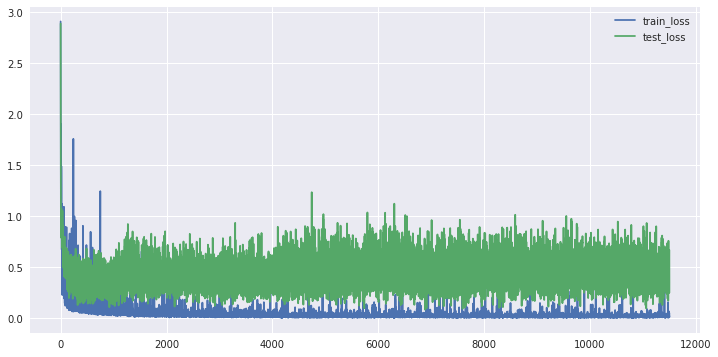

In [21]:
df=pd.DataFrame({"train_loss":trainingloss["loss"],"test_loss":testloss["loss"]})
df[["train_loss","test_loss"]].plot(figsize=(12,6))

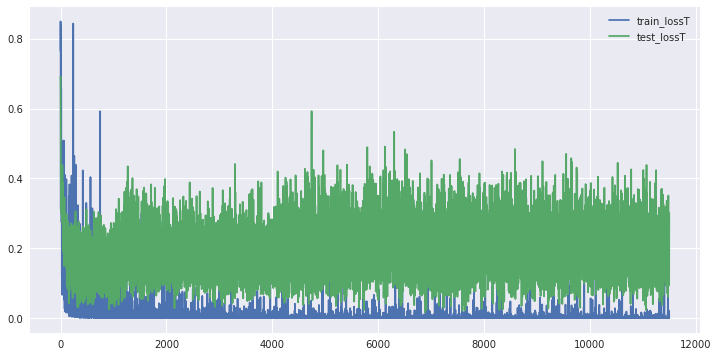

In [19]:
df=pd.DataFrame({"train_lossT":trainingloss["lossT"],"test_lossT":testloss["lossT"]})
df[["train_lossT","test_lossT"]].plot(figsize=(12,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5da29e84a8>,
      dtype=object)

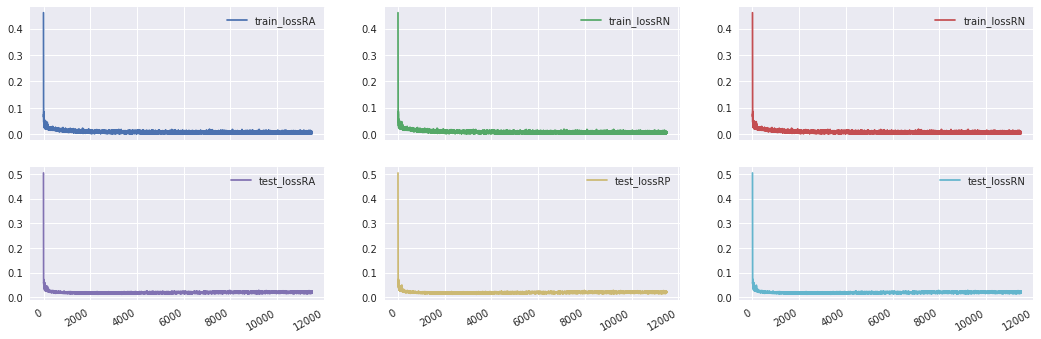

In [25]:
# df=pd.DataFrame(trainingloss)
df=pd.DataFrame({"train_lossRA":trainingloss["lossRA"],"test_lossRA":testloss["lossRA"],
                "train_lossRP":trainingloss["lossRP"],"test_lossRP":testloss["lossRP"],
                 "train_lossRN":trainingloss["lossRN"],"test_lossRN":testloss["lossRN"],
                })
# df[["train_lossT","test_lossT"]].plot(figsize=(12,6))
df[["train_lossRA","train_lossRN","train_lossRN","test_lossRA","test_lossRP","test_lossRN"]].plot(subplots=True,
                                                                                                   figsize=(18,6),layout=(2,3))

## Save model

In [26]:
modelstatpath="EncoderStat.pt"
torch.save(modelEncoder.state_dict(),modelstatpath) 

## Save DATA

In [27]:
dfTrain=pd.DataFrame(trainingloss)
dfTest=pd.DataFrame(testloss)

In [28]:
trainLossPath="TrainLoss.p"
testLossPath="TestLoss.p"
dfTrain.to_pickle(trainLossPath)
dfTest.to_pickle(testLossPath)

### PLOT

In [147]:
y=torch.randn(2)
win=vis.line(Y=[1,2],X=[1,4],win=win,update="append",opts=opts(win="Total-loss-2"))

In [144]:
win="test"
# opts={"markers":True,"xlabel":"epochs","title":"test Loss","width":1200,"heigh":300}
y=torch.randn(3)
win=vis.line(y,X=[1,2,3],win=win,opts=opts(),name="train-loss")

In [145]:
win="X"
# opts={"markers":True,"xlabel":"epochs","title":"X Loss","width":1200,"heigh":300}
y=torch.randn(3)
win=vis.line(y,X=[1,2,3],win=win,opts=opts(),name="train-loss")

In [146]:
vis